# Densenet hippocampus

Number of predictions: 1350
Number of actual values: 1350
Mean correlation: 0.1239
Standard deviation of correlation: 0.2057


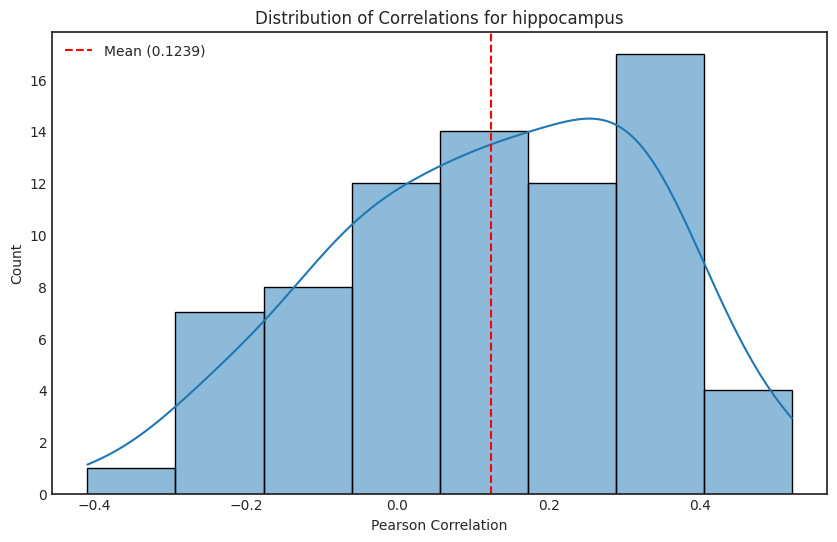

Overall correlation (APA format): r(1348) = 0.07, p = 0.0062


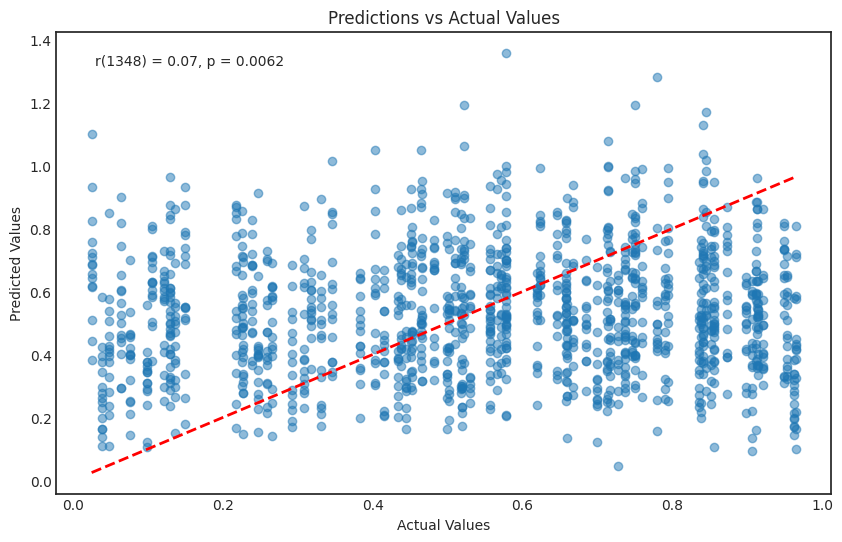

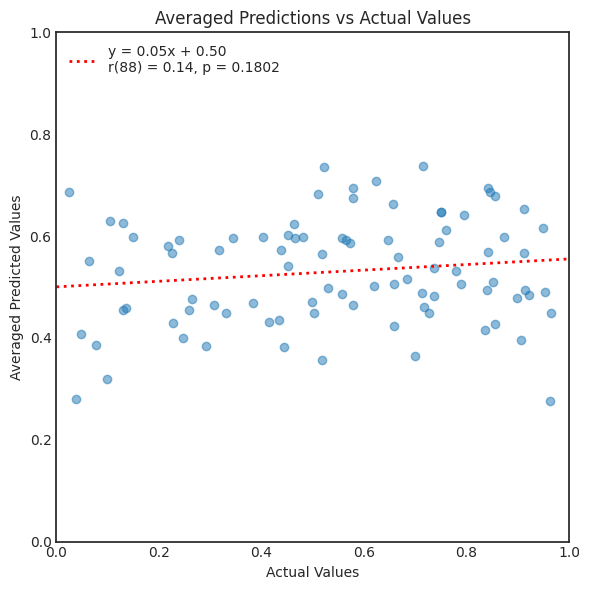

Correlation of averaged predictions (APA format): r(88) = 0.14, p = 0.1802
Regression line: y = 0.0548x + 0.5002

CREATING CSV FILE WITH ID MATCHING
Loaded target data with 90 rows
Created results DataFrame with 90 rows
Sample of results:
     ID  Actual  Prediction_1  Prediction_2  Prediction_3  Prediction_4  \
0  1064  0.0246        0.3837        0.7109        0.6186        0.6439   
1  1073  0.0389        0.2763        0.3765        0.3443        0.5818   
2  1020  0.0478        0.4259        0.5072        0.4071        0.5764   
3  1031  0.0636        0.5257        0.6533        0.6026        0.9010   
4  1044  0.0763        0.4008        0.4621        0.4547        0.4663   

   Prediction_5  Prediction_6  Prediction_7  Prediction_8  Prediction_9  \
0        0.5081        0.6845        0.4436        0.6134        0.7240   
1        0.2628        0.1975        0.2487        0.2952        0.3945   
2        0.2807        0.2375        0.2079        0.3958        0.4174   
3        0

In [46]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import glob

def extract_data(file_content):
    folds_data = []
    for fold in range(1, 6):
        pattern = rf"Fold {fold}.*?Predicted tensors for test set:\s*tensor\((.*?)\).*?Target tensorsfor test set:\s*tensor\((.*?)\)"
        match = re.search(pattern, file_content, re.DOTALL)
        if match:
            predictions = eval(f"[{match.group(1)}]")
            targets = eval(f"[{match.group(2)}]")
            folds_data.append((predictions, targets))
    return folds_data

def process_file(filename):
    with open(filename, 'r') as file:
        content = file.read()
    return extract_data(content)

def calculate_correlations(folds_data):
    correlations = []
    for predictions, targets in folds_data:
        predictions_flat = [item for sublist in predictions for item in sublist]
        targets_flat = [item for sublist in targets for item in sublist]
        if len(predictions_flat) > 1 and len(targets_flat) > 1:
            corr, _ = stats.pearsonr(predictions_flat, targets_flat)
            correlations.append(corr)
    return correlations

# Process all files
all_correlations_densenet_hippo = []
all_predictions = []
all_actual = []

for filename in glob.glob('densenet_results/job_output_DenseNet_hippocampus_*.out'):
    if 'old' not in filename.lower() and 'extra' not in filename.lower():
        folds_data = process_file(filename)
        correlations = calculate_correlations(folds_data)
        all_correlations_densenet_hippo.extend(correlations)
        
        for predictions, targets in folds_data:
            all_predictions.extend([item for sublist in predictions for item in sublist])
            all_actual.extend([item for sublist in targets for item in sublist])

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_actual = np.array(all_actual)

print(f"Number of predictions: {len(all_predictions)}")
print(f"Number of actual values: {len(all_actual)}")

if len(all_predictions) == 0 or len(all_actual) == 0:
    print("No data extracted from files. Please check your input files and patterns.")
else:
    # Calculate mean and SD
    mean_correlation = np.mean(all_correlations_densenet_hippo)
    std_correlation = np.std(all_correlations_densenet_hippo)

    print(f"Mean correlation: {mean_correlation:.4f}")
    print(f"Standard deviation of correlation: {std_correlation:.4f}")

    # Plot distribution of correlations
    plt.figure(figsize=(10, 6))
    sns.histplot(all_correlations_densenet_hippo, kde=True)
    plt.title("Distribution of Correlations for hippocampus")
    plt.xlabel("Pearson Correlation")
    plt.axvline(mean_correlation, color='r', linestyle='--', label=f"Mean ({mean_correlation:.4f})")
    plt.legend()
    # plt.savefig('densenet_hippo_correlation_distribution.svg', format='svg', bbox_inches='tight')
    plt.show()

    # Calculate correlation for all predictions
    if len(all_predictions) > 1 and len(all_actual) > 1:
        final_corr, final_p_value = stats.pearsonr(all_actual, all_predictions)
        df_final = len(all_actual) - 2  # degrees of freedom
        print(f"Overall correlation (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")

        # Create scatter plot of predictions vs actual values
        plt.figure(figsize=(10, 6))
        plt.scatter(all_actual, all_predictions, alpha=0.5)
        plt.title("Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.plot([min(all_actual), max(all_actual)], [min(all_actual), max(all_actual)], 'r--', lw=2)
        plt.text(0.05, 0.95, f'r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}', 
                 transform=plt.gca().transAxes, verticalalignment='top')
        #plt.savefig('densenet_hippo_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Calculate average predictions for each unique actual value
        predictions_by_actual = {}
        for actual, pred in zip(all_actual, all_predictions):
            if actual not in predictions_by_actual:
                predictions_by_actual[actual] = []
            predictions_by_actual[actual].append(pred)

        avg_predictions = []
        unique_actual = []
        for actual, preds in sorted(predictions_by_actual.items()):
            unique_actual.append(actual)
            avg_predictions.append(np.mean(preds))

        unique_actual = np.array(unique_actual)
        avg_predictions = np.array(avg_predictions)

        # Calculate correlation for averaged predictions
        avg_corr, avg_p_value = stats.pearsonr(unique_actual, avg_predictions)
        df_avg = len(unique_actual) - 2  # degrees of freedom
        
        # Calculate the linear regression line
        slope_reg, intercept_reg, _, _, _ = stats.linregress(unique_actual, avg_predictions)
        
        # Create scatter plot of averaged predictions vs actual values
        plt.figure(figsize=(6, 6))
        plt.scatter(unique_actual, avg_predictions, alpha=0.5)

        # Plot the regression line
        x_range = np.array([0, 1])
        y_range_reg = slope_reg * x_range + intercept_reg

        plt.plot(x_range, y_range_reg, 'r:', linewidth=2, 
                 label=f'y = {slope_reg:.2f}x + {intercept_reg:.2f}\nr({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}')

        plt.title("Averaged Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Averaged Predicted Values")
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # Adjust legend position and font size
        plt.legend(loc='upper left', fontsize='medium')

        # Adjust layout to prevent cutting off the legend
        plt.tight_layout()

        plt.savefig('final_plots/densenet_hippocampus_avg_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Print correlation and p-value in APA format
        print(f"Correlation of averaged predictions (APA format): r({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}")
        print(f"Regression line: y = {slope_reg:.4f}x + {intercept_reg:.4f}")

        # ===== NEW SECTION: Create CSV with ID matching =====
        print("\n" + "="*50)
        print("CREATING CSV FILE WITH ID MATCHING")
        print("="*50)
        
        try:
            # Load the target data to get IDs
            target_df = pd.read_csv('radiomic_results/DataAnalysisWith90Participants_Jupyter.csv')
            print(f"Loaded target data with {len(target_df)} rows")
            
            # Create initial DataFrame using existing all_actual and all_predictions
            results_df = pd.DataFrame({
                'Actual': all_actual,
                'Prediction': all_predictions
            })
            
            # Round actual values for matching
            results_df['Actual'] = results_df['Actual'].round(4)
            target_df['Model_Building_Total'] = target_df['Model_Building_Total'].round(4)
            
            # Create a mapping from actual values to IDs
            actual_to_id = dict(zip(target_df['Model_Building_Total'], target_df['ID']))
            
            # Add ID column by matching actual values
            results_df['ID'] = results_df['Actual'].map(actual_to_id)
            
            # Check for missing matches
            missing_matches = results_df['ID'].isna().sum()
            if missing_matches > 0:
                print(f"Warning: {missing_matches} actual values could not be matched with IDs")
                # Remove rows without ID matches
                results_df = results_df.dropna(subset=['ID'])
            
            # Group by ID and Actual to aggregate multiple predictions per participant
            grouped = results_df.groupby(['ID', 'Actual'])['Prediction'].apply(list).reset_index()
            
            # Create final DataFrame in the format of the first code
            final_results = []
            for _, row in grouped.iterrows():
                predictions = row['Prediction']
                record = {
                    'ID': int(row['ID']),
                    'Actual': row['Actual']
                }
                
                # Add individual predictions
                for i, pred in enumerate(predictions):
                    record[f'Prediction_{i+1}'] = round(pred, 4)
                
                # Add average prediction
                record['Average_Prediction'] = round(np.mean(predictions), 4)
                
                final_results.append(record)
            
            # Create final DataFrame
            results_df = pd.DataFrame(final_results)
            
            # Sort by actual values
            results_df = results_df.sort_values('Actual').reset_index(drop=True)
            
            # Reorder columns to match the first script's format
            prediction_cols = [col for col in results_df.columns if col.startswith('Prediction_')]
            column_order = ['ID', 'Actual'] + sorted(prediction_cols, key=lambda x: int(x.split('_')[1])) + ['Average_Prediction']
            results_df = results_df[column_order]
            
            print(f"Created results DataFrame with {len(results_df)} rows")
            print("Sample of results:")
            print(results_df.head())
            
            # Save to CSV
            output_filename = 'densenet_hippocampus_predictions_with_average_and_id.csv'
            results_df.to_csv(output_filename, index=False)
            print(f"\nResults saved to '{output_filename}'")
            print(f"File contains {len(results_df)} rows and {len(results_df.columns)} columns")
            
        except FileNotFoundError:
            print("Error: Could not find 'radiomic_results/DataAnalysisWith90Participants_Jupyter.csv'")
            print("Please ensure the file exists in the correct location.")
        except Exception as e:
            print(f"Error creating CSV file: {str(e)}")
            import traceback
            traceback.print_exc()
        
        # ===== END NEW SECTION =====
        
    else:
        print("Not enough data to calculate correlations or create plots.")

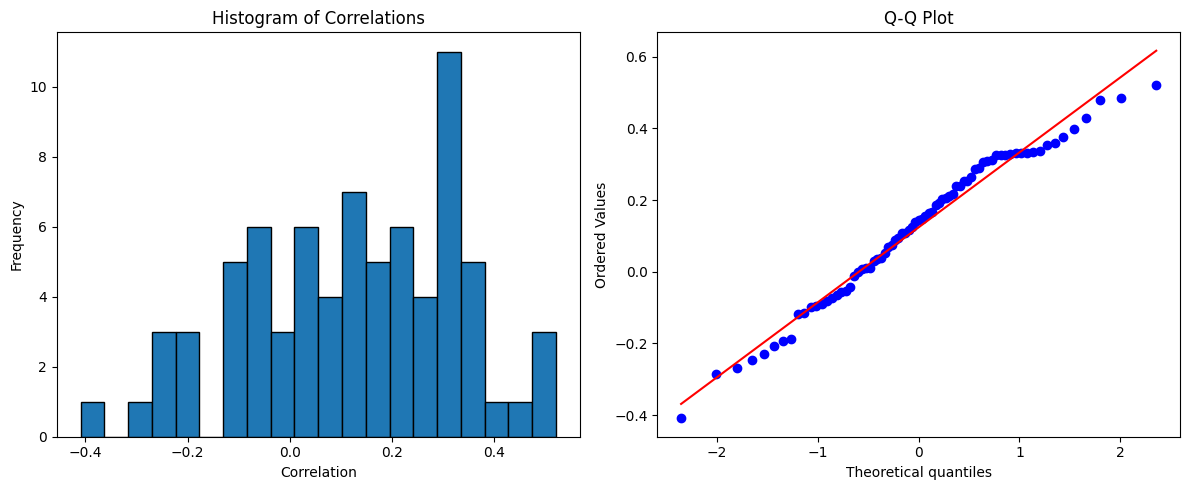


--- APA Style Results ---
Descriptive Statistics:
M = 0.12, SD = 0.21, 95% CI [0.08, 0.17]
N = 75

Normality Assessment:
Shapiro-Wilk test: W(74) = 0.977, p = 0.183

Inference Statistics:
One-sample t-test: t(74) = 5.18, p < .001, d = 0.60
Wilcoxon signed-rank test: W = 577.0, p < .001

APA Formatted Results Section:
The correlation coefficients (M = 0.12, SD = 0.21) were significantly different from zero, t(74) = 5.18, p < .001, d = 0.60, 95% CI [0.08, 0.17].


In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Use the correct variable name from your code
all_correlations = all_correlations_densenet_hippo

# Number of values in all_correlations
num_correlations = len(all_correlations)

# Descriptive statistics
mean_correlation = np.mean(all_correlations)
std_correlation = np.std(all_correlations, ddof=1)  # Using N-1 for sample std dev

# Wilcoxon signed-rank test
wilcoxon_statistic, wilcoxon_p_value = stats.wilcoxon(all_correlations)

# One-sample t-test
t_statistic, t_p_value = stats.ttest_1samp(all_correlations, 0)

# Calculate Cohen's d for one-sample t-test
cohens_d = mean_correlation / std_correlation  # For one-sample t-test comparing to zero

# Calculate 95% confidence interval
degrees_freedom = num_correlations - 1
ci_95 = stats.t.interval(0.95, degrees_freedom, loc=mean_correlation, 
                         scale=std_correlation/np.sqrt(num_correlations))

# Check normality using Shapiro-Wilk test
shapiro_statistic, shapiro_p_value = stats.shapiro(all_correlations)

# Create Q-Q plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
ax1.hist(all_correlations, bins=20, edgecolor='black')
ax1.set_title('Histogram of Correlations')
ax1.set_xlabel('Correlation')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(all_correlations, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot")
plt.tight_layout()
plt.show()

# Format p-values according to APA
def format_p_value(p):
    if p < 0.001:
        return "p < .001"
    else:
        return f"p = {p:.3f}"

# Print statistical results in APA format
print("\n--- APA Style Results ---")
print("Descriptive Statistics:")
print(f"M = {mean_correlation:.2f}, SD = {std_correlation:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
print(f"N = {num_correlations}")

print("\nNormality Assessment:")
print(f"Shapiro-Wilk test: W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}")

print("\nInference Statistics:")
print(f"One-sample t-test: t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}")
print(f"Wilcoxon signed-rank test: W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}")

# APA formatted result (ready for copy-paste)
print("\nAPA Formatted Results Section:")
if shapiro_p_value >= 0.05:
    print(f"The correlation coefficients (M = {mean_correlation:.2f}, SD = {std_correlation:.2f}) were {'not ' if t_p_value >= 0.05 else ''}significantly different from zero, t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}].")
else:
    print(f"Due to the non-normal distribution of correlation coefficients (Shapiro-Wilk W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}), a Wilcoxon signed-rank test was conducted. The correlations (Mdn = {np.median(all_correlations):.2f}) were {'not ' if wilcoxon_p_value >= 0.05 else ''}significantly different from zero, W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}. For completeness, a t-test yielded t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}.")

# Densenet thalamus

Number of predictions: 1350
Number of actual values: 1350
Mean correlation: 0.1954
Standard deviation of correlation: 0.1880


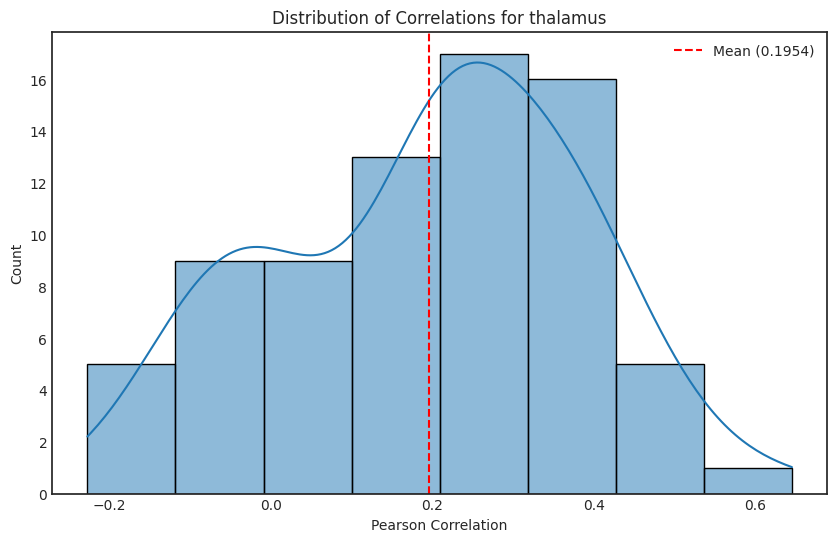

Overall correlation (APA format): r(1348) = 0.11, p = 0.0001


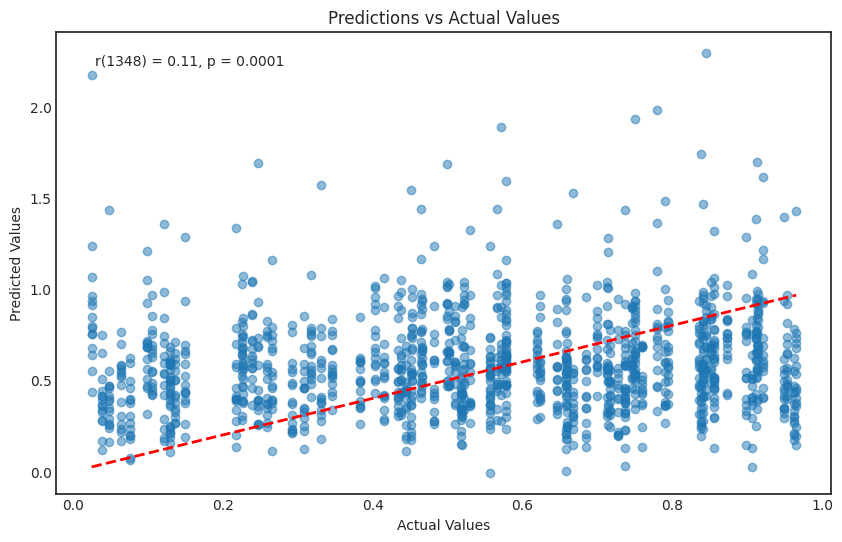

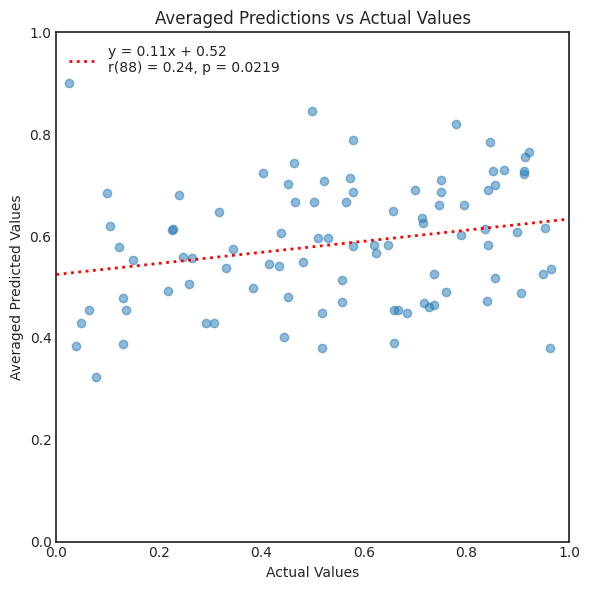

Correlation of averaged predictions (APA format): r(88) = 0.24, p = 0.0219
Regression line: y = 0.1087x + 0.5245

CREATING CSV FILE WITH ID MATCHING
Loaded target data with 90 rows
Created results DataFrame with 90 rows
Sample of results:
     ID  Actual  Prediction_1  Prediction_2  Prediction_3  Prediction_4  \
0  1064  0.0246        1.0670        0.6778        1.2353        0.8462   
1  1073  0.0389        0.3612        0.1690        0.6488        0.2741   
2  1020  0.0478        0.3833        0.2880        0.4582        0.2549   
3  1031  0.0636        0.7661        0.5183        0.5614        0.2589   
4  1044  0.0763        0.3931        0.2329        0.4583        0.6207   

   Prediction_5  Prediction_6  Prediction_7  Prediction_8  Prediction_9  \
0        0.9345        0.7958        0.6357        0.9115        0.7530   
1        0.4105        0.3234        0.3557        0.3918        0.4134   
2        0.4104        0.3287        0.3950        0.5489        0.3466   
3        0

In [47]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import glob

def extract_data(file_content):
    folds_data = []
    for fold in range(1, 6):
        pattern = rf"Fold {fold}.*?Predicted tensors for test set:\s*tensor\((.*?)\).*?Target tensorsfor test set:\s*tensor\((.*?)\)"
        match = re.search(pattern, file_content, re.DOTALL)
        if match:
            predictions = eval(f"[{match.group(1)}]")
            targets = eval(f"[{match.group(2)}]")
            folds_data.append((predictions, targets))
    return folds_data

def process_file(filename):
    with open(filename, 'r') as file:
        content = file.read()
    return extract_data(content)

def calculate_correlations(folds_data):
    correlations = []
    for predictions, targets in folds_data:
        predictions_flat = [item for sublist in predictions for item in sublist]
        targets_flat = [item for sublist in targets for item in sublist]
        if len(predictions_flat) > 1 and len(targets_flat) > 1:
            corr, _ = stats.pearsonr(predictions_flat, targets_flat)
            correlations.append(corr)
    return correlations

# Process all files
all_correlations_densenet_thalamus = []
all_predictions = []
all_actual = []

for filename in glob.glob('densenet_results/job_output_DenseNet_thalamus_*.out'):
    if 'old' not in filename.lower() and 'extra' not in filename.lower():
        folds_data = process_file(filename)
        correlations = calculate_correlations(folds_data)
        all_correlations_densenet_thalamus.extend(correlations)
        
        for predictions, targets in folds_data:
            all_predictions.extend([item for sublist in predictions for item in sublist])
            all_actual.extend([item for sublist in targets for item in sublist])

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_actual = np.array(all_actual)

print(f"Number of predictions: {len(all_predictions)}")
print(f"Number of actual values: {len(all_actual)}")

if len(all_predictions) == 0 or len(all_actual) == 0:
    print("No data extracted from files. Please check your input files and patterns.")
else:
    # Calculate mean and SD
    mean_correlation = np.mean(all_correlations_densenet_thalamus)
    std_correlation = np.std(all_correlations_densenet_thalamus)

    print(f"Mean correlation: {mean_correlation:.4f}")
    print(f"Standard deviation of correlation: {std_correlation:.4f}")

    # Plot distribution of correlations
    plt.figure(figsize=(10, 6))
    sns.histplot(all_correlations_densenet_thalamus, kde=True)
    plt.title("Distribution of Correlations for thalamus")
    plt.xlabel("Pearson Correlation")
    plt.axvline(mean_correlation, color='r', linestyle='--', label=f"Mean ({mean_correlation:.4f})")
    plt.legend()
    # plt.savefig('densenet_thalamus_correlation_distribution.svg', format='svg', bbox_inches='tight')
    plt.show()

    # Calculate correlation for all predictions
    if len(all_predictions) > 1 and len(all_actual) > 1:
        final_corr, final_p_value = stats.pearsonr(all_actual, all_predictions)
        df_final = len(all_actual) - 2  # degrees of freedom
        print(f"Overall correlation (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")

        # Create scatter plot of predictions vs actual values
        plt.figure(figsize=(10, 6))
        plt.scatter(all_actual, all_predictions, alpha=0.5)
        plt.title("Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.plot([min(all_actual), max(all_actual)], [min(all_actual), max(all_actual)], 'r--', lw=2)
        plt.text(0.05, 0.95, f'r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}', 
                 transform=plt.gca().transAxes, verticalalignment='top')
        #plt.savefig('densenet_thalamus_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Calculate average predictions for each unique actual value
        predictions_by_actual = {}
        for actual, pred in zip(all_actual, all_predictions):
            if actual not in predictions_by_actual:
                predictions_by_actual[actual] = []
            predictions_by_actual[actual].append(pred)

        avg_predictions = []
        unique_actual = []
        for actual, preds in sorted(predictions_by_actual.items()):
            unique_actual.append(actual)
            avg_predictions.append(np.mean(preds))

        unique_actual = np.array(unique_actual)
        avg_predictions = np.array(avg_predictions)

        # Calculate correlation for averaged predictions
        avg_corr, avg_p_value = stats.pearsonr(unique_actual, avg_predictions)
        df_avg = len(unique_actual) - 2  # degrees of freedom
        
        # Calculate the linear regression line
        slope_reg, intercept_reg, _, _, _ = stats.linregress(unique_actual, avg_predictions)
        
        # Create scatter plot of averaged predictions vs actual values
        plt.figure(figsize=(6, 6))
        plt.scatter(unique_actual, avg_predictions, alpha=0.5)

        # Plot the regression line
        x_range = np.array([0, 1])
        y_range_reg = slope_reg * x_range + intercept_reg

        plt.plot(x_range, y_range_reg, 'r:', linewidth=2, 
                 label=f'y = {slope_reg:.2f}x + {intercept_reg:.2f}\nr({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}')

        plt.title("Averaged Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Averaged Predicted Values")
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # Adjust legend position and font size
        plt.legend(loc='upper left', fontsize='medium')

        # Adjust layout to prevent cutting off the legend
        plt.tight_layout()

        plt.savefig('final_plots/densenet_thalamus_avg_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Print correlation and p-value in APA format
        print(f"Correlation of averaged predictions (APA format): r({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}")
        print(f"Regression line: y = {slope_reg:.4f}x + {intercept_reg:.4f}")

        # ===== NEW SECTION: Create CSV with ID matching =====
        print("\n" + "="*50)
        print("CREATING CSV FILE WITH ID MATCHING")
        print("="*50)
        
        try:
            # Load the target data to get IDs
            target_df = pd.read_csv('radiomic_results/DataAnalysisWith90Participants_Jupyter.csv')
            print(f"Loaded target data with {len(target_df)} rows")
            
            # Create initial DataFrame using existing all_actual and all_predictions
            results_df = pd.DataFrame({
                'Actual': all_actual,
                'Prediction': all_predictions
            })
            
            # Round actual values for matching
            results_df['Actual'] = results_df['Actual'].round(4)
            target_df['Model_Building_Total'] = target_df['Model_Building_Total'].round(4)
            
            # Create a mapping from actual values to IDs
            actual_to_id = dict(zip(target_df['Model_Building_Total'], target_df['ID']))
            
            # Add ID column by matching actual values
            results_df['ID'] = results_df['Actual'].map(actual_to_id)
            
            # Check for missing matches
            missing_matches = results_df['ID'].isna().sum()
            if missing_matches > 0:
                print(f"Warning: {missing_matches} actual values could not be matched with IDs")
                # Remove rows without ID matches
                results_df = results_df.dropna(subset=['ID'])
            
            # Group by ID and Actual to aggregate multiple predictions per participant
            grouped = results_df.groupby(['ID', 'Actual'])['Prediction'].apply(list).reset_index()
            
            # Create final DataFrame in the format of the first code
            final_results = []
            for _, row in grouped.iterrows():
                predictions = row['Prediction']
                record = {
                    'ID': int(row['ID']),
                    'Actual': row['Actual']
                }
                
                # Add individual predictions
                for i, pred in enumerate(predictions):
                    record[f'Prediction_{i+1}'] = round(pred, 4)
                
                # Add average prediction
                record['Average_Prediction'] = round(np.mean(predictions), 4)
                
                final_results.append(record)
            
            # Create final DataFrame
            results_df = pd.DataFrame(final_results)
            
            # Sort by actual values
            results_df = results_df.sort_values('Actual').reset_index(drop=True)
            
            # Reorder columns to match the first script's format
            prediction_cols = [col for col in results_df.columns if col.startswith('Prediction_')]
            column_order = ['ID', 'Actual'] + sorted(prediction_cols, key=lambda x: int(x.split('_')[1])) + ['Average_Prediction']
            results_df = results_df[column_order]
            
            print(f"Created results DataFrame with {len(results_df)} rows")
            print("Sample of results:")
            print(results_df.head())
            
            # Save to CSV
            output_filename = 'densenet_thalamus_predictions_with_average_and_id.csv'
            results_df.to_csv(output_filename, index=False)
            print(f"\nResults saved to '{output_filename}'")
            print(f"File contains {len(results_df)} rows and {len(results_df.columns)} columns")
            
        except FileNotFoundError:
            print("Error: Could not find 'radiomic_results/DataAnalysisWith90Participants_Jupyter.csv'")
            print("Please ensure the file exists in the correct location.")
        except Exception as e:
            print(f"Error creating CSV file: {str(e)}")
            import traceback
            traceback.print_exc()
        
        # ===== END NEW SECTION =====
        
    else:
        print("Not enough data to calculate correlations or create plots.")

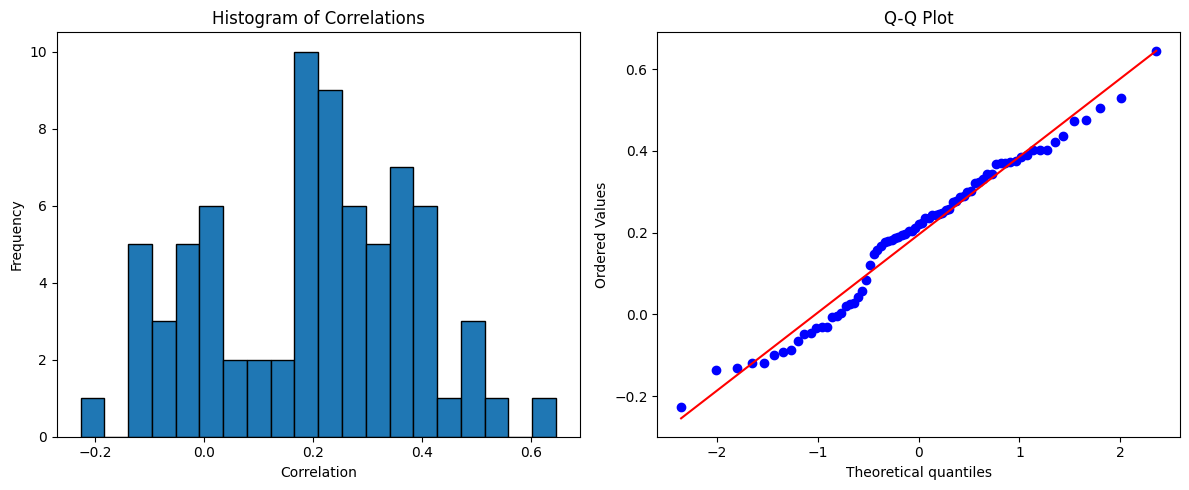


--- APA Style Results ---
Descriptive Statistics:
M = 0.20, SD = 0.19, 95% CI [0.15, 0.24]
N = 75

Normality Assessment:
Shapiro-Wilk test: W(74) = 0.974, p = 0.126

Inference Statistics:
One-sample t-test: t(74) = 8.94, p < .001, d = 1.03
Wilcoxon signed-rank test: W = 239.0, p < .001

APA Formatted Results Section:
The correlation coefficients (M = 0.20, SD = 0.19) were significantly different from zero, t(74) = 8.94, p < .001, d = 1.03, 95% CI [0.15, 0.24].


In [4]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Use the correct variable name from your code
all_correlations = all_correlations_densenet_thalamus

# Number of values in all_correlations
num_correlations = len(all_correlations)

# Descriptive statistics
mean_correlation = np.mean(all_correlations)
std_correlation = np.std(all_correlations, ddof=1)  # Using N-1 for sample std dev

# Wilcoxon signed-rank test
wilcoxon_statistic, wilcoxon_p_value = stats.wilcoxon(all_correlations)

# One-sample t-test
t_statistic, t_p_value = stats.ttest_1samp(all_correlations, 0)

# Calculate Cohen's d for one-sample t-test
cohens_d = mean_correlation / std_correlation  # For one-sample t-test comparing to zero

# Calculate 95% confidence interval
degrees_freedom = num_correlations - 1
ci_95 = stats.t.interval(0.95, degrees_freedom, loc=mean_correlation, 
                         scale=std_correlation/np.sqrt(num_correlations))

# Check normality using Shapiro-Wilk test
shapiro_statistic, shapiro_p_value = stats.shapiro(all_correlations)

# Create Q-Q plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
ax1.hist(all_correlations, bins=20, edgecolor='black')
ax1.set_title('Histogram of Correlations')
ax1.set_xlabel('Correlation')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(all_correlations, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot")
plt.tight_layout()
plt.show()

# Format p-values according to APA
def format_p_value(p):
    if p < 0.001:
        return "p < .001"
    else:
        return f"p = {p:.3f}"

# Print statistical results in APA format
print("\n--- APA Style Results ---")
print("Descriptive Statistics:")
print(f"M = {mean_correlation:.2f}, SD = {std_correlation:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
print(f"N = {num_correlations}")

print("\nNormality Assessment:")
print(f"Shapiro-Wilk test: W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}")

print("\nInference Statistics:")
print(f"One-sample t-test: t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}")
print(f"Wilcoxon signed-rank test: W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}")

# APA formatted result (ready for copy-paste)
print("\nAPA Formatted Results Section:")
if shapiro_p_value >= 0.05:
    print(f"The correlation coefficients (M = {mean_correlation:.2f}, SD = {std_correlation:.2f}) were {'not ' if t_p_value >= 0.05 else ''}significantly different from zero, t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}].")
else:
    print(f"Due to the non-normal distribution of correlation coefficients (Shapiro-Wilk W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}), a Wilcoxon signed-rank test was conducted. The correlations (Mdn = {np.median(all_correlations):.2f}) were {'not ' if wilcoxon_p_value >= 0.05 else ''}significantly different from zero, W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}. For completeness, a t-test yielded t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}.")

## Densenet amygdala

Number of predictions: 1350
Number of actual values: 1350
Mean correlation: 0.1044
Standard deviation of correlation: 0.2167


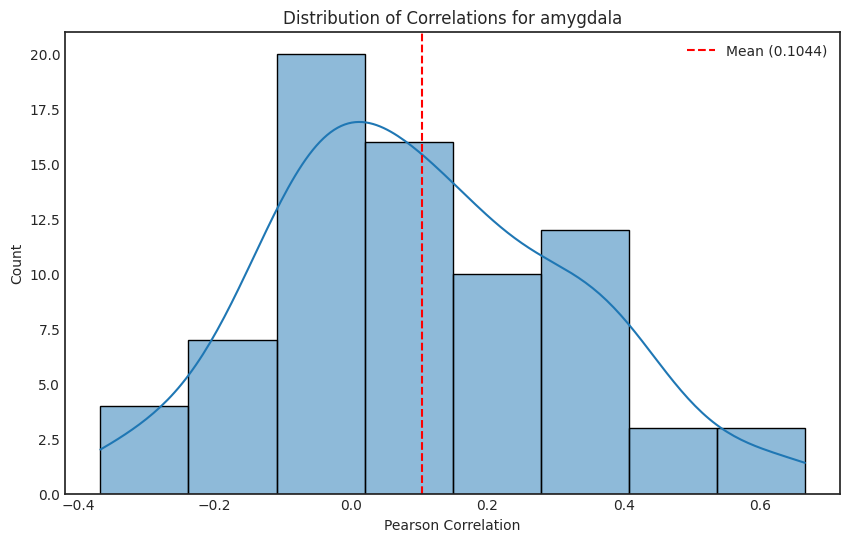

Overall correlation (APA format): r(1348) = 0.06, p = 0.0242


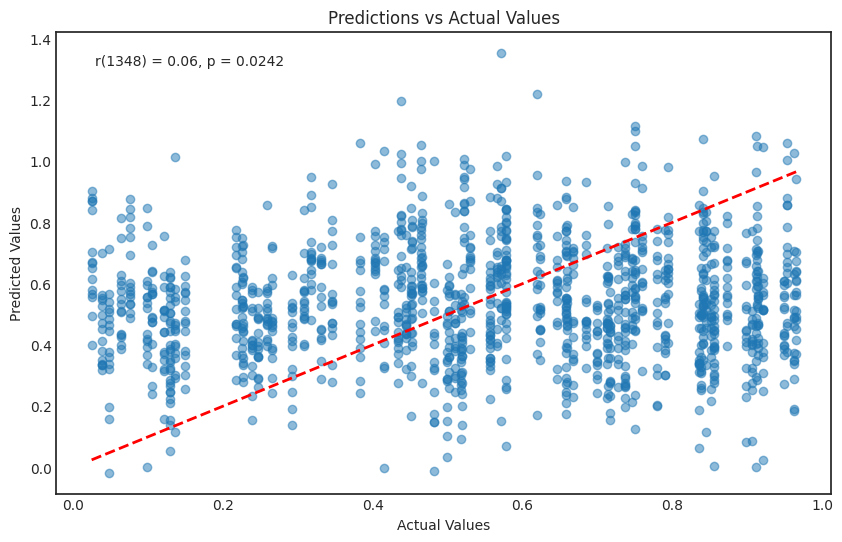

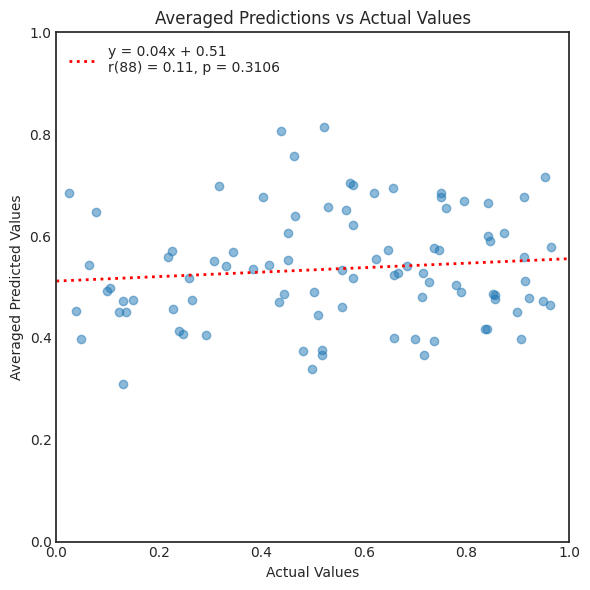

Correlation of averaged predictions (APA format): r(88) = 0.11, p = 0.3106
Regression line: y = 0.0439x + 0.5116

CREATING CSV FILE WITH ID MATCHING
Loaded target data with 90 rows
Created results DataFrame with 90 rows
Sample of results:
     ID  Actual  Prediction_1  Prediction_2  Prediction_3  Prediction_4  \
0  1064  0.0246        0.8712        0.4004        0.4937        0.8396   
1  1073  0.0389        0.3359        0.3499        0.3345        0.4520   
2  1020  0.0478        0.5189        0.5663        0.4837        0.4461   
3  1031  0.0636        0.7502        0.6088        0.3991        0.5957   
4  1044  0.0763        0.5669        0.7537        0.8190        0.5342   

   Prediction_5  Prediction_6  Prediction_7  Prediction_8  Prediction_9  \
0        0.6149        0.8688        0.6513        0.5781        0.9022   
1        0.5273        0.3788        0.4964        0.4141        0.5617   
2        0.3601        0.1972        0.3372        0.5412        0.5064   
3        0

In [48]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import glob

def extract_data(file_content):
    folds_data = []
    for fold in range(1, 6):
        pattern = rf"Fold {fold}.*?Predicted tensors for test set:\s*tensor\((.*?)\).*?Target tensorsfor test set:\s*tensor\((.*?)\)"
        match = re.search(pattern, file_content, re.DOTALL)
        if match:
            predictions = eval(f"[{match.group(1)}]")
            targets = eval(f"[{match.group(2)}]")
            folds_data.append((predictions, targets))
    return folds_data

def process_file(filename):
    with open(filename, 'r') as file:
        content = file.read()
    return extract_data(content)

def calculate_correlations(folds_data):
    correlations = []
    for predictions, targets in folds_data:
        predictions_flat = [item for sublist in predictions for item in sublist]
        targets_flat = [item for sublist in targets for item in sublist]
        if len(predictions_flat) > 1 and len(targets_flat) > 1:
            corr, _ = stats.pearsonr(predictions_flat, targets_flat)
            correlations.append(corr)
    return correlations

# Process all files
all_correlations_densenet_amygdala = []
all_predictions = []
all_actual = []

for filename in glob.glob('densenet_results/job_output_DenseNet_amygdala_*.out'):
    if 'old' not in filename.lower() and 'extra' not in filename.lower():
        folds_data = process_file(filename)
        correlations = calculate_correlations(folds_data)
        all_correlations_densenet_amygdala.extend(correlations)
        
        for predictions, targets in folds_data:
            all_predictions.extend([item for sublist in predictions for item in sublist])
            all_actual.extend([item for sublist in targets for item in sublist])

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_actual = np.array(all_actual)

print(f"Number of predictions: {len(all_predictions)}")
print(f"Number of actual values: {len(all_actual)}")

if len(all_predictions) == 0 or len(all_actual) == 0:
    print("No data extracted from files. Please check your input files and patterns.")
else:
    # Calculate mean and SD
    mean_correlation = np.mean(all_correlations_densenet_amygdala)
    std_correlation = np.std(all_correlations_densenet_amygdala)

    print(f"Mean correlation: {mean_correlation:.4f}")
    print(f"Standard deviation of correlation: {std_correlation:.4f}")

    # Plot distribution of correlations
    plt.figure(figsize=(10, 6))
    sns.histplot(all_correlations_densenet_amygdala, kde=True)
    plt.title("Distribution of Correlations for amygdala")
    plt.xlabel("Pearson Correlation")
    plt.axvline(mean_correlation, color='r', linestyle='--', label=f"Mean ({mean_correlation:.4f})")
    plt.legend()
    # plt.savefig('densenet_amygdala_correlation_distribution.svg', format='svg', bbox_inches='tight')
    plt.show()

    # Calculate correlation for all predictions
    if len(all_predictions) > 1 and len(all_actual) > 1:
        final_corr, final_p_value = stats.pearsonr(all_actual, all_predictions)
        df_final = len(all_actual) - 2  # degrees of freedom
        print(f"Overall correlation (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")

        # Create scatter plot of predictions vs actual values
        plt.figure(figsize=(10, 6))
        plt.scatter(all_actual, all_predictions, alpha=0.5)
        plt.title("Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.plot([min(all_actual), max(all_actual)], [min(all_actual), max(all_actual)], 'r--', lw=2)
        plt.text(0.05, 0.95, f'r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}', 
                 transform=plt.gca().transAxes, verticalalignment='top')
        #plt.savefig('densenet_amygdala_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Calculate average predictions for each unique actual value
        predictions_by_actual = {}
        for actual, pred in zip(all_actual, all_predictions):
            if actual not in predictions_by_actual:
                predictions_by_actual[actual] = []
            predictions_by_actual[actual].append(pred)

        avg_predictions = []
        unique_actual = []
        for actual, preds in sorted(predictions_by_actual.items()):
            unique_actual.append(actual)
            avg_predictions.append(np.mean(preds))

        unique_actual = np.array(unique_actual)
        avg_predictions = np.array(avg_predictions)

        # Calculate correlation for averaged predictions
        avg_corr, avg_p_value = stats.pearsonr(unique_actual, avg_predictions)
        df_avg = len(unique_actual) - 2  # degrees of freedom
        
        # Calculate the linear regression line
        slope_reg, intercept_reg, _, _, _ = stats.linregress(unique_actual, avg_predictions)
        
        # Create scatter plot of averaged predictions vs actual values
        plt.figure(figsize=(6, 6))
        plt.scatter(unique_actual, avg_predictions, alpha=0.5)

        # Plot the regression line
        x_range = np.array([0, 1])
        y_range_reg = slope_reg * x_range + intercept_reg

        plt.plot(x_range, y_range_reg, 'r:', linewidth=2, 
                 label=f'y = {slope_reg:.2f}x + {intercept_reg:.2f}\nr({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}')

        plt.title("Averaged Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Averaged Predicted Values")
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # Adjust legend position and font size
        plt.legend(loc='upper left', fontsize='medium')

        # Adjust layout to prevent cutting off the legend
        plt.tight_layout()

        plt.savefig('final_plots/densenet_amygdala_avg_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Print correlation and p-value in APA format
        print(f"Correlation of averaged predictions (APA format): r({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}")
        print(f"Regression line: y = {slope_reg:.4f}x + {intercept_reg:.4f}")

        # ===== NEW SECTION: Create CSV with ID matching =====
        print("\n" + "="*50)
        print("CREATING CSV FILE WITH ID MATCHING")
        print("="*50)
        
        try:
            # Load the target data to get IDs
            target_df = pd.read_csv('radiomic_results/DataAnalysisWith90Participants_Jupyter.csv')
            print(f"Loaded target data with {len(target_df)} rows")
            
            # Create initial DataFrame using existing all_actual and all_predictions
            results_df = pd.DataFrame({
                'Actual': all_actual,
                'Prediction': all_predictions
            })
            
            # Round actual values for matching
            results_df['Actual'] = results_df['Actual'].round(4)
            target_df['Model_Building_Total'] = target_df['Model_Building_Total'].round(4)
            
            # Create a mapping from actual values to IDs
            actual_to_id = dict(zip(target_df['Model_Building_Total'], target_df['ID']))
            
            # Add ID column by matching actual values
            results_df['ID'] = results_df['Actual'].map(actual_to_id)
            
            # Check for missing matches
            missing_matches = results_df['ID'].isna().sum()
            if missing_matches > 0:
                print(f"Warning: {missing_matches} actual values could not be matched with IDs")
                # Remove rows without ID matches
                results_df = results_df.dropna(subset=['ID'])
            
            # Group by ID and Actual to aggregate multiple predictions per participant
            grouped = results_df.groupby(['ID', 'Actual'])['Prediction'].apply(list).reset_index()
            
            # Create final DataFrame in the format of the first code
            final_results = []
            for _, row in grouped.iterrows():
                predictions = row['Prediction']
                record = {
                    'ID': int(row['ID']),
                    'Actual': row['Actual']
                }
                
                # Add individual predictions
                for i, pred in enumerate(predictions):
                    record[f'Prediction_{i+1}'] = round(pred, 4)
                
                # Add average prediction
                record['Average_Prediction'] = round(np.mean(predictions), 4)
                
                final_results.append(record)
            
            # Create final DataFrame
            results_df = pd.DataFrame(final_results)
            
            # Sort by actual values
            results_df = results_df.sort_values('Actual').reset_index(drop=True)
            
            # Reorder columns to match the first script's format
            prediction_cols = [col for col in results_df.columns if col.startswith('Prediction_')]
            column_order = ['ID', 'Actual'] + sorted(prediction_cols, key=lambda x: int(x.split('_')[1])) + ['Average_Prediction']
            results_df = results_df[column_order]
            
            print(f"Created results DataFrame with {len(results_df)} rows")
            print("Sample of results:")
            print(results_df.head())
            
            # Save to CSV
            output_filename = 'densenet_amygdala_predictions_with_average_and_id.csv'
            results_df.to_csv(output_filename, index=False)
            print(f"\nResults saved to '{output_filename}'")
            print(f"File contains {len(results_df)} rows and {len(results_df.columns)} columns")
            
        except FileNotFoundError:
            print("Error: Could not find 'radiomic_results/DataAnalysisWith90Participants_Jupyter.csv'")
            print("Please ensure the file exists in the correct location.")
        except Exception as e:
            print(f"Error creating CSV file: {str(e)}")
            import traceback
            traceback.print_exc()
        
        # ===== END NEW SECTION =====
        
    else:
        print("Not enough data to calculate correlations or create plots.")

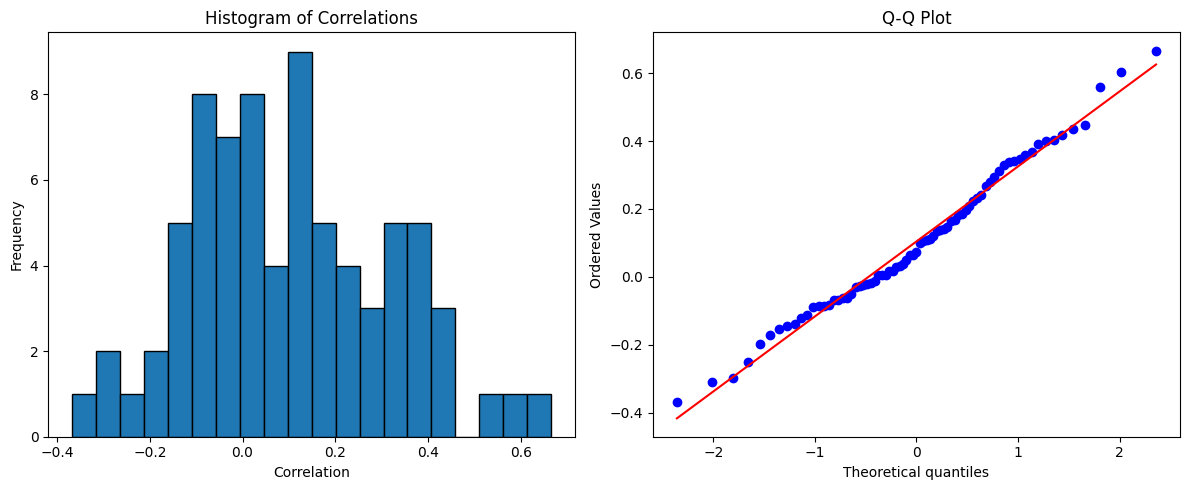


--- APA Style Results ---
Descriptive Statistics:
M = 0.10, SD = 0.22, 95% CI [0.05, 0.15]
N = 75

Normality Assessment:
Shapiro-Wilk test: W(74) = 0.986, p = 0.559

Inference Statistics:
One-sample t-test: t(74) = 4.15, p < .001, d = 0.48
Wilcoxon signed-rank test: W = 752.0, p < .001

APA Formatted Results Section:
The correlation coefficients (M = 0.10, SD = 0.22) were significantly different from zero, t(74) = 4.15, p < .001, d = 0.48, 95% CI [0.05, 0.15].


In [6]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Use the correct variable name from your code
all_correlations = all_correlations_densenet_amygdala  # CHANGED: thalamus -> amygdala

# Number of values in all_correlations
num_correlations = len(all_correlations)

# Descriptive statistics
mean_correlation = np.mean(all_correlations)
std_correlation = np.std(all_correlations, ddof=1)  # Using N-1 for sample std dev

# Wilcoxon signed-rank test
wilcoxon_statistic, wilcoxon_p_value = stats.wilcoxon(all_correlations)

# One-sample t-test
t_statistic, t_p_value = stats.ttest_1samp(all_correlations, 0)

# Calculate Cohen's d for one-sample t-test
cohens_d = mean_correlation / std_correlation  # For one-sample t-test comparing to zero

# Calculate 95% confidence interval
degrees_freedom = num_correlations - 1
ci_95 = stats.t.interval(0.95, degrees_freedom, loc=mean_correlation, 
                         scale=std_correlation/np.sqrt(num_correlations))

# Check normality using Shapiro-Wilk test
shapiro_statistic, shapiro_p_value = stats.shapiro(all_correlations)

# Create Q-Q plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
ax1.hist(all_correlations, bins=20, edgecolor='black')
ax1.set_title('Histogram of Correlations')
ax1.set_xlabel('Correlation')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(all_correlations, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot")

plt.tight_layout()
plt.show()

# Format p-values according to APA
def format_p_value(p):
    if p < 0.001:
        return "p < .001"
    else:
        return f"p = {p:.3f}"

# Print statistical results in APA format
print("\n--- APA Style Results ---")
print("Descriptive Statistics:")
print(f"M = {mean_correlation:.2f}, SD = {std_correlation:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
print(f"N = {num_correlations}")

print("\nNormality Assessment:")
print(f"Shapiro-Wilk test: W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}")

print("\nInference Statistics:")
print(f"One-sample t-test: t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}")
print(f"Wilcoxon signed-rank test: W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}")

# APA formatted result (ready for copy-paste)
print("\nAPA Formatted Results Section:")
if shapiro_p_value >= 0.05:
    print(f"The correlation coefficients (M = {mean_correlation:.2f}, SD = {std_correlation:.2f}) were {'not ' if t_p_value >= 0.05 else ''}significantly different from zero, t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}].")
else:
    print(f"Due to the non-normal distribution of correlation coefficients (Shapiro-Wilk W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}), a Wilcoxon signed-rank test was conducted. The correlations (Mdn = {np.median(all_correlations):.2f}) were {'not ' if wilcoxon_p_value >= 0.05 else ''}significantly different from zero, W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}. For completeness, a t-test yielded t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}.")

## Densenet isthmus cingulate

Number of predictions: 1350
Number of actual values: 1350
Mean correlation: 0.1108
Standard deviation of correlation: 0.1971


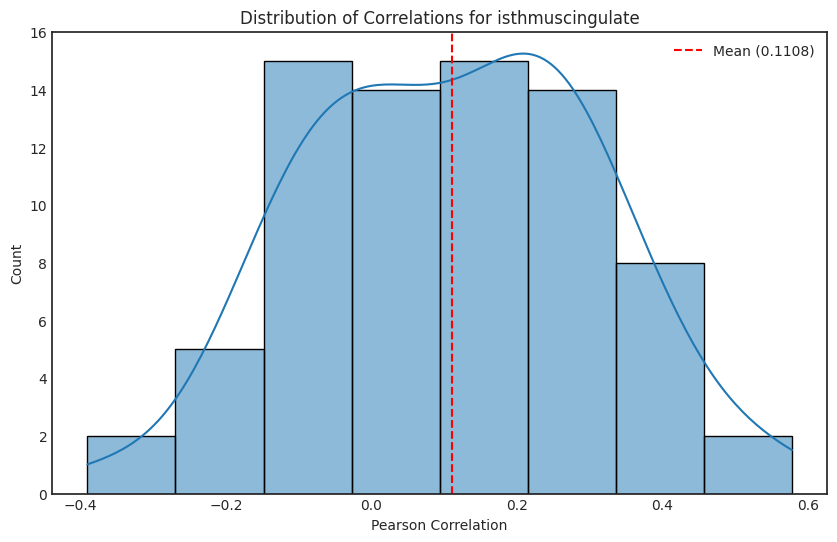

Overall correlation (APA format): r(1348) = 0.09, p = 0.0016


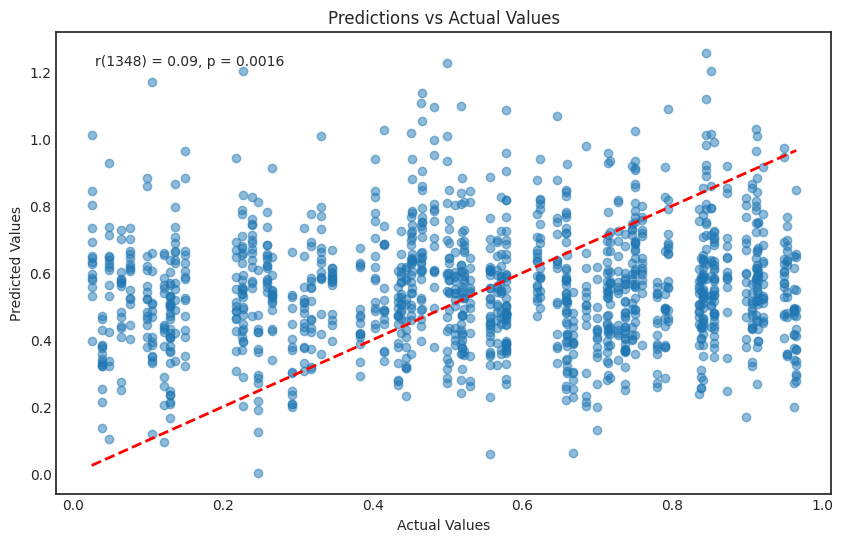

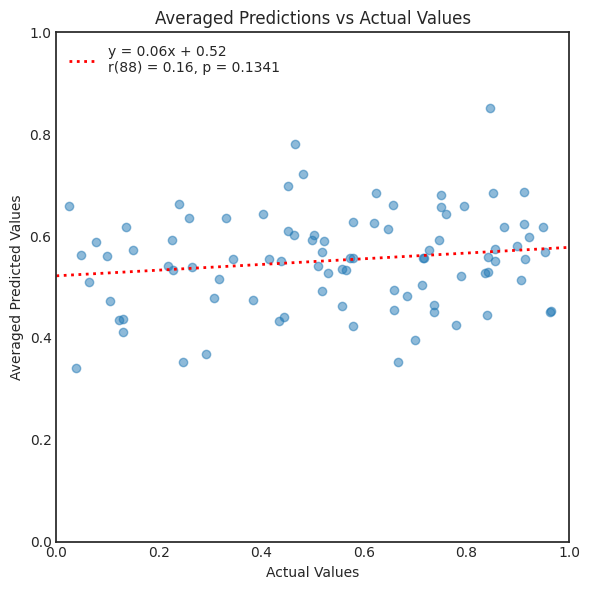

Correlation of averaged predictions (APA format): r(88) = 0.16, p = 0.1341
Regression line: y = 0.0558x + 0.5219

CREATING CSV FILE WITH ID MATCHING
Loaded target data with 90 rows
Created results DataFrame with 90 rows
Sample of results:
     ID  Actual  Prediction_1  Prediction_2  Prediction_3  Prediction_4  \
0  1064  0.0246        0.5975        0.5302        0.6442        0.8039   
1  1073  0.0389        0.4295        0.3748        0.3829        0.1352   
2  1020  0.0478        0.6093        0.6518        0.7377        0.3217   
3  1031  0.0636        0.7006        0.7290        0.5735        0.2514   
4  1044  0.0763        0.6056        0.7010        0.5224        0.5260   

   Prediction_5  Prediction_6  Prediction_7  Prediction_8  Prediction_9  \
0        1.0132        0.5583        0.6274        0.7328        0.8436   
1        0.3571        0.3203        0.2544        0.3431        0.4622   
2        0.7140        0.5306        0.6174        0.6279        0.6482   
3        0

In [49]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import glob

def extract_data(file_content):
    folds_data = []
    for fold in range(1, 6):
        pattern = rf"Fold {fold}.*?Predicted tensors for test set:\s*tensor\((.*?)\).*?Target tensorsfor test set:\s*tensor\((.*?)\)"
        match = re.search(pattern, file_content, re.DOTALL)
        if match:
            predictions = eval(f"[{match.group(1)}]")
            targets = eval(f"[{match.group(2)}]")
            folds_data.append((predictions, targets))
    return folds_data

def process_file(filename):
    with open(filename, 'r') as file:
        content = file.read()
    return extract_data(content)

def calculate_correlations(folds_data):
    correlations = []
    for predictions, targets in folds_data:
        predictions_flat = [item for sublist in predictions for item in sublist]
        targets_flat = [item for sublist in targets for item in sublist]
        if len(predictions_flat) > 1 and len(targets_flat) > 1:
            corr, _ = stats.pearsonr(predictions_flat, targets_flat)
            correlations.append(corr)
    return correlations

# Process all files
all_correlations_densenet_isthmuscingulate = []
all_predictions = []
all_actual = []

for filename in glob.glob('densenet_results/job_output_DenseNet_isthmuscingulate_*.out'):
    if 'old' not in filename.lower() and 'extra' not in filename.lower():
        folds_data = process_file(filename)
        correlations = calculate_correlations(folds_data)
        all_correlations_densenet_isthmuscingulate.extend(correlations)
        
        for predictions, targets in folds_data:
            all_predictions.extend([item for sublist in predictions for item in sublist])
            all_actual.extend([item for sublist in targets for item in sublist])

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_actual = np.array(all_actual)

print(f"Number of predictions: {len(all_predictions)}")
print(f"Number of actual values: {len(all_actual)}")

if len(all_predictions) == 0 or len(all_actual) == 0:
    print("No data extracted from files. Please check your input files and patterns.")
else:
    # Calculate mean and SD
    mean_correlation = np.mean(all_correlations_densenet_isthmuscingulate)
    std_correlation = np.std(all_correlations_densenet_isthmuscingulate)

    print(f"Mean correlation: {mean_correlation:.4f}")
    print(f"Standard deviation of correlation: {std_correlation:.4f}")

    # Plot distribution of correlations
    plt.figure(figsize=(10, 6))
    sns.histplot(all_correlations_densenet_isthmuscingulate, kde=True)
    plt.title("Distribution of Correlations for isthmuscingulate")
    plt.xlabel("Pearson Correlation")
    plt.axvline(mean_correlation, color='r', linestyle='--', label=f"Mean ({mean_correlation:.4f})")
    plt.legend()
    # plt.savefig('densenet_isthmuscingulate_correlation_distribution.svg', format='svg', bbox_inches='tight')
    plt.show()

    # Calculate correlation for all predictions
    if len(all_predictions) > 1 and len(all_actual) > 1:
        final_corr, final_p_value = stats.pearsonr(all_actual, all_predictions)
        df_final = len(all_actual) - 2  # degrees of freedom
        print(f"Overall correlation (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")

        # Create scatter plot of predictions vs actual values
        plt.figure(figsize=(10, 6))
        plt.scatter(all_actual, all_predictions, alpha=0.5)
        plt.title("Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.plot([min(all_actual), max(all_actual)], [min(all_actual), max(all_actual)], 'r--', lw=2)
        plt.text(0.05, 0.95, f'r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}', 
                 transform=plt.gca().transAxes, verticalalignment='top')
        #plt.savefig('densenet_isthmuscingulate_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Calculate average predictions for each unique actual value
        predictions_by_actual = {}
        for actual, pred in zip(all_actual, all_predictions):
            if actual not in predictions_by_actual:
                predictions_by_actual[actual] = []
            predictions_by_actual[actual].append(pred)

        avg_predictions = []
        unique_actual = []
        for actual, preds in sorted(predictions_by_actual.items()):
            unique_actual.append(actual)
            avg_predictions.append(np.mean(preds))

        unique_actual = np.array(unique_actual)
        avg_predictions = np.array(avg_predictions)

        # Calculate correlation for averaged predictions
        avg_corr, avg_p_value = stats.pearsonr(unique_actual, avg_predictions)
        df_avg = len(unique_actual) - 2  # degrees of freedom
        
        # Calculate the linear regression line
        slope_reg, intercept_reg, _, _, _ = stats.linregress(unique_actual, avg_predictions)
        
        # Create scatter plot of averaged predictions vs actual values
        plt.figure(figsize=(6, 6))
        plt.scatter(unique_actual, avg_predictions, alpha=0.5)

        # Plot the regression line
        x_range = np.array([0, 1])
        y_range_reg = slope_reg * x_range + intercept_reg

        plt.plot(x_range, y_range_reg, 'r:', linewidth=2, 
                 label=f'y = {slope_reg:.2f}x + {intercept_reg:.2f}\nr({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}')

        plt.title("Averaged Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Averaged Predicted Values")
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # Adjust legend position and font size
        plt.legend(loc='upper left', fontsize='medium')

        # Adjust layout to prevent cutting off the legend
        plt.tight_layout()

        plt.savefig('final_plots/densenet_isthmuscingulate_avg_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Print correlation and p-value in APA format
        print(f"Correlation of averaged predictions (APA format): r({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}")
        print(f"Regression line: y = {slope_reg:.4f}x + {intercept_reg:.4f}")

        # ===== NEW SECTION: Create CSV with ID matching =====
        print("\n" + "="*50)
        print("CREATING CSV FILE WITH ID MATCHING")
        print("="*50)
        
        try:
            # Load the target data to get IDs
            target_df = pd.read_csv('radiomic_results/DataAnalysisWith90Participants_Jupyter.csv')
            print(f"Loaded target data with {len(target_df)} rows")
            
            # Create initial DataFrame using existing all_actual and all_predictions
            results_df = pd.DataFrame({
                'Actual': all_actual,
                'Prediction': all_predictions
            })
            
            # Round actual values for matching
            results_df['Actual'] = results_df['Actual'].round(4)
            target_df['Model_Building_Total'] = target_df['Model_Building_Total'].round(4)
            
            # Create a mapping from actual values to IDs
            actual_to_id = dict(zip(target_df['Model_Building_Total'], target_df['ID']))
            
            # Add ID column by matching actual values
            results_df['ID'] = results_df['Actual'].map(actual_to_id)
            
            # Check for missing matches
            missing_matches = results_df['ID'].isna().sum()
            if missing_matches > 0:
                print(f"Warning: {missing_matches} actual values could not be matched with IDs")
                # Remove rows without ID matches
                results_df = results_df.dropna(subset=['ID'])
            
            # Group by ID and Actual to aggregate multiple predictions per participant
            grouped = results_df.groupby(['ID', 'Actual'])['Prediction'].apply(list).reset_index()
            
            # Create final DataFrame in the format of the first code
            final_results = []
            for _, row in grouped.iterrows():
                predictions = row['Prediction']
                record = {
                    'ID': int(row['ID']),
                    'Actual': row['Actual']
                }
                
                # Add individual predictions
                for i, pred in enumerate(predictions):
                    record[f'Prediction_{i+1}'] = round(pred, 4)
                
                # Add average prediction
                record['Average_Prediction'] = round(np.mean(predictions), 4)
                
                final_results.append(record)
            
            # Create final DataFrame
            results_df = pd.DataFrame(final_results)
            
            # Sort by actual values
            results_df = results_df.sort_values('Actual').reset_index(drop=True)
            
            # Reorder columns to match the first script's format
            prediction_cols = [col for col in results_df.columns if col.startswith('Prediction_')]
            column_order = ['ID', 'Actual'] + sorted(prediction_cols, key=lambda x: int(x.split('_')[1])) + ['Average_Prediction']
            results_df = results_df[column_order]
            
            print(f"Created results DataFrame with {len(results_df)} rows")
            print("Sample of results:")
            print(results_df.head())
            
            # Save to CSV
            output_filename = 'densenet_isthmuscingulate_predictions_with_average_and_id.csv'
            results_df.to_csv(output_filename, index=False)
            print(f"\nResults saved to '{output_filename}'")
            print(f"File contains {len(results_df)} rows and {len(results_df.columns)} columns")
            
        except FileNotFoundError:
            print("Error: Could not find 'radiomic_results/DataAnalysisWith90Participants_Jupyter.csv'")
            print("Please ensure the file exists in the correct location.")
        except Exception as e:
            print(f"Error creating CSV file: {str(e)}")
            import traceback
            traceback.print_exc()
        
        # ===== END NEW SECTION =====
        
    else:
        print("Not enough data to calculate correlations or create plots.")

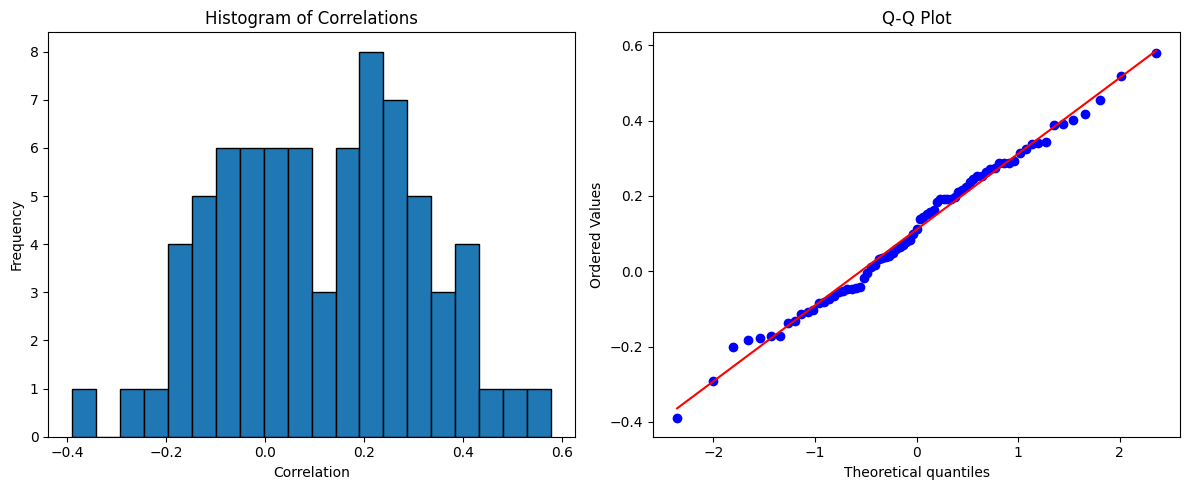


--- APA Style Results ---
Descriptive Statistics:
M = 0.11, SD = 0.20, 95% CI [0.07, 0.16]
N = 75

Normality Assessment:
Shapiro-Wilk test: W(74) = 0.991, p = 0.869

Inference Statistics:
One-sample t-test: t(74) = 4.83, p < .001, d = 0.56
Wilcoxon signed-rank test: W = 635.0, p < .001

APA Formatted Results Section:
The correlation coefficients (M = 0.11, SD = 0.20) were significantly different from zero, t(74) = 4.83, p < .001, d = 0.56, 95% CI [0.07, 0.16].


In [8]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Use the correct variable name from your code
all_correlations = all_correlations_densenet_isthmuscingulate  # CHANGED: thalamus -> isthmuscingulate 

# Number of values in all_correlations
num_correlations = len(all_correlations)

# Descriptive statistics
mean_correlation = np.mean(all_correlations)
std_correlation = np.std(all_correlations, ddof=1)  # Using N-1 for sample std dev

# Wilcoxon signed-rank test
wilcoxon_statistic, wilcoxon_p_value = stats.wilcoxon(all_correlations)

# One-sample t-test
t_statistic, t_p_value = stats.ttest_1samp(all_correlations, 0)

# Calculate Cohen's d for one-sample t-test
cohens_d = mean_correlation / std_correlation  # For one-sample t-test comparing to zero

# Calculate 95% confidence interval
degrees_freedom = num_correlations - 1
ci_95 = stats.t.interval(0.95, degrees_freedom, loc=mean_correlation, 
                         scale=std_correlation/np.sqrt(num_correlations))

# Check normality using Shapiro-Wilk test
shapiro_statistic, shapiro_p_value = stats.shapiro(all_correlations)

# Create Q-Q plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
ax1.hist(all_correlations, bins=20, edgecolor='black')
ax1.set_title('Histogram of Correlations')
ax1.set_xlabel('Correlation')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(all_correlations, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot")

plt.tight_layout()
plt.show()

# Format p-values according to APA
def format_p_value(p):
    if p < 0.001:
        return "p < .001"
    else:
        return f"p = {p:.3f}"

# Print statistical results in APA format
print("\n--- APA Style Results ---")
print("Descriptive Statistics:")
print(f"M = {mean_correlation:.2f}, SD = {std_correlation:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
print(f"N = {num_correlations}")

print("\nNormality Assessment:")
print(f"Shapiro-Wilk test: W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}")

print("\nInference Statistics:")
print(f"One-sample t-test: t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}")
print(f"Wilcoxon signed-rank test: W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}")

# APA formatted result (ready for copy-paste)
print("\nAPA Formatted Results Section:")
if shapiro_p_value >= 0.05:
    print(f"The correlation coefficients (M = {mean_correlation:.2f}, SD = {std_correlation:.2f}) were {'not ' if t_p_value >= 0.05 else ''}significantly different from zero, t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}].")
else:
    print(f"Due to the non-normal distribution of correlation coefficients (Shapiro-Wilk W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}), a Wilcoxon signed-rank test was conducted. The correlations (Mdn = {np.median(all_correlations):.2f}) were {'not ' if wilcoxon_p_value >= 0.05 else ''}significantly different from zero, W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}. For completeness, a t-test yielded t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}.")

## Densenet parahippocampus

Number of predictions: 1350
Number of actual values: 1350
Mean correlation: 0.2014
Standard deviation of correlation: 0.2081


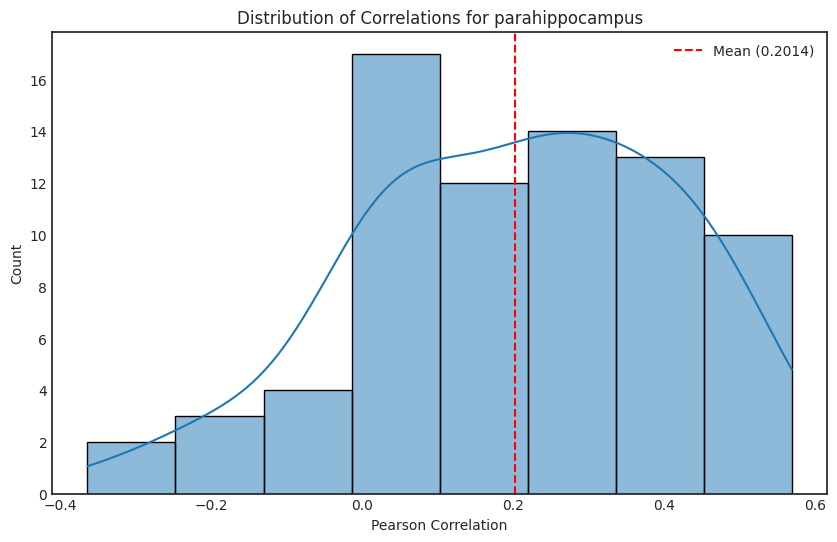

Overall correlation (APA format): r(1348) = 0.10, p = 0.0002


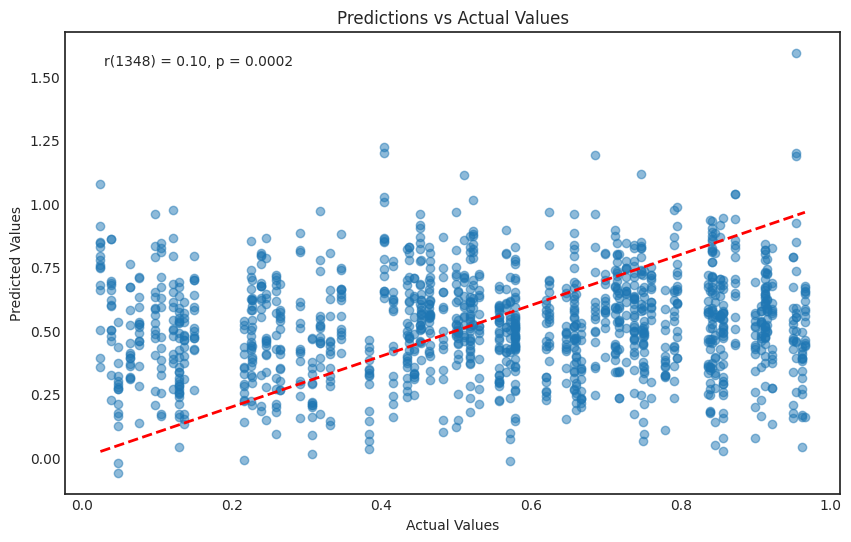

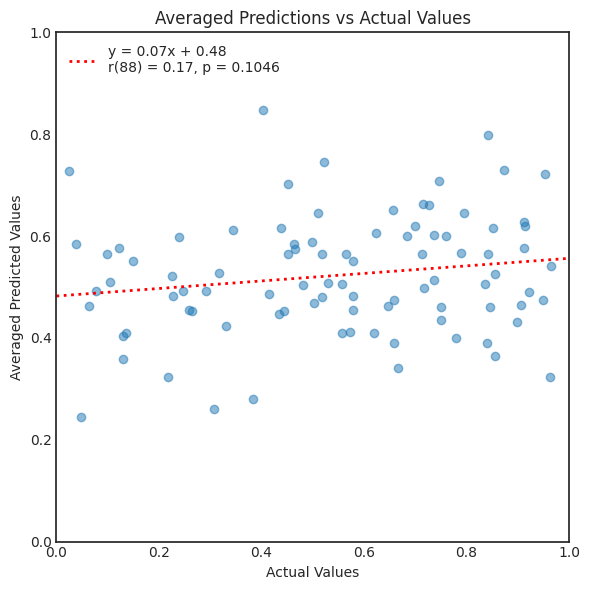

Correlation of averaged predictions (APA format): r(88) = 0.17, p = 0.1046
Regression line: y = 0.0740x + 0.4822

CREATING CSV FILE WITH ID MATCHING
Loaded target data with 90 rows
Created results DataFrame with 90 rows
Sample of results:
     ID  Actual  Prediction_1  Prediction_2  Prediction_3  Prediction_4  \
0  1064  0.0246        0.6807        0.5039        0.7488        0.3559   
1  1073  0.0389        0.6216        0.5038        0.5971        0.6001   
2  1020  0.0478        0.5349        0.3745        0.1759        0.4343   
3  1031  0.0636        0.5806        0.5213        0.6706        0.7623   
4  1044  0.0763        0.6310        0.5922        0.4888        0.7117   

   Prediction_5  Prediction_6  Prediction_7  Prediction_8  Prediction_9  \
0        1.0752        0.7772        0.8433        0.7942        0.8296   
1        0.3243        0.6587        0.5026        0.4779        0.6940   
2        0.1244        0.3017        0.2132        0.2891        0.3235   
3        0

In [50]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import glob

def extract_data(file_content):
    folds_data = []
    for fold in range(1, 6):
        pattern = rf"Fold {fold}.*?Predicted tensors for test set:\s*tensor\((.*?)\).*?Target tensorsfor test set:\s*tensor\((.*?)\)"
        match = re.search(pattern, file_content, re.DOTALL)
        if match:
            predictions = eval(f"[{match.group(1)}]")
            targets = eval(f"[{match.group(2)}]")
            folds_data.append((predictions, targets))
    return folds_data

def process_file(filename):
    with open(filename, 'r') as file:
        content = file.read()
    return extract_data(content)

def calculate_correlations(folds_data):
    correlations = []
    for predictions, targets in folds_data:
        predictions_flat = [item for sublist in predictions for item in sublist]
        targets_flat = [item for sublist in targets for item in sublist]
        if len(predictions_flat) > 1 and len(targets_flat) > 1:
            corr, _ = stats.pearsonr(predictions_flat, targets_flat)
            correlations.append(corr)
    return correlations

# Process all files
all_correlations_densenet_parahippocampus = []
all_predictions = []
all_actual = []

for filename in glob.glob('densenet_results/job_output_DenseNet_parahippocampus_*.out'):
    if 'old' not in filename.lower() and 'extra' not in filename.lower():
        folds_data = process_file(filename)
        correlations = calculate_correlations(folds_data)
        all_correlations_densenet_parahippocampus.extend(correlations)
        
        for predictions, targets in folds_data:
            all_predictions.extend([item for sublist in predictions for item in sublist])
            all_actual.extend([item for sublist in targets for item in sublist])

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_actual = np.array(all_actual)

print(f"Number of predictions: {len(all_predictions)}")
print(f"Number of actual values: {len(all_actual)}")

if len(all_predictions) == 0 or len(all_actual) == 0:
    print("No data extracted from files. Please check your input files and patterns.")
else:
    # Calculate mean and SD
    mean_correlation = np.mean(all_correlations_densenet_parahippocampus)
    std_correlation = np.std(all_correlations_densenet_parahippocampus)

    print(f"Mean correlation: {mean_correlation:.4f}")
    print(f"Standard deviation of correlation: {std_correlation:.4f}")

    # Plot distribution of correlations
    plt.figure(figsize=(10, 6))
    sns.histplot(all_correlations_densenet_parahippocampus, kde=True)
    plt.title("Distribution of Correlations for parahippocampus")
    plt.xlabel("Pearson Correlation")
    plt.axvline(mean_correlation, color='r', linestyle='--', label=f"Mean ({mean_correlation:.4f})")
    plt.legend()
    # plt.savefig('densenet_parahippocampus_correlation_distribution.svg', format='svg', bbox_inches='tight')
    plt.show()

    # Calculate correlation for all predictions
    if len(all_predictions) > 1 and len(all_actual) > 1:
        final_corr, final_p_value = stats.pearsonr(all_actual, all_predictions)
        df_final = len(all_actual) - 2  # degrees of freedom
        print(f"Overall correlation (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")

        # Create scatter plot of predictions vs actual values
        plt.figure(figsize=(10, 6))
        plt.scatter(all_actual, all_predictions, alpha=0.5)
        plt.title("Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.plot([min(all_actual), max(all_actual)], [min(all_actual), max(all_actual)], 'r--', lw=2)
        plt.text(0.05, 0.95, f'r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}', 
                 transform=plt.gca().transAxes, verticalalignment='top')
        #plt.savefig('densenet_parahippocampus_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Calculate average predictions for each unique actual value
        predictions_by_actual = {}
        for actual, pred in zip(all_actual, all_predictions):
            if actual not in predictions_by_actual:
                predictions_by_actual[actual] = []
            predictions_by_actual[actual].append(pred)

        avg_predictions = []
        unique_actual = []
        for actual, preds in sorted(predictions_by_actual.items()):
            unique_actual.append(actual)
            avg_predictions.append(np.mean(preds))

        unique_actual = np.array(unique_actual)
        avg_predictions = np.array(avg_predictions)

        # Calculate correlation for averaged predictions
        avg_corr, avg_p_value = stats.pearsonr(unique_actual, avg_predictions)
        df_avg = len(unique_actual) - 2  # degrees of freedom
        
        # Calculate the linear regression line
        slope_reg, intercept_reg, _, _, _ = stats.linregress(unique_actual, avg_predictions)
        
        # Create scatter plot of averaged predictions vs actual values
        plt.figure(figsize=(6, 6))
        plt.scatter(unique_actual, avg_predictions, alpha=0.5)

        # Plot the regression line
        x_range = np.array([0, 1])
        y_range_reg = slope_reg * x_range + intercept_reg

        plt.plot(x_range, y_range_reg, 'r:', linewidth=2, 
                 label=f'y = {slope_reg:.2f}x + {intercept_reg:.2f}\nr({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}')

        plt.title("Averaged Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Averaged Predicted Values")
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # Adjust legend position and font size
        plt.legend(loc='upper left', fontsize='medium')

        # Adjust layout to prevent cutting off the legend
        plt.tight_layout()

        plt.savefig('final_plots/densenet_parahippocampus_avg_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Print correlation and p-value in APA format
        print(f"Correlation of averaged predictions (APA format): r({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}")
        print(f"Regression line: y = {slope_reg:.4f}x + {intercept_reg:.4f}")

        # ===== NEW SECTION: Create CSV with ID matching =====
        print("\n" + "="*50)
        print("CREATING CSV FILE WITH ID MATCHING")
        print("="*50)
        
        try:
            # Load the target data to get IDs
            target_df = pd.read_csv('radiomic_results/DataAnalysisWith90Participants_Jupyter.csv')
            print(f"Loaded target data with {len(target_df)} rows")
            
            # Create initial DataFrame using existing all_actual and all_predictions
            results_df = pd.DataFrame({
                'Actual': all_actual,
                'Prediction': all_predictions
            })
            
            # Round actual values for matching
            results_df['Actual'] = results_df['Actual'].round(4)
            target_df['Model_Building_Total'] = target_df['Model_Building_Total'].round(4)
            
            # Create a mapping from actual values to IDs
            actual_to_id = dict(zip(target_df['Model_Building_Total'], target_df['ID']))
            
            # Add ID column by matching actual values
            results_df['ID'] = results_df['Actual'].map(actual_to_id)
            
            # Check for missing matches
            missing_matches = results_df['ID'].isna().sum()
            if missing_matches > 0:
                print(f"Warning: {missing_matches} actual values could not be matched with IDs")
                # Remove rows without ID matches
                results_df = results_df.dropna(subset=['ID'])
            
            # Group by ID and Actual to aggregate multiple predictions per participant
            grouped = results_df.groupby(['ID', 'Actual'])['Prediction'].apply(list).reset_index()
            
            # Create final DataFrame in the format of the first code
            final_results = []
            for _, row in grouped.iterrows():
                predictions = row['Prediction']
                record = {
                    'ID': int(row['ID']),
                    'Actual': row['Actual']
                }
                
                # Add individual predictions
                for i, pred in enumerate(predictions):
                    record[f'Prediction_{i+1}'] = round(pred, 4)
                
                # Add average prediction
                record['Average_Prediction'] = round(np.mean(predictions), 4)
                
                final_results.append(record)
            
            # Create final DataFrame
            results_df = pd.DataFrame(final_results)
            
            # Sort by actual values
            results_df = results_df.sort_values('Actual').reset_index(drop=True)
            
            # Reorder columns to match the first script's format
            prediction_cols = [col for col in results_df.columns if col.startswith('Prediction_')]
            column_order = ['ID', 'Actual'] + sorted(prediction_cols, key=lambda x: int(x.split('_')[1])) + ['Average_Prediction']
            results_df = results_df[column_order]
            
            print(f"Created results DataFrame with {len(results_df)} rows")
            print("Sample of results:")
            print(results_df.head())
            
            # Save to CSV
            output_filename = 'densenet_parahippocampus_predictions_with_average_and_id.csv'
            results_df.to_csv(output_filename, index=False)
            print(f"\nResults saved to '{output_filename}'")
            print(f"File contains {len(results_df)} rows and {len(results_df.columns)} columns")
            
        except FileNotFoundError:
            print("Error: Could not find 'radiomic_results/DataAnalysisWith90Participants_Jupyter.csv'")
            print("Please ensure the file exists in the correct location.")
        except Exception as e:
            print(f"Error creating CSV file: {str(e)}")
            import traceback
            traceback.print_exc()
        
        # ===== END NEW SECTION =====
        
    else:
        print("Not enough data to calculate correlations or create plots.")

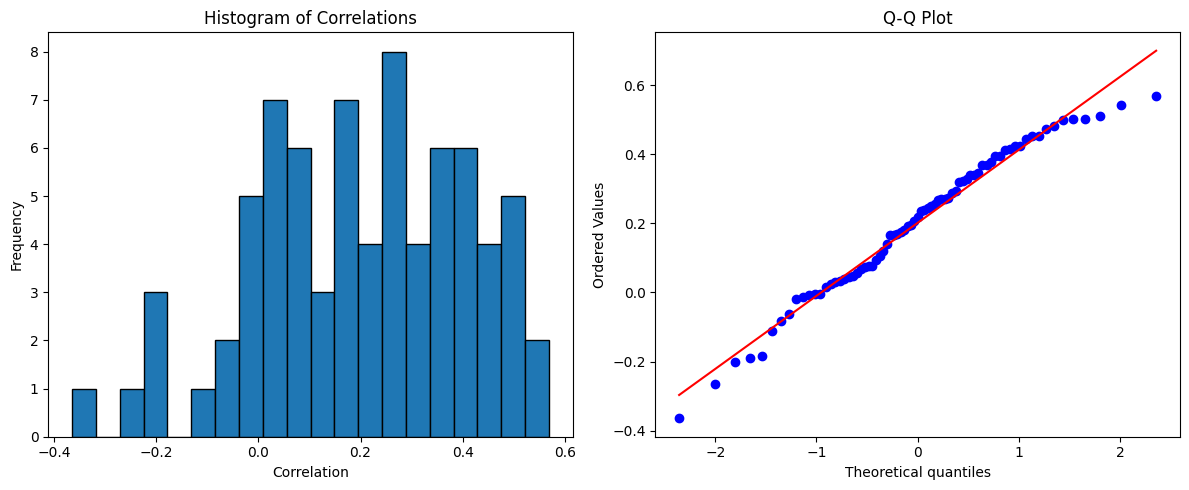


--- APA Style Results ---
Descriptive Statistics:
M = 0.20, SD = 0.21, 95% CI [0.15, 0.25]
N = 75

Normality Assessment:
Shapiro-Wilk test: W(74) = 0.976, p = 0.160

Inference Statistics:
One-sample t-test: t(74) = 8.32, p < .001, d = 0.96
Wilcoxon signed-rank test: W = 263.0, p < .001

APA Formatted Results Section:
The correlation coefficients (M = 0.20, SD = 0.21) were significantly different from zero, t(74) = 8.32, p < .001, d = 0.96, 95% CI [0.15, 0.25].


In [10]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Use the correct variable name from your code
all_correlations = all_correlations_densenet_parahippocampus  # CHANGED: thalamus -> parahippocampus

# Number of values in all_correlations
num_correlations = len(all_correlations)

# Descriptive statistics
mean_correlation = np.mean(all_correlations)
std_correlation = np.std(all_correlations, ddof=1)  # Using N-1 for sample std dev

# Wilcoxon signed-rank test
wilcoxon_statistic, wilcoxon_p_value = stats.wilcoxon(all_correlations)

# One-sample t-test
t_statistic, t_p_value = stats.ttest_1samp(all_correlations, 0)

# Calculate Cohen's d for one-sample t-test
cohens_d = mean_correlation / std_correlation  # For one-sample t-test comparing to zero

# Calculate 95% confidence interval
degrees_freedom = num_correlations - 1
ci_95 = stats.t.interval(0.95, degrees_freedom, loc=mean_correlation, 
                         scale=std_correlation/np.sqrt(num_correlations))

# Check normality using Shapiro-Wilk test
shapiro_statistic, shapiro_p_value = stats.shapiro(all_correlations)

# Create Q-Q plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
ax1.hist(all_correlations, bins=20, edgecolor='black')
ax1.set_title('Histogram of Correlations')
ax1.set_xlabel('Correlation')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(all_correlations, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot")

plt.tight_layout()
plt.show()

# Format p-values according to APA
def format_p_value(p):
    if p < 0.001:
        return "p < .001"
    else:
        return f"p = {p:.3f}"

# Print statistical results in APA format
print("\n--- APA Style Results ---")
print("Descriptive Statistics:")
print(f"M = {mean_correlation:.2f}, SD = {std_correlation:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
print(f"N = {num_correlations}")

print("\nNormality Assessment:")
print(f"Shapiro-Wilk test: W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}")

print("\nInference Statistics:")
print(f"One-sample t-test: t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}")
print(f"Wilcoxon signed-rank test: W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}")

# APA formatted result (ready for copy-paste)
print("\nAPA Formatted Results Section:")
if shapiro_p_value >= 0.05:
    print(f"The correlation coefficients (M = {mean_correlation:.2f}, SD = {std_correlation:.2f}) were {'not ' if t_p_value >= 0.05 else ''}significantly different from zero, t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}].")
else:
    print(f"Due to the non-normal distribution of correlation coefficients (Shapiro-Wilk W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}), a Wilcoxon signed-rank test was conducted. The correlations (Mdn = {np.median(all_correlations):.2f}) were {'not ' if wilcoxon_p_value >= 0.05 else ''}significantly different from zero, W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}. For completeness, a t-test yielded t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}.")

## Densenet entorhinal

Number of predictions: 1350
Number of actual values: 1350
Mean correlation: -0.0005
Standard deviation of correlation: 0.1860


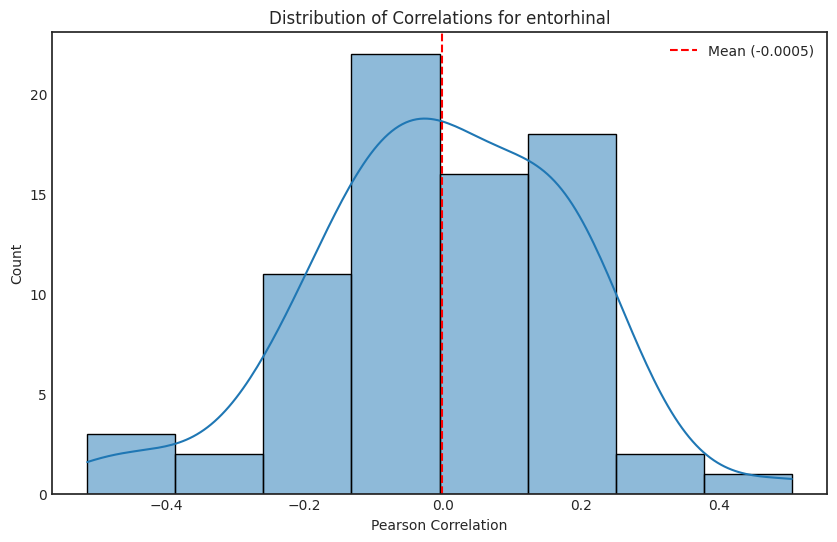

Overall correlation (APA format): r(1348) = -0.03, p = 0.2197


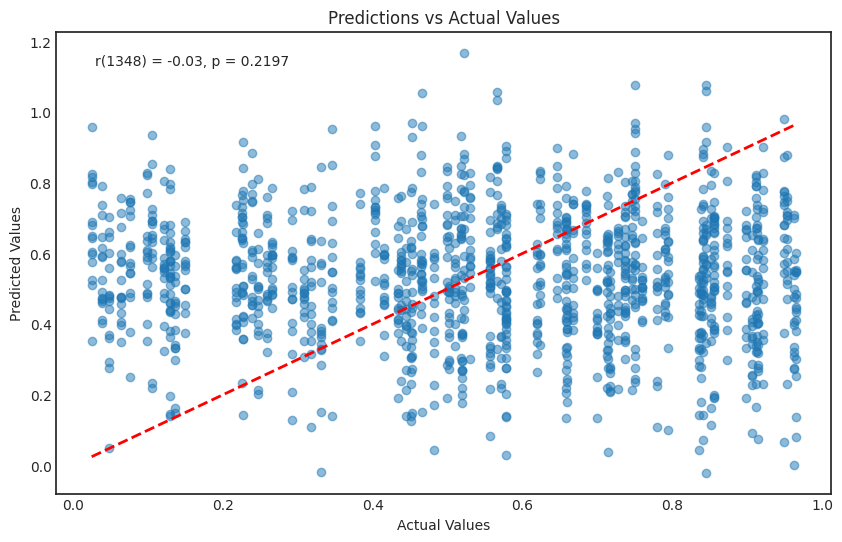

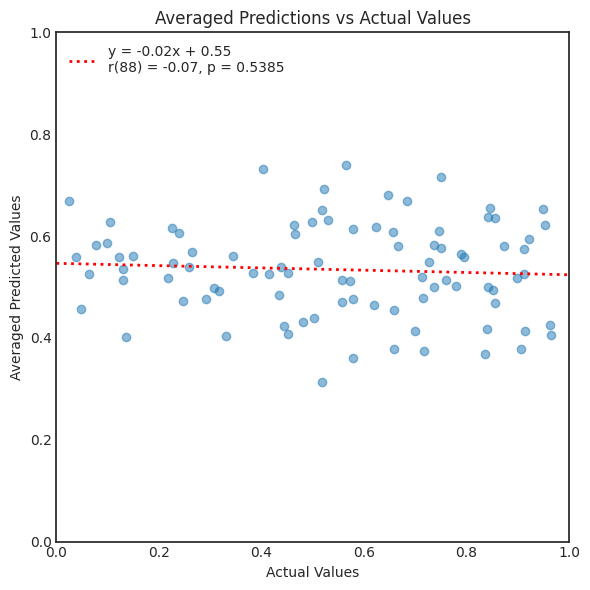

Correlation of averaged predictions (APA format): r(88) = -0.07, p = 0.5385
Regression line: y = -0.0224x + 0.5464

CREATING CSV FILE WITH ID MATCHING
Loaded target data with 90 rows
Created results DataFrame with 90 rows
Sample of results:
     ID  Actual  Prediction_1  Prediction_2  Prediction_3  Prediction_4  \
0  1064  0.0246        0.8019        0.7975        0.6045        0.5118   
1  1073  0.0389        0.5932        0.4647        0.4105        0.7897   
2  1020  0.0478        0.0498        0.5580        0.6461        0.4787   
3  1031  0.0636        0.3488        0.4774        0.5757        0.7582   
4  1044  0.0763        0.2506        0.7068        0.7241        0.6192   

   Prediction_5  Prediction_6  Prediction_7  Prediction_8  Prediction_9  \
0        0.3529        0.8250        0.6803        0.5758        0.5247   
1        0.4035        0.7365        0.7083        0.6150        0.6475   
2        0.2930        0.6608        0.4823        0.3604        0.4641   
3       

In [51]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import glob

def extract_data(file_content):
    folds_data = []
    for fold in range(1, 6):
        pattern = rf"Fold {fold}.*?Predicted tensors for test set:\s*tensor\((.*?)\).*?Target tensorsfor test set:\s*tensor\((.*?)\)"
        match = re.search(pattern, file_content, re.DOTALL)
        if match:
            predictions = eval(f"[{match.group(1)}]")
            targets = eval(f"[{match.group(2)}]")
            folds_data.append((predictions, targets))
    return folds_data

def process_file(filename):
    with open(filename, 'r') as file:
        content = file.read()
    return extract_data(content)

def calculate_correlations(folds_data):
    correlations = []
    for predictions, targets in folds_data:
        predictions_flat = [item for sublist in predictions for item in sublist]
        targets_flat = [item for sublist in targets for item in sublist]
        if len(predictions_flat) > 1 and len(targets_flat) > 1:
            corr, _ = stats.pearsonr(predictions_flat, targets_flat)
            correlations.append(corr)
    return correlations

# Process all files
all_correlations_densenet_entorhinal = []
all_predictions = []
all_actual = []

for filename in glob.glob('densenet_results/job_output_DenseNet_entorhinal_*.out'):
    if 'old' not in filename.lower() and 'extra' not in filename.lower():
        folds_data = process_file(filename)
        correlations = calculate_correlations(folds_data)
        all_correlations_densenet_entorhinal.extend(correlations)
        
        for predictions, targets in folds_data:
            all_predictions.extend([item for sublist in predictions for item in sublist])
            all_actual.extend([item for sublist in targets for item in sublist])

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_actual = np.array(all_actual)

print(f"Number of predictions: {len(all_predictions)}")
print(f"Number of actual values: {len(all_actual)}")

if len(all_predictions) == 0 or len(all_actual) == 0:
    print("No data extracted from files. Please check your input files and patterns.")
else:
    # Calculate mean and SD
    mean_correlation = np.mean(all_correlations_densenet_entorhinal)
    std_correlation = np.std(all_correlations_densenet_entorhinal)

    print(f"Mean correlation: {mean_correlation:.4f}")
    print(f"Standard deviation of correlation: {std_correlation:.4f}")

    # Plot distribution of correlations
    plt.figure(figsize=(10, 6))
    sns.histplot(all_correlations_densenet_entorhinal, kde=True)
    plt.title("Distribution of Correlations for entorhinal")
    plt.xlabel("Pearson Correlation")
    plt.axvline(mean_correlation, color='r', linestyle='--', label=f"Mean ({mean_correlation:.4f})")
    plt.legend()
    # plt.savefig('densenet_entorhinal_correlation_distribution.svg', format='svg', bbox_inches='tight')
    plt.show()

    # Calculate correlation for all predictions
    if len(all_predictions) > 1 and len(all_actual) > 1:
        final_corr, final_p_value = stats.pearsonr(all_actual, all_predictions)
        df_final = len(all_actual) - 2  # degrees of freedom
        print(f"Overall correlation (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")

        # Create scatter plot of predictions vs actual values
        plt.figure(figsize=(10, 6))
        plt.scatter(all_actual, all_predictions, alpha=0.5)
        plt.title("Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.plot([min(all_actual), max(all_actual)], [min(all_actual), max(all_actual)], 'r--', lw=2)
        plt.text(0.05, 0.95, f'r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}', 
                 transform=plt.gca().transAxes, verticalalignment='top')
        #plt.savefig('densenet_entorhinal_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Calculate average predictions for each unique actual value
        predictions_by_actual = {}
        for actual, pred in zip(all_actual, all_predictions):
            if actual not in predictions_by_actual:
                predictions_by_actual[actual] = []
            predictions_by_actual[actual].append(pred)

        avg_predictions = []
        unique_actual = []
        for actual, preds in sorted(predictions_by_actual.items()):
            unique_actual.append(actual)
            avg_predictions.append(np.mean(preds))

        unique_actual = np.array(unique_actual)
        avg_predictions = np.array(avg_predictions)

        # Calculate correlation for averaged predictions
        avg_corr, avg_p_value = stats.pearsonr(unique_actual, avg_predictions)
        df_avg = len(unique_actual) - 2  # degrees of freedom
        
        # Calculate the linear regression line
        slope_reg, intercept_reg, _, _, _ = stats.linregress(unique_actual, avg_predictions)
        
        # Create scatter plot of averaged predictions vs actual values
        plt.figure(figsize=(6, 6))
        plt.scatter(unique_actual, avg_predictions, alpha=0.5)

        # Plot the regression line
        x_range = np.array([0, 1])
        y_range_reg = slope_reg * x_range + intercept_reg

        plt.plot(x_range, y_range_reg, 'r:', linewidth=2, 
                 label=f'y = {slope_reg:.2f}x + {intercept_reg:.2f}\nr({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}')

        plt.title("Averaged Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Averaged Predicted Values")
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # Adjust legend position and font size
        plt.legend(loc='upper left', fontsize='medium')

        # Adjust layout to prevent cutting off the legend
        plt.tight_layout()

        plt.savefig('final_plots/densenet_entorhinal_avg_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Print correlation and p-value in APA format
        print(f"Correlation of averaged predictions (APA format): r({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}")
        print(f"Regression line: y = {slope_reg:.4f}x + {intercept_reg:.4f}")

        # ===== NEW SECTION: Create CSV with ID matching =====
        print("\n" + "="*50)
        print("CREATING CSV FILE WITH ID MATCHING")
        print("="*50)
        
        try:
            # Load the target data to get IDs
            target_df = pd.read_csv('radiomic_results/DataAnalysisWith90Participants_Jupyter.csv')
            print(f"Loaded target data with {len(target_df)} rows")
            
            # Create initial DataFrame using existing all_actual and all_predictions
            results_df = pd.DataFrame({
                'Actual': all_actual,
                'Prediction': all_predictions
            })
            
            # Round actual values for matching
            results_df['Actual'] = results_df['Actual'].round(4)
            target_df['Model_Building_Total'] = target_df['Model_Building_Total'].round(4)
            
            # Create a mapping from actual values to IDs
            actual_to_id = dict(zip(target_df['Model_Building_Total'], target_df['ID']))
            
            # Add ID column by matching actual values
            results_df['ID'] = results_df['Actual'].map(actual_to_id)
            
            # Check for missing matches
            missing_matches = results_df['ID'].isna().sum()
            if missing_matches > 0:
                print(f"Warning: {missing_matches} actual values could not be matched with IDs")
                # Remove rows without ID matches
                results_df = results_df.dropna(subset=['ID'])
            
            # Group by ID and Actual to aggregate multiple predictions per participant
            grouped = results_df.groupby(['ID', 'Actual'])['Prediction'].apply(list).reset_index()
            
            # Create final DataFrame in the format of the first code
            final_results = []
            for _, row in grouped.iterrows():
                predictions = row['Prediction']
                record = {
                    'ID': int(row['ID']),
                    'Actual': row['Actual']
                }
                
                # Add individual predictions
                for i, pred in enumerate(predictions):
                    record[f'Prediction_{i+1}'] = round(pred, 4)
                
                # Add average prediction
                record['Average_Prediction'] = round(np.mean(predictions), 4)
                
                final_results.append(record)
            
            # Create final DataFrame
            results_df = pd.DataFrame(final_results)
            
            # Sort by actual values
            results_df = results_df.sort_values('Actual').reset_index(drop=True)
            
            # Reorder columns to match the first script's format
            prediction_cols = [col for col in results_df.columns if col.startswith('Prediction_')]
            column_order = ['ID', 'Actual'] + sorted(prediction_cols, key=lambda x: int(x.split('_')[1])) + ['Average_Prediction']
            results_df = results_df[column_order]
            
            print(f"Created results DataFrame with {len(results_df)} rows")
            print("Sample of results:")
            print(results_df.head())
            
            # Save to CSV
            output_filename = 'densenet_entorhinal_predictions_with_average_and_id.csv'
            results_df.to_csv(output_filename, index=False)
            print(f"\nResults saved to '{output_filename}'")
            print(f"File contains {len(results_df)} rows and {len(results_df.columns)} columns")
            
        except FileNotFoundError:
            print("Error: Could not find 'radiomic_results/DataAnalysisWith90Participants_Jupyter.csv'")
            print("Please ensure the file exists in the correct location.")
        except Exception as e:
            print(f"Error creating CSV file: {str(e)}")
            import traceback
            traceback.print_exc()
        
        # ===== END NEW SECTION =====
        
    else:
        print("Not enough data to calculate correlations or create plots.")

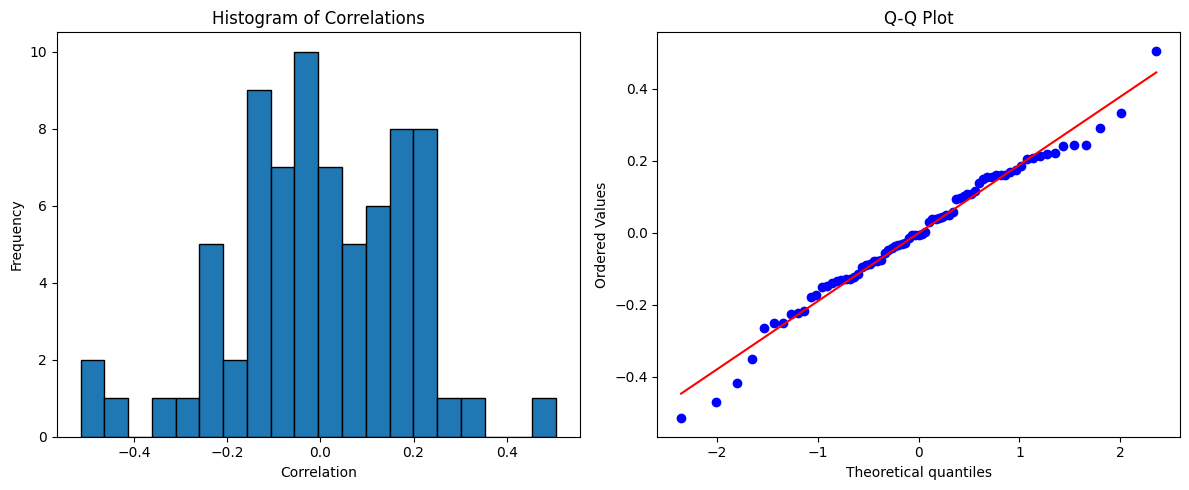


--- APA Style Results ---
Descriptive Statistics:
M = -0.00, SD = 0.19, 95% CI [-0.04, 0.04]
N = 75

Normality Assessment:
Shapiro-Wilk test: W(74) = 0.984, p = 0.488

Inference Statistics:
One-sample t-test: t(74) = -0.02, p = 0.983, d = -0.00
Wilcoxon signed-rank test: W = 1377.0, p = 0.800

APA Formatted Results Section:
The correlation coefficients (M = -0.00, SD = 0.19) were not significantly different from zero, t(74) = -0.02, p = 0.983, d = -0.00, 95% CI [-0.04, 0.04].


In [12]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Use the correct variable name from your code
all_correlations = all_correlations_densenet_entorhinal  # CHANGED: thalamus -> entorhinal

# Number of values in all_correlations
num_correlations = len(all_correlations)

# Descriptive statistics
mean_correlation = np.mean(all_correlations)
std_correlation = np.std(all_correlations, ddof=1)  # Using N-1 for sample std dev

# Wilcoxon signed-rank test
wilcoxon_statistic, wilcoxon_p_value = stats.wilcoxon(all_correlations)

# One-sample t-test
t_statistic, t_p_value = stats.ttest_1samp(all_correlations, 0)

# Calculate Cohen's d for one-sample t-test
cohens_d = mean_correlation / std_correlation  # For one-sample t-test comparing to zero

# Calculate 95% confidence interval
degrees_freedom = num_correlations - 1
ci_95 = stats.t.interval(0.95, degrees_freedom, loc=mean_correlation, 
                         scale=std_correlation/np.sqrt(num_correlations))

# Check normality using Shapiro-Wilk test
shapiro_statistic, shapiro_p_value = stats.shapiro(all_correlations)

# Create Q-Q plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
ax1.hist(all_correlations, bins=20, edgecolor='black')
ax1.set_title('Histogram of Correlations')
ax1.set_xlabel('Correlation')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(all_correlations, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot")

plt.tight_layout()
plt.show()

# Format p-values according to APA
def format_p_value(p):
    if p < 0.001:
        return "p < .001"
    else:
        return f"p = {p:.3f}"

# Print statistical results in APA format
print("\n--- APA Style Results ---")
print("Descriptive Statistics:")
print(f"M = {mean_correlation:.2f}, SD = {std_correlation:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
print(f"N = {num_correlations}")

print("\nNormality Assessment:")
print(f"Shapiro-Wilk test: W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}")

print("\nInference Statistics:")
print(f"One-sample t-test: t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}")
print(f"Wilcoxon signed-rank test: W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}")

# APA formatted result (ready for copy-paste)
print("\nAPA Formatted Results Section:")
if shapiro_p_value >= 0.05:
    print(f"The correlation coefficients (M = {mean_correlation:.2f}, SD = {std_correlation:.2f}) were {'not ' if t_p_value >= 0.05 else ''}significantly different from zero, t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}].")
else:
    print(f"Due to the non-normal distribution of correlation coefficients (Shapiro-Wilk W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}), a Wilcoxon signed-rank test was conducted. The correlations (Mdn = {np.median(all_correlations):.2f}) were {'not ' if wilcoxon_p_value >= 0.05 else ''}significantly different from zero, W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}. For completeness, a t-test yielded t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}.")

# Densenet whole brain

Number of predictions: 1350
Number of actual values: 1350
Mean correlation: 0.0671
Standard deviation of correlation: 0.2047


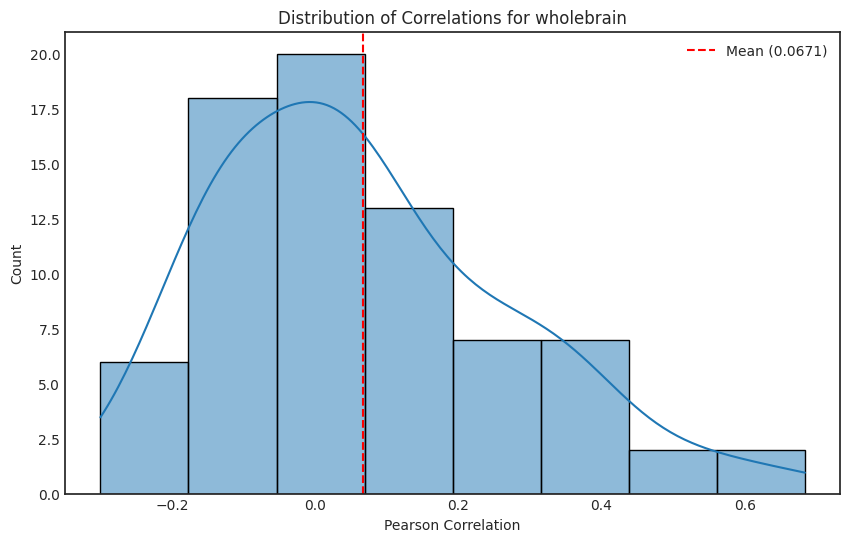

Overall correlation (APA format): r(1348) = 0.06, p = 0.0346


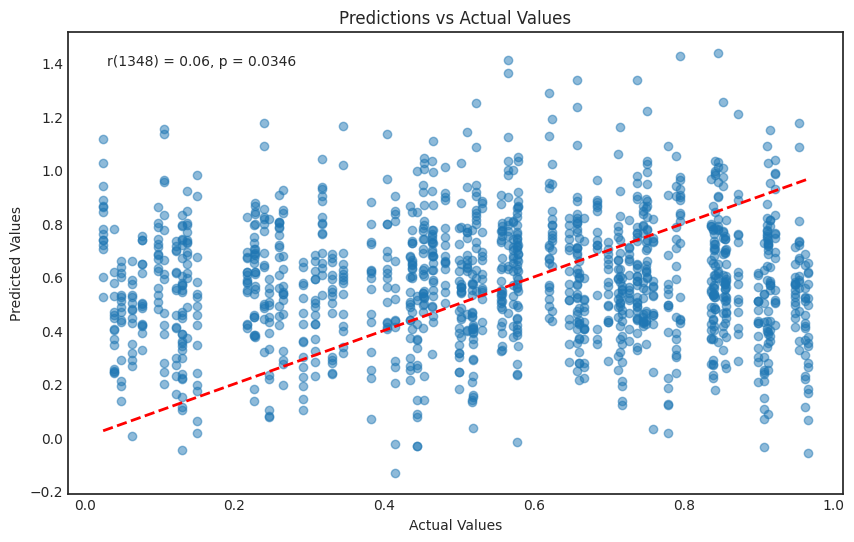

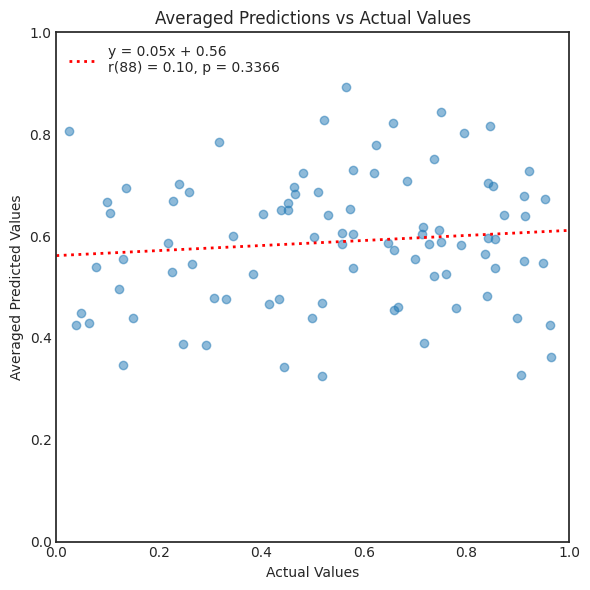

Correlation of averaged predictions (APA format): r(88) = 0.10, p = 0.3366
Regression line: y = 0.0495x + 0.5616

CREATING CSV FILE WITH ID MATCHING
Loaded target data with 90 rows
Created results DataFrame with 90 rows
Sample of results:
     ID  Actual  Prediction_1  Prediction_2  Prediction_3  Prediction_4  \
0  1064  0.0246        1.0254        0.7205        0.7610        0.5998   
1  1073  0.0389        0.7809        0.6200        0.5277        0.5781   
2  1020  0.0478        0.6139        0.4866        0.5333        0.4400   
3  1031  0.0636        0.5717        0.2897        0.4752        0.6594   
4  1044  0.0763        0.6488        0.6488        0.7536        0.7366   

   Prediction_5  Prediction_6  Prediction_7  Prediction_8  Prediction_9  \
0        0.8596        0.8859        0.7042        0.5237        1.1165   
1        0.3438        0.4702        0.2573        0.2475        0.4569   
2        0.1345        0.5101        0.2889        0.1924        0.5991   
3        0

In [52]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import glob

def extract_data(file_content):
    folds_data = []
    for fold in range(1, 6):
        pattern = rf"Fold {fold}.*?Predicted tensors for test set:\s*tensor\((.*?)\).*?Target tensorsfor test set:\s*tensor\((.*?)\)"
        match = re.search(pattern, file_content, re.DOTALL)
        if match:
            predictions = eval(f"[{match.group(1)}]")
            targets = eval(f"[{match.group(2)}]")
            folds_data.append((predictions, targets))
    return folds_data

def process_file(filename):
    with open(filename, 'r') as file:
        content = file.read()
    return extract_data(content)

def calculate_correlations(folds_data):
    correlations = []
    for predictions, targets in folds_data:
        predictions_flat = [item for sublist in predictions for item in sublist]
        targets_flat = [item for sublist in targets for item in sublist]
        if len(predictions_flat) > 1 and len(targets_flat) > 1:
            corr, _ = stats.pearsonr(predictions_flat, targets_flat)
            correlations.append(corr)
    return correlations

# Process all files
all_correlations_densenet_wholebrain = []
all_predictions = []
all_actual = []

for filename in glob.glob('densenet_results/job_output_DenseNet_wholebrain_*.out'):
    if 'old' not in filename.lower() and 'extra' not in filename.lower():
        folds_data = process_file(filename)
        correlations = calculate_correlations(folds_data)
        all_correlations_densenet_wholebrain.extend(correlations)
        
        for predictions, targets in folds_data:
            all_predictions.extend([item for sublist in predictions for item in sublist])
            all_actual.extend([item for sublist in targets for item in sublist])

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_actual = np.array(all_actual)

print(f"Number of predictions: {len(all_predictions)}")
print(f"Number of actual values: {len(all_actual)}")

if len(all_predictions) == 0 or len(all_actual) == 0:
    print("No data extracted from files. Please check your input files and patterns.")
else:
    # Calculate mean and SD
    mean_correlation = np.mean(all_correlations_densenet_wholebrain)
    std_correlation = np.std(all_correlations_densenet_wholebrain)

    print(f"Mean correlation: {mean_correlation:.4f}")
    print(f"Standard deviation of correlation: {std_correlation:.4f}")

    # Plot distribution of correlations
    plt.figure(figsize=(10, 6))
    sns.histplot(all_correlations_densenet_wholebrain, kde=True)
    plt.title("Distribution of Correlations for wholebrain")
    plt.xlabel("Pearson Correlation")
    plt.axvline(mean_correlation, color='r', linestyle='--', label=f"Mean ({mean_correlation:.4f})")
    plt.legend()
    # plt.savefig('densenet_wholebrain_correlation_distribution.svg', format='svg', bbox_inches='tight')
    plt.show()

    # Calculate correlation for all predictions
    if len(all_predictions) > 1 and len(all_actual) > 1:
        final_corr, final_p_value = stats.pearsonr(all_actual, all_predictions)
        df_final = len(all_actual) - 2  # degrees of freedom
        print(f"Overall correlation (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")

        # Create scatter plot of predictions vs actual values
        plt.figure(figsize=(10, 6))
        plt.scatter(all_actual, all_predictions, alpha=0.5)
        plt.title("Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.plot([min(all_actual), max(all_actual)], [min(all_actual), max(all_actual)], 'r--', lw=2)
        plt.text(0.05, 0.95, f'r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}', 
                 transform=plt.gca().transAxes, verticalalignment='top')
        #plt.savefig('densenet_wholebrain_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Calculate average predictions for each unique actual value
        predictions_by_actual = {}
        for actual, pred in zip(all_actual, all_predictions):
            if actual not in predictions_by_actual:
                predictions_by_actual[actual] = []
            predictions_by_actual[actual].append(pred)

        avg_predictions = []
        unique_actual = []
        for actual, preds in sorted(predictions_by_actual.items()):
            unique_actual.append(actual)
            avg_predictions.append(np.mean(preds))

        unique_actual = np.array(unique_actual)
        avg_predictions = np.array(avg_predictions)

        # Calculate correlation for averaged predictions
        avg_corr, avg_p_value = stats.pearsonr(unique_actual, avg_predictions)
        df_avg = len(unique_actual) - 2  # degrees of freedom
        
        # Calculate the linear regression line
        slope_reg, intercept_reg, _, _, _ = stats.linregress(unique_actual, avg_predictions)
        
        # Create scatter plot of averaged predictions vs actual values
        plt.figure(figsize=(6, 6))
        plt.scatter(unique_actual, avg_predictions, alpha=0.5)

        # Plot the regression line
        x_range = np.array([0, 1])
        y_range_reg = slope_reg * x_range + intercept_reg

        plt.plot(x_range, y_range_reg, 'r:', linewidth=2, 
                 label=f'y = {slope_reg:.2f}x + {intercept_reg:.2f}\nr({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}')

        plt.title("Averaged Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Averaged Predicted Values")
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # Adjust legend position and font size
        plt.legend(loc='upper left', fontsize='medium')

        # Adjust layout to prevent cutting off the legend
        plt.tight_layout()

        plt.savefig('final_plots/densenet_wholebrain_avg_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Print correlation and p-value in APA format
        print(f"Correlation of averaged predictions (APA format): r({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}")
        print(f"Regression line: y = {slope_reg:.4f}x + {intercept_reg:.4f}")

        # ===== NEW SECTION: Create CSV with ID matching =====
        print("\n" + "="*50)
        print("CREATING CSV FILE WITH ID MATCHING")
        print("="*50)
        
        try:
            # Load the target data to get IDs
            target_df = pd.read_csv('radiomic_results/DataAnalysisWith90Participants_Jupyter.csv')
            print(f"Loaded target data with {len(target_df)} rows")
            
            # Create initial DataFrame using existing all_actual and all_predictions
            results_df = pd.DataFrame({
                'Actual': all_actual,
                'Prediction': all_predictions
            })
            
            # Round actual values for matching
            results_df['Actual'] = results_df['Actual'].round(4)
            target_df['Model_Building_Total'] = target_df['Model_Building_Total'].round(4)
            
            # Create a mapping from actual values to IDs
            actual_to_id = dict(zip(target_df['Model_Building_Total'], target_df['ID']))
            
            # Add ID column by matching actual values
            results_df['ID'] = results_df['Actual'].map(actual_to_id)
            
            # Check for missing matches
            missing_matches = results_df['ID'].isna().sum()
            if missing_matches > 0:
                print(f"Warning: {missing_matches} actual values could not be matched with IDs")
                # Remove rows without ID matches
                results_df = results_df.dropna(subset=['ID'])
            
            # Group by ID and Actual to aggregate multiple predictions per participant
            grouped = results_df.groupby(['ID', 'Actual'])['Prediction'].apply(list).reset_index()
            
            # Create final DataFrame in the format of the first code
            final_results = []
            for _, row in grouped.iterrows():
                predictions = row['Prediction']
                record = {
                    'ID': int(row['ID']),
                    'Actual': row['Actual']
                }
                
                # Add individual predictions
                for i, pred in enumerate(predictions):
                    record[f'Prediction_{i+1}'] = round(pred, 4)
                
                # Add average prediction
                record['Average_Prediction'] = round(np.mean(predictions), 4)
                
                final_results.append(record)
            
            # Create final DataFrame
            results_df = pd.DataFrame(final_results)
            
            # Sort by actual values
            results_df = results_df.sort_values('Actual').reset_index(drop=True)
            
            # Reorder columns to match the first script's format
            prediction_cols = [col for col in results_df.columns if col.startswith('Prediction_')]
            column_order = ['ID', 'Actual'] + sorted(prediction_cols, key=lambda x: int(x.split('_')[1])) + ['Average_Prediction']
            results_df = results_df[column_order]
            
            print(f"Created results DataFrame with {len(results_df)} rows")
            print("Sample of results:")
            print(results_df.head())
            
            # Save to CSV
            output_filename = 'densenet_wholebrain_predictions_with_average_and_id.csv'
            results_df.to_csv(output_filename, index=False)
            print(f"\nResults saved to '{output_filename}'")
            print(f"File contains {len(results_df)} rows and {len(results_df.columns)} columns")
            
        except FileNotFoundError:
            print("Error: Could not find 'radiomic_results/DataAnalysisWith90Participants_Jupyter.csv'")
            print("Please ensure the file exists in the correct location.")
        except Exception as e:
            print(f"Error creating CSV file: {str(e)}")
            import traceback
            traceback.print_exc()
        
        # ===== END NEW SECTION =====
        
    else:
        print("Not enough data to calculate correlations or create plots.")

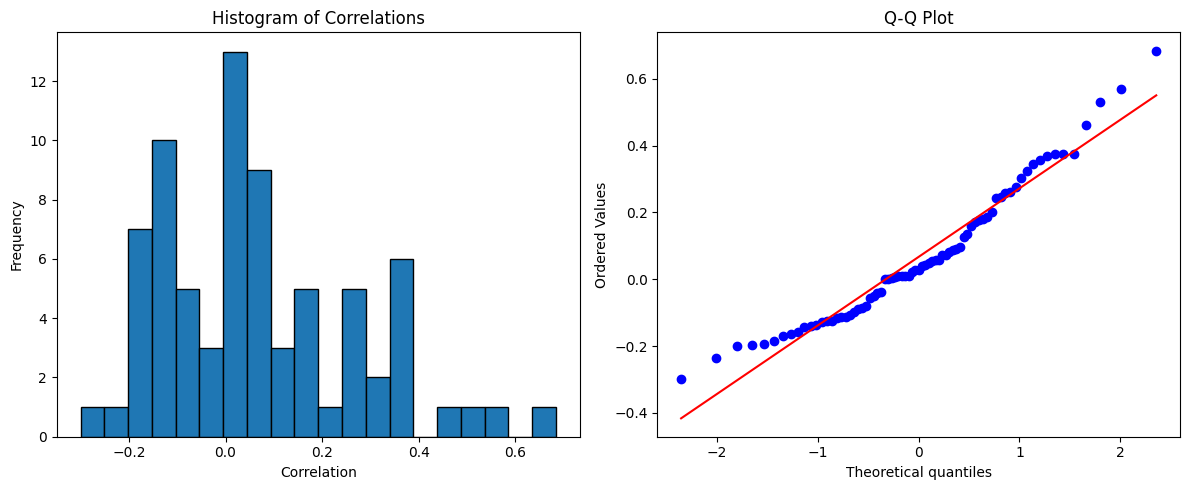


--- APA Style Results ---
Descriptive Statistics:
M = 0.07, SD = 0.21, 95% CI [0.02, 0.11]
N = 75

Normality Assessment:
Shapiro-Wilk test: W(74) = 0.953, p = 0.007

Inference Statistics:
One-sample t-test: t(74) = 2.82, p = 0.006, d = 0.33
Wilcoxon signed-rank test: W = 1014.0, p = 0.030

APA Formatted Results Section:
Due to the non-normal distribution of correlation coefficients (Shapiro-Wilk W(74) = 0.953, p = 0.007), a Wilcoxon signed-rank test was conducted. The correlations (Mdn = 0.03) were significantly different from zero, W = 1014.0, p = 0.030. For completeness, a t-test yielded t(74) = 2.82, p = 0.006, d = 0.33.


In [14]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Use the correct variable name from your code
all_correlations = all_correlations_densenet_wholebrain

# Number of values in all_correlations
num_correlations = len(all_correlations)

# Descriptive statistics
mean_correlation = np.mean(all_correlations)
std_correlation = np.std(all_correlations, ddof=1)  # Using N-1 for sample std dev

# Wilcoxon signed-rank test
wilcoxon_statistic, wilcoxon_p_value = stats.wilcoxon(all_correlations)

# One-sample t-test
t_statistic, t_p_value = stats.ttest_1samp(all_correlations, 0)

# Calculate Cohen's d for one-sample t-test
cohens_d = mean_correlation / std_correlation  # For one-sample t-test comparing to zero

# Calculate 95% confidence interval
degrees_freedom = num_correlations - 1
ci_95 = stats.t.interval(0.95, degrees_freedom, loc=mean_correlation, 
                         scale=std_correlation/np.sqrt(num_correlations))

# Check normality using Shapiro-Wilk test
shapiro_statistic, shapiro_p_value = stats.shapiro(all_correlations)

# Create Q-Q plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
ax1.hist(all_correlations, bins=20, edgecolor='black')
ax1.set_title('Histogram of Correlations')
ax1.set_xlabel('Correlation')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(all_correlations, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot")
plt.tight_layout()
plt.show()

# Format p-values according to APA
def format_p_value(p):
    if p < 0.001:
        return "p < .001"
    else:
        return f"p = {p:.3f}"

# Print statistical results in APA format
print("\n--- APA Style Results ---")
print("Descriptive Statistics:")
print(f"M = {mean_correlation:.2f}, SD = {std_correlation:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
print(f"N = {num_correlations}")

print("\nNormality Assessment:")
print(f"Shapiro-Wilk test: W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}")

print("\nInference Statistics:")
print(f"One-sample t-test: t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}")
print(f"Wilcoxon signed-rank test: W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}")

# APA formatted result (ready for copy-paste)
print("\nAPA Formatted Results Section:")
if shapiro_p_value >= 0.05:
    print(f"The correlation coefficients (M = {mean_correlation:.2f}, SD = {std_correlation:.2f}) were {'not ' if t_p_value >= 0.05 else ''}significantly different from zero, t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}].")
else:
    print(f"Due to the non-normal distribution of correlation coefficients (Shapiro-Wilk W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}), a Wilcoxon signed-rank test was conducted. The correlations (Mdn = {np.median(all_correlations):.2f}) were {'not ' if wilcoxon_p_value >= 0.05 else ''}significantly different from zero, W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}. For completeness, a t-test yielded t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}.")

# Pointnet hippocampus

Number of predictions: 1350
Number of actual values: 1350
Mean correlation: 0.0539
Standard deviation of correlation: 0.2403


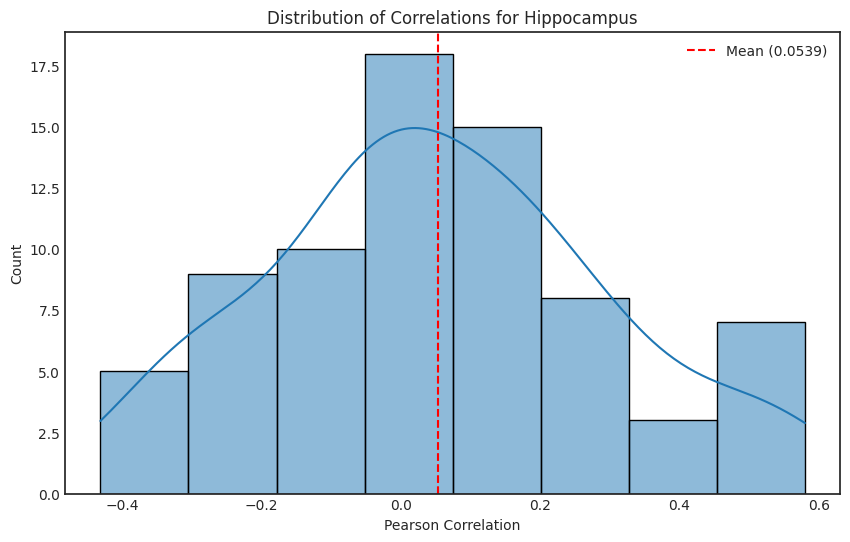

Overall correlation (APA format): r(1348) = 0.00, p = 0.9537


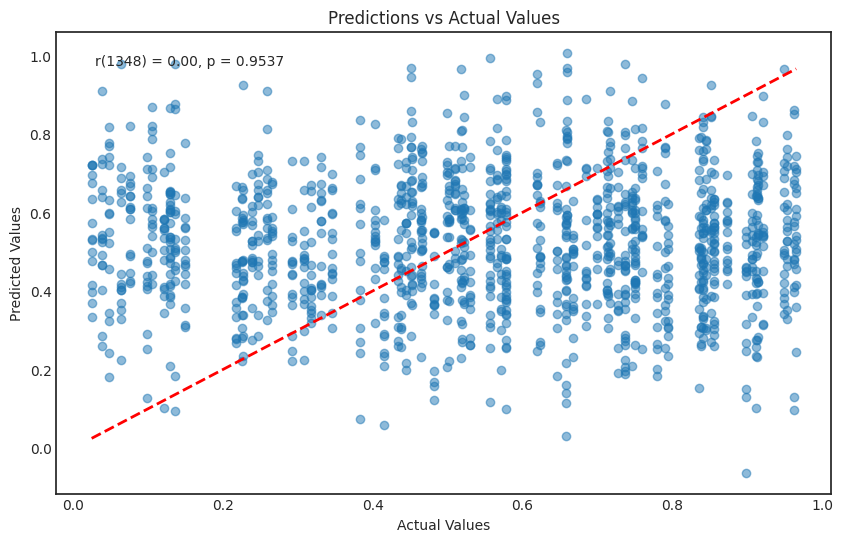

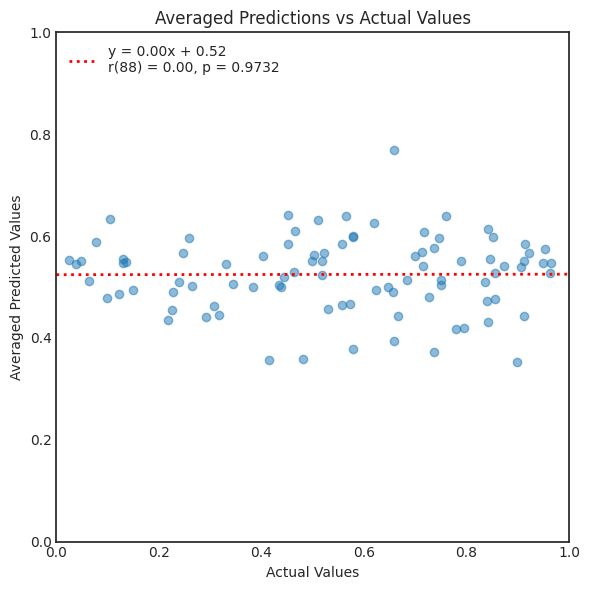

Correlation of averaged predictions (APA format): r(88) = 0.00, p = 0.9732
Regression line: y = 0.0010x + 0.5241

CREATING CSV FILE WITH ID MATCHING
Loaded target data with 90 rows
Created results DataFrame with 90 rows
Sample of results:
     ID  Actual  Prediction_1  Prediction_2  Prediction_3  Prediction_4  \
0  1064  0.0246        0.3346        0.7215        0.5329        0.7198   
1  1073  0.0389        0.5243        0.7233        0.6581        0.9084   
2  1020  0.0478        0.5963        0.8173        0.7698        0.7773   
3  1031  0.0636        0.4012        0.4169        0.6560        0.9772   
4  1044  0.0763        0.4264        0.4444        0.4935        0.6922   

   Prediction_5  Prediction_6  Prediction_7  Prediction_8  Prediction_9  \
0        0.7201        0.6948        0.5287        0.5727        0.4764   
1        0.6388        0.5422        0.5358        0.4660        0.5314   
2        0.5216        0.5995        0.7404        0.3240        0.7210   
3        0

In [53]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import glob

def extract_data(file_content):
    folds_data = []
    for fold in range(1, 6):
        pattern = rf"Fold {fold}.*?Predicted tensors for test set:\s*tensor\((.*?)\).*?Target tensors for test set:\s*tensor\((.*?)\)"
        match = re.search(pattern, file_content, re.DOTALL)
        if match:
            predictions = eval(f"[{match.group(1)}]")
            targets = eval(f"[{match.group(2)}]")
            folds_data.append((predictions, targets))
    return folds_data

def process_file(filename):
    with open(filename, 'r') as file:
        content = file.read()
    return extract_data(content)

def calculate_correlations(folds_data):
    correlations = []
    for predictions, targets in folds_data:
        predictions_flat = [item for sublist in predictions for item in sublist]
        targets_flat = [item for sublist in targets for item in sublist]
        if len(predictions_flat) > 1 and len(targets_flat) > 1:
            corr, _ = stats.pearsonr(predictions_flat, targets_flat)
            correlations.append(corr)
    return correlations

# Process all files
all_correlations_pointnet_hippo = []
all_predictions = []
all_actual = []

for filename in glob.glob('pointnet_results/job_output_hippocampus_fs*.out'):
    if 'old' not in filename.lower() and 'extra' not in filename.lower():
        folds_data = process_file(filename)
        correlations = calculate_correlations(folds_data)
        all_correlations_pointnet_hippo.extend(correlations)
        
        for predictions, targets in folds_data:
            all_predictions.extend([item for sublist in predictions for item in sublist])
            all_actual.extend([item for sublist in targets for item in sublist])

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_actual = np.array(all_actual)

print(f"Number of predictions: {len(all_predictions)}")
print(f"Number of actual values: {len(all_actual)}")

if len(all_predictions) == 0 or len(all_actual) == 0:
    print("No data extracted from files. Please check your input files and patterns.")
else:
    # Calculate mean and SD
    mean_correlation = np.mean(all_correlations_pointnet_hippo)
    std_correlation = np.std(all_correlations_pointnet_hippo)

    print(f"Mean correlation: {mean_correlation:.4f}")
    print(f"Standard deviation of correlation: {std_correlation:.4f}")

    # Plot distribution of correlations
    plt.figure(figsize=(10, 6))
    sns.histplot(all_correlations_pointnet_hippo, kde=True)
    plt.title("Distribution of Correlations for Hippocampus")
    plt.xlabel("Pearson Correlation")
    plt.axvline(mean_correlation, color='r', linestyle='--', label=f"Mean ({mean_correlation:.4f})")
    plt.legend()
    # plt.savefig('pointnet_hippo_correlation_distribution.svg', format='svg', bbox_inches='tight')
    plt.show()

    # Calculate correlation for all predictions
    if len(all_predictions) > 1 and len(all_actual) > 1:
        final_corr, final_p_value = stats.pearsonr(all_actual, all_predictions)
        df_final = len(all_actual) - 2  # degrees of freedom
        print(f"Overall correlation (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")

        # Create scatter plot of predictions vs actual values
        plt.figure(figsize=(10, 6))
        plt.scatter(all_actual, all_predictions, alpha=0.5)
        plt.title("Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.plot([min(all_actual), max(all_actual)], [min(all_actual), max(all_actual)], 'r--', lw=2)
        plt.text(0.05, 0.95, f'r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}', 
                 transform=plt.gca().transAxes, verticalalignment='top')
        #plt.savefig('pointnet_hippo_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Calculate average predictions for each unique actual value
        predictions_by_actual = {}
        for actual, pred in zip(all_actual, all_predictions):
            if actual not in predictions_by_actual:
                predictions_by_actual[actual] = []
            predictions_by_actual[actual].append(pred)

        avg_predictions = []
        unique_actual = []
        for actual, preds in sorted(predictions_by_actual.items()):
            unique_actual.append(actual)
            avg_predictions.append(np.mean(preds))

        unique_actual = np.array(unique_actual)
        avg_predictions = np.array(avg_predictions)

        # Calculate correlation for averaged predictions
        avg_corr, avg_p_value = stats.pearsonr(unique_actual, avg_predictions)
        df_avg = len(unique_actual) - 2  # degrees of freedom
        
        # Calculate the linear regression line
        slope_reg, intercept_reg, _, _, _ = stats.linregress(unique_actual, avg_predictions)
        
        # Create scatter plot of averaged predictions vs actual values
        plt.figure(figsize=(6, 6))
        plt.scatter(unique_actual, avg_predictions, alpha=0.5)

        # Plot the regression line
        x_range = np.array([0, 1])
        y_range_reg = slope_reg * x_range + intercept_reg

        plt.plot(x_range, y_range_reg, 'r:', linewidth=2, 
                 label=f'y = {slope_reg:.2f}x + {intercept_reg:.2f}\nr({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}')

        plt.title("Averaged Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Averaged Predicted Values")
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # Adjust legend position and font size
        plt.legend(loc='upper left', fontsize='medium')

        # Adjust layout to prevent cutting off the legend
        plt.tight_layout()

        plt.savefig('final_plots/pointnet_hippocampus_avg_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Print correlation and p-value in APA format
        print(f"Correlation of averaged predictions (APA format): r({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}")
        print(f"Regression line: y = {slope_reg:.4f}x + {intercept_reg:.4f}")


        # ===== NEW SECTION: Create CSV with ID matching =====
        print("\n" + "="*50)
        print("CREATING CSV FILE WITH ID MATCHING")
        print("="*50)
        
        try:
            # Load the target data to get IDs
            target_df = pd.read_csv('radiomic_results/DataAnalysisWith90Participants_Jupyter.csv')
            print(f"Loaded target data with {len(target_df)} rows")
            
            # Create initial DataFrame using existing all_actual and all_predictions
            results_df = pd.DataFrame({
                'Actual': all_actual,
                'Prediction': all_predictions
            })
            
            # Round actual values for matching
            results_df['Actual'] = results_df['Actual'].round(4)
            target_df['Model_Building_Total'] = target_df['Model_Building_Total'].round(4)
            
            # Create a mapping from actual values to IDs
            actual_to_id = dict(zip(target_df['Model_Building_Total'], target_df['ID']))
            
            # Add ID column by matching actual values
            results_df['ID'] = results_df['Actual'].map(actual_to_id)
            
            # Check for missing matches
            missing_matches = results_df['ID'].isna().sum()
            if missing_matches > 0:
                print(f"Warning: {missing_matches} actual values could not be matched with IDs")
                # Remove rows without ID matches
                results_df = results_df.dropna(subset=['ID'])
            
            # Group by ID and Actual to aggregate multiple predictions per participant
            grouped = results_df.groupby(['ID', 'Actual'])['Prediction'].apply(list).reset_index()
            
            # Create final DataFrame in the format of the first code
            final_results = []
            for _, row in grouped.iterrows():
                predictions = row['Prediction']
                record = {
                    'ID': int(row['ID']),
                    'Actual': row['Actual']
                }
                
                # Add individual predictions
                for i, pred in enumerate(predictions):
                    record[f'Prediction_{i+1}'] = round(pred, 4)
                
                # Add average prediction
                record['Average_Prediction'] = round(np.mean(predictions), 4)
                
                final_results.append(record)
            
            # Create final DataFrame
            results_df = pd.DataFrame(final_results)
            
            # Sort by actual values
            results_df = results_df.sort_values('Actual').reset_index(drop=True)
            
            # Reorder columns to match the first script's format
            prediction_cols = [col for col in results_df.columns if col.startswith('Prediction_')]
            column_order = ['ID', 'Actual'] + sorted(prediction_cols, key=lambda x: int(x.split('_')[1])) + ['Average_Prediction']
            results_df = results_df[column_order]
            
            print(f"Created results DataFrame with {len(results_df)} rows")
            print("Sample of results:")
            print(results_df.head())
            
            # Save to CSV
            output_filename = 'pointnet_hippocampus_predictions_with_average_and_id.csv'
            results_df.to_csv(output_filename, index=False)
            print(f"\nResults saved to '{output_filename}'")
            print(f"File contains {len(results_df)} rows and {len(results_df.columns)} columns")
            
        except FileNotFoundError:
            print("Error: Could not find 'radiomic_results/DataAnalysisWith90Participants_Jupyter.csv'")
            print("Please ensure the file exists in the correct location.")
        except Exception as e:
            print(f"Error creating CSV file: {str(e)}")
            import traceback
            traceback.print_exc()
        
        # ===== END NEW SECTION =====

    else:
        print("Not enough data to calculate correlations or create plots.")

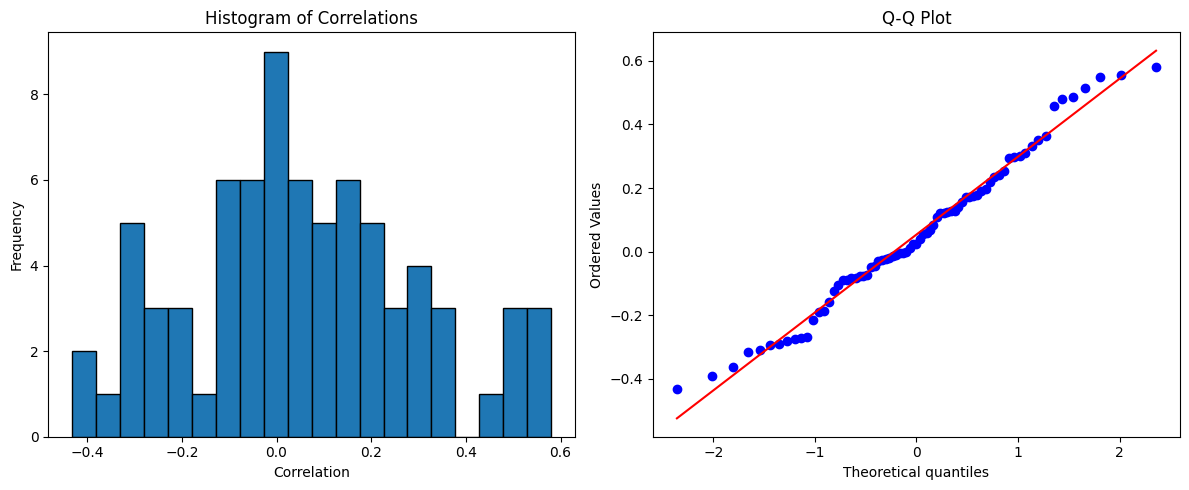


--- APA Style Results ---
Descriptive Statistics:
M = 0.05, SD = 0.24, 95% CI [-0.00, 0.11]
N = 75

Normality Assessment:
Shapiro-Wilk test: W(74) = 0.981, p = 0.341

Inference Statistics:
One-sample t-test: t(74) = 1.93, p = 0.058, d = 0.22
Wilcoxon signed-rank test: W = 1108.0, p = 0.094

APA Formatted Results Section:
The correlation coefficients (M = 0.05, SD = 0.24) were not significantly different from zero, t(74) = 1.93, p = 0.058, d = 0.22, 95% CI [-0.00, 0.11].


In [16]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Use the correct variable name from your code
all_correlations = all_correlations_pointnet_hippo

# Number of values in all_correlations
num_correlations = len(all_correlations)

# Descriptive statistics
mean_correlation = np.mean(all_correlations)
std_correlation = np.std(all_correlations, ddof=1)  # Using N-1 for sample std dev

# Wilcoxon signed-rank test
wilcoxon_statistic, wilcoxon_p_value = stats.wilcoxon(all_correlations)

# One-sample t-test
t_statistic, t_p_value = stats.ttest_1samp(all_correlations, 0)

# Calculate Cohen's d for one-sample t-test
cohens_d = mean_correlation / std_correlation  # For one-sample t-test comparing to zero

# Calculate 95% confidence interval
degrees_freedom = num_correlations - 1
ci_95 = stats.t.interval(0.95, degrees_freedom, loc=mean_correlation, 
                         scale=std_correlation/np.sqrt(num_correlations))

# Check normality using Shapiro-Wilk test
shapiro_statistic, shapiro_p_value = stats.shapiro(all_correlations)

# Create Q-Q plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
ax1.hist(all_correlations, bins=20, edgecolor='black')
ax1.set_title('Histogram of Correlations')
ax1.set_xlabel('Correlation')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(all_correlations, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot")
plt.tight_layout()
plt.show()

# Format p-values according to APA
def format_p_value(p):
    if p < 0.001:
        return "p < .001"
    else:
        return f"p = {p:.3f}"

# Print statistical results in APA format
print("\n--- APA Style Results ---")
print("Descriptive Statistics:")
print(f"M = {mean_correlation:.2f}, SD = {std_correlation:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
print(f"N = {num_correlations}")

print("\nNormality Assessment:")
print(f"Shapiro-Wilk test: W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}")

print("\nInference Statistics:")
print(f"One-sample t-test: t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}")
print(f"Wilcoxon signed-rank test: W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}")

# APA formatted result (ready for copy-paste)
print("\nAPA Formatted Results Section:")
if shapiro_p_value >= 0.05:
    print(f"The correlation coefficients (M = {mean_correlation:.2f}, SD = {std_correlation:.2f}) were {'not ' if t_p_value >= 0.05 else ''}significantly different from zero, t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}].")
else:
    print(f"Due to the non-normal distribution of correlation coefficients (Shapiro-Wilk W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}), a Wilcoxon signed-rank test was conducted. The correlations (Mdn = {np.median(all_correlations):.2f}) were {'not ' if wilcoxon_p_value >= 0.05 else ''}significantly different from zero, W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}. For completeness, a t-test yielded t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}.")

## Pointnet thalamus

Number of predictions: 1350
Number of actual values: 1350
Mean correlation: 0.1154
Standard deviation of correlation: 0.2381


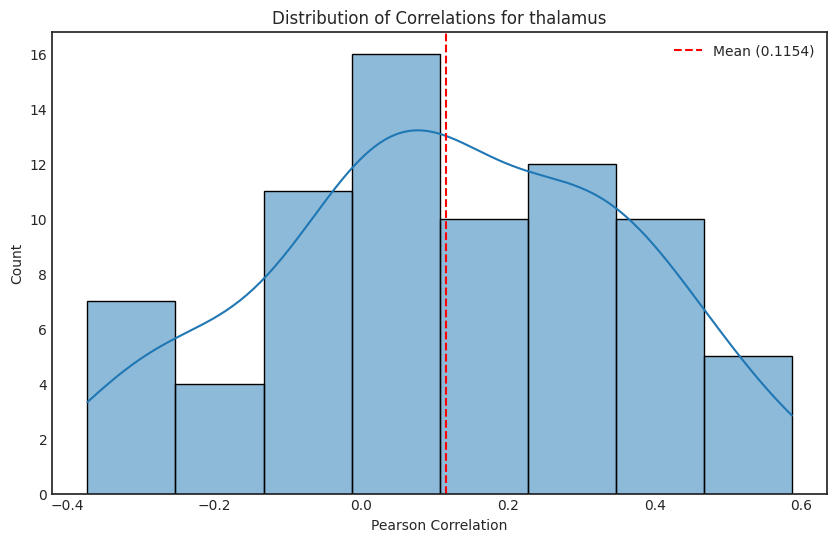

Overall correlation (APA format): r(1348) = 0.05, p = 0.0661


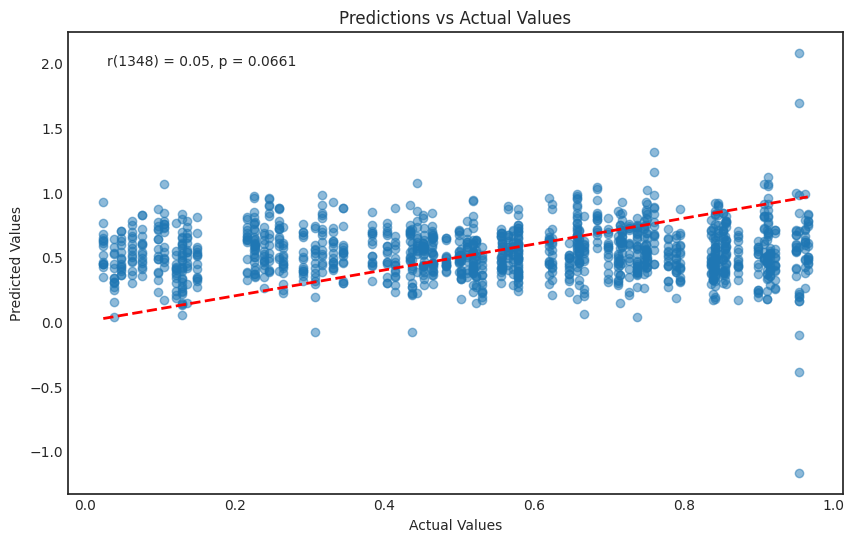

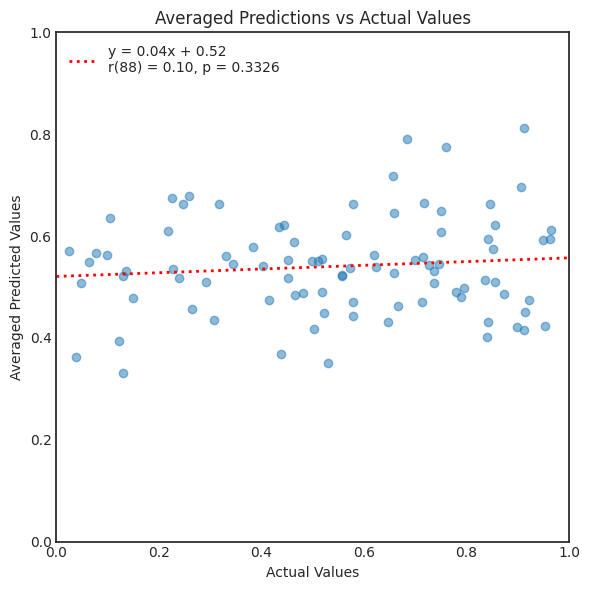

Correlation of averaged predictions (APA format): r(88) = 0.10, p = 0.3326
Regression line: y = 0.0365x + 0.5206

CREATING CSV FILE WITH ID MATCHING
Loaded target data with 90 rows
Created results DataFrame with 90 rows
Sample of results:
     ID  Actual  Prediction_1  Prediction_2  Prediction_3  Prediction_4  \
0  1064  0.0246        0.4226        0.6314        0.4487        0.6231   
1  1073  0.0389        0.2457        0.3396        0.0345        0.4427   
2  1020  0.0478        0.4926        0.4287        0.4889        0.6448   
3  1031  0.0636        0.5020        0.5993        0.5193        0.5685   
4  1044  0.0763        0.4219        0.4081        0.3544        0.8278   

   Prediction_5  Prediction_6  Prediction_7  Prediction_8  Prediction_9  \
0        0.6766        0.9273        0.3429        0.5193        0.6496   
1        0.5742        0.6379        0.3408        0.4179        0.5353   
2        0.6224        0.7020        0.3633        0.5357        0.5965   
3        0

In [54]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import glob

def extract_data(file_content):
    folds_data = []
    for fold in range(1, 6):
        pattern = rf"Fold {fold}.*?Predicted tensors for test set:\s*tensor\((.*?)\).*?Target tensors for test set:\s*tensor\((.*?)\)"
        match = re.search(pattern, file_content, re.DOTALL)
        if match:
            predictions = eval(f"[{match.group(1)}]")
            targets = eval(f"[{match.group(2)}]")
            folds_data.append((predictions, targets))
    return folds_data

def process_file(filename):
    with open(filename, 'r') as file:
        content = file.read()
    return extract_data(content)

def calculate_correlations(folds_data):
    correlations = []
    for predictions, targets in folds_data:
        predictions_flat = [item for sublist in predictions for item in sublist]
        targets_flat = [item for sublist in targets for item in sublist]
        if len(predictions_flat) > 1 and len(targets_flat) > 1:
            corr, _ = stats.pearsonr(predictions_flat, targets_flat)
            correlations.append(corr)
    return correlations

# Process all files
all_correlations_pointnet_thalamus = []
all_predictions = []
all_actual = []

for filename in glob.glob('pointnet_results/job_output_thalamus_fs*.out'):
    if 'old' not in filename.lower() and 'extra' not in filename.lower():
        folds_data = process_file(filename)
        correlations = calculate_correlations(folds_data)
        all_correlations_pointnet_thalamus.extend(correlations)
        
        for predictions, targets in folds_data:
            all_predictions.extend([item for sublist in predictions for item in sublist])
            all_actual.extend([item for sublist in targets for item in sublist])

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_actual = np.array(all_actual)

print(f"Number of predictions: {len(all_predictions)}")
print(f"Number of actual values: {len(all_actual)}")

if len(all_predictions) == 0 or len(all_actual) == 0:
    print("No data extracted from files. Please check your input files and patterns.")
else:
    # Calculate mean and SD
    mean_correlation = np.mean(all_correlations_pointnet_thalamus)
    std_correlation = np.std(all_correlations_pointnet_thalamus)

    print(f"Mean correlation: {mean_correlation:.4f}")
    print(f"Standard deviation of correlation: {std_correlation:.4f}")

    # Plot distribution of correlations
    plt.figure(figsize=(10, 6))
    sns.histplot(all_correlations_pointnet_thalamus, kde=True)
    plt.title("Distribution of Correlations for thalamus")
    plt.xlabel("Pearson Correlation")
    plt.axvline(mean_correlation, color='r', linestyle='--', label=f"Mean ({mean_correlation:.4f})")
    plt.legend()
    # plt.savefig('pointnet_thalamus_correlation_distribution.svg', format='svg', bbox_inches='tight')
    plt.show()

    # Calculate correlation for all predictions
    if len(all_predictions) > 1 and len(all_actual) > 1:
        final_corr, final_p_value = stats.pearsonr(all_actual, all_predictions)
        df_final = len(all_actual) - 2  # degrees of freedom
        print(f"Overall correlation (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")

        # Create scatter plot of predictions vs actual values
        plt.figure(figsize=(10, 6))
        plt.scatter(all_actual, all_predictions, alpha=0.5)
        plt.title("Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.plot([min(all_actual), max(all_actual)], [min(all_actual), max(all_actual)], 'r--', lw=2)
        plt.text(0.05, 0.95, f'r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}', 
                 transform=plt.gca().transAxes, verticalalignment='top')
        #plt.savefig('pointnet_thalamus_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Calculate average predictions for each unique actual value
        predictions_by_actual = {}
        for actual, pred in zip(all_actual, all_predictions):
            if actual not in predictions_by_actual:
                predictions_by_actual[actual] = []
            predictions_by_actual[actual].append(pred)

        avg_predictions = []
        unique_actual = []
        for actual, preds in sorted(predictions_by_actual.items()):
            unique_actual.append(actual)
            avg_predictions.append(np.mean(preds))

        unique_actual = np.array(unique_actual)
        avg_predictions = np.array(avg_predictions)

        # Calculate correlation for averaged predictions
        avg_corr, avg_p_value = stats.pearsonr(unique_actual, avg_predictions)
        df_avg = len(unique_actual) - 2  # degrees of freedom
        
        # Calculate the linear regression line
        slope_reg, intercept_reg, _, _, _ = stats.linregress(unique_actual, avg_predictions)
        
        # Create scatter plot of averaged predictions vs actual values
        plt.figure(figsize=(6, 6))
        plt.scatter(unique_actual, avg_predictions, alpha=0.5)

        # Plot the regression line
        x_range = np.array([0, 1])
        y_range_reg = slope_reg * x_range + intercept_reg

        plt.plot(x_range, y_range_reg, 'r:', linewidth=2, 
                 label=f'y = {slope_reg:.2f}x + {intercept_reg:.2f}\nr({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}')

        plt.title("Averaged Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Averaged Predicted Values")
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # Adjust legend position and font size
        plt.legend(loc='upper left', fontsize='medium')

        # Adjust layout to prevent cutting off the legend
        plt.tight_layout()

        plt.savefig('final_plots/pointnet_thalamus_avg_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Print correlation and p-value in APA format
        print(f"Correlation of averaged predictions (APA format): r({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}")
        print(f"Regression line: y = {slope_reg:.4f}x + {intercept_reg:.4f}")


        # ===== NEW SECTION: Create CSV with ID matching =====
        print("\n" + "="*50)
        print("CREATING CSV FILE WITH ID MATCHING")
        print("="*50)
        
        try:
            # Load the target data to get IDs
            target_df = pd.read_csv('radiomic_results/DataAnalysisWith90Participants_Jupyter.csv')
            print(f"Loaded target data with {len(target_df)} rows")
            
            # Create initial DataFrame using existing all_actual and all_predictions
            results_df = pd.DataFrame({
                'Actual': all_actual,
                'Prediction': all_predictions
            })
            
            # Round actual values for matching
            results_df['Actual'] = results_df['Actual'].round(4)
            target_df['Model_Building_Total'] = target_df['Model_Building_Total'].round(4)
            
            # Create a mapping from actual values to IDs
            actual_to_id = dict(zip(target_df['Model_Building_Total'], target_df['ID']))
            
            # Add ID column by matching actual values
            results_df['ID'] = results_df['Actual'].map(actual_to_id)
            
            # Check for missing matches
            missing_matches = results_df['ID'].isna().sum()
            if missing_matches > 0:
                print(f"Warning: {missing_matches} actual values could not be matched with IDs")
                # Remove rows without ID matches
                results_df = results_df.dropna(subset=['ID'])
            
            # Group by ID and Actual to aggregate multiple predictions per participant
            grouped = results_df.groupby(['ID', 'Actual'])['Prediction'].apply(list).reset_index()
            
            # Create final DataFrame in the format of the first code
            final_results = []
            for _, row in grouped.iterrows():
                predictions = row['Prediction']
                record = {
                    'ID': int(row['ID']),
                    'Actual': row['Actual']
                }
                
                # Add individual predictions
                for i, pred in enumerate(predictions):
                    record[f'Prediction_{i+1}'] = round(pred, 4)
                
                # Add average prediction
                record['Average_Prediction'] = round(np.mean(predictions), 4)
                
                final_results.append(record)
            
            # Create final DataFrame
            results_df = pd.DataFrame(final_results)
            
            # Sort by actual values
            results_df = results_df.sort_values('Actual').reset_index(drop=True)
            
            # Reorder columns to match the first script's format
            prediction_cols = [col for col in results_df.columns if col.startswith('Prediction_')]
            column_order = ['ID', 'Actual'] + sorted(prediction_cols, key=lambda x: int(x.split('_')[1])) + ['Average_Prediction']
            results_df = results_df[column_order]
            
            print(f"Created results DataFrame with {len(results_df)} rows")
            print("Sample of results:")
            print(results_df.head())
            
            # Save to CSV
            output_filename = 'pointnet_thalamus_predictions_with_average_and_id.csv'
            results_df.to_csv(output_filename, index=False)
            print(f"\nResults saved to '{output_filename}'")
            print(f"File contains {len(results_df)} rows and {len(results_df.columns)} columns")
            
        except FileNotFoundError:
            print("Error: Could not find 'radiomic_results/DataAnalysisWith90Participants_Jupyter.csv'")
            print("Please ensure the file exists in the correct location.")
        except Exception as e:
            print(f"Error creating CSV file: {str(e)}")
            import traceback
            traceback.print_exc()
        
        # ===== END NEW SECTION =====

    else:
        print("Not enough data to calculate correlations or create plots.")

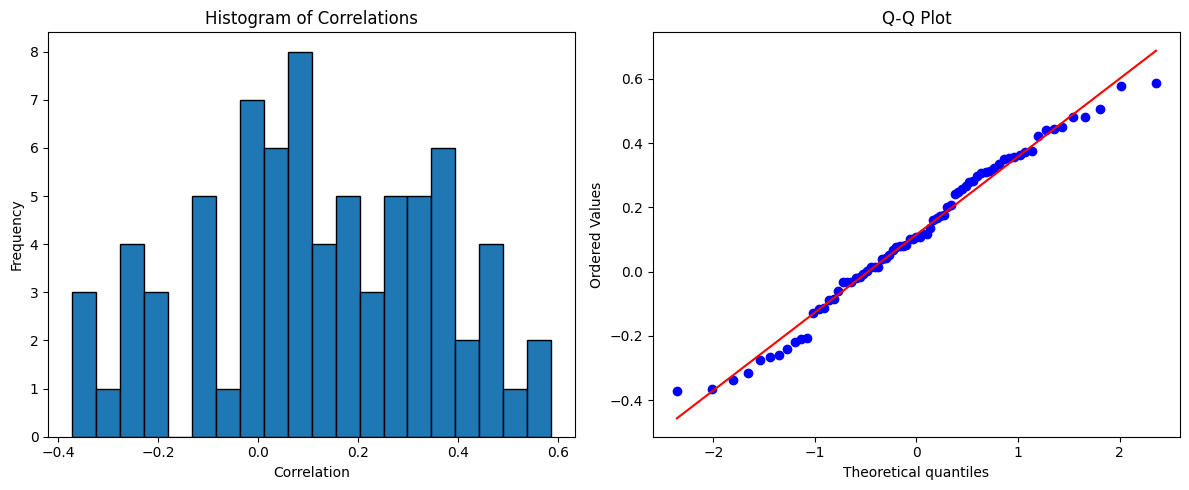


--- APA Style Results ---
Descriptive Statistics:
M = 0.12, SD = 0.24, 95% CI [0.06, 0.17]
N = 75

Normality Assessment:
Shapiro-Wilk test: W(74) = 0.980, p = 0.298

Inference Statistics:
One-sample t-test: t(74) = 4.17, p < .001, d = 0.48
Wilcoxon signed-rank test: W = 717.0, p < .001

APA Formatted Results Section:
The correlation coefficients (M = 0.12, SD = 0.24) were significantly different from zero, t(74) = 4.17, p < .001, d = 0.48, 95% CI [0.06, 0.17].


In [18]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Use the correct variable name from your code
all_correlations = all_correlations_pointnet_thalamus

# Number of values in all_correlations
num_correlations = len(all_correlations)

# Descriptive statistics
mean_correlation = np.mean(all_correlations)
std_correlation = np.std(all_correlations, ddof=1)  # Using N-1 for sample std dev

# Wilcoxon signed-rank test
wilcoxon_statistic, wilcoxon_p_value = stats.wilcoxon(all_correlations)

# One-sample t-test
t_statistic, t_p_value = stats.ttest_1samp(all_correlations, 0)

# Calculate Cohen's d for one-sample t-test
cohens_d = mean_correlation / std_correlation  # For one-sample t-test comparing to zero

# Calculate 95% confidence interval
degrees_freedom = num_correlations - 1
ci_95 = stats.t.interval(0.95, degrees_freedom, loc=mean_correlation, 
                         scale=std_correlation/np.sqrt(num_correlations))

# Check normality using Shapiro-Wilk test
shapiro_statistic, shapiro_p_value = stats.shapiro(all_correlations)

# Create Q-Q plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
ax1.hist(all_correlations, bins=20, edgecolor='black')
ax1.set_title('Histogram of Correlations')
ax1.set_xlabel('Correlation')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(all_correlations, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot")
plt.tight_layout()
plt.show()

# Format p-values according to APA
def format_p_value(p):
    if p < 0.001:
        return "p < .001"
    else:
        return f"p = {p:.3f}"

# Print statistical results in APA format
print("\n--- APA Style Results ---")
print("Descriptive Statistics:")
print(f"M = {mean_correlation:.2f}, SD = {std_correlation:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
print(f"N = {num_correlations}")

print("\nNormality Assessment:")
print(f"Shapiro-Wilk test: W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}")

print("\nInference Statistics:")
print(f"One-sample t-test: t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}")
print(f"Wilcoxon signed-rank test: W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}")

# APA formatted result (ready for copy-paste)
print("\nAPA Formatted Results Section:")
if shapiro_p_value >= 0.05:
    print(f"The correlation coefficients (M = {mean_correlation:.2f}, SD = {std_correlation:.2f}) were {'not ' if t_p_value >= 0.05 else ''}significantly different from zero, t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}].")
else:
    print(f"Due to the non-normal distribution of correlation coefficients (Shapiro-Wilk W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}), a Wilcoxon signed-rank test was conducted. The correlations (Mdn = {np.median(all_correlations):.2f}) were {'not ' if wilcoxon_p_value >= 0.05 else ''}significantly different from zero, W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}. For completeness, a t-test yielded t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}.")

## Pointnet amygdala

Number of predictions: 1350
Number of actual values: 1350
Mean correlation: 0.0692
Standard deviation of correlation: 0.2453


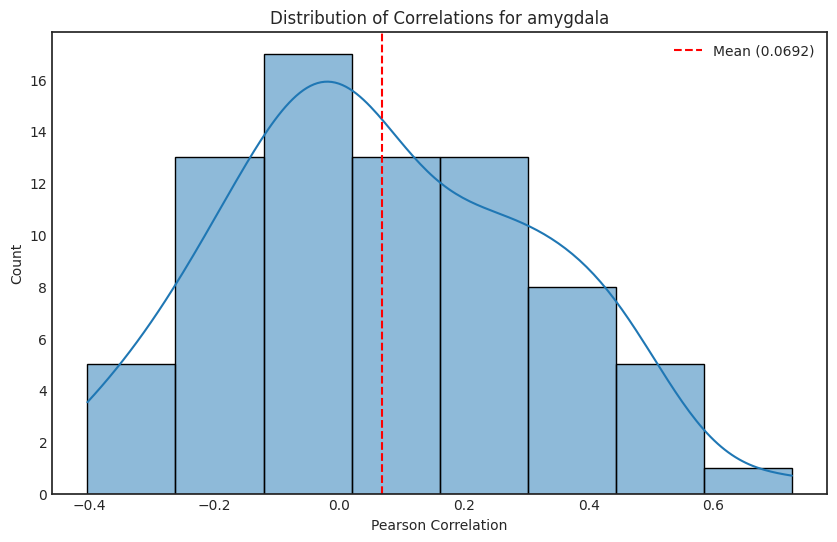

Overall correlation (APA format): r(1348) = 0.02, p = 0.4523


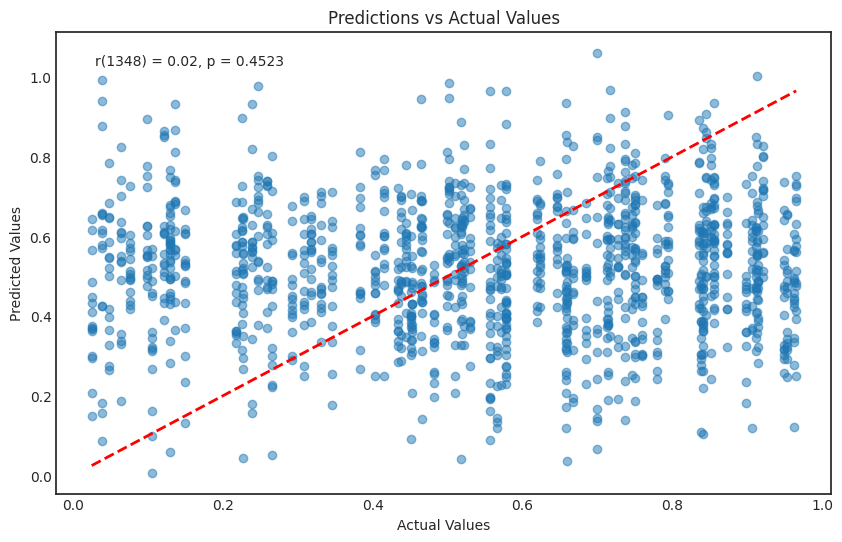

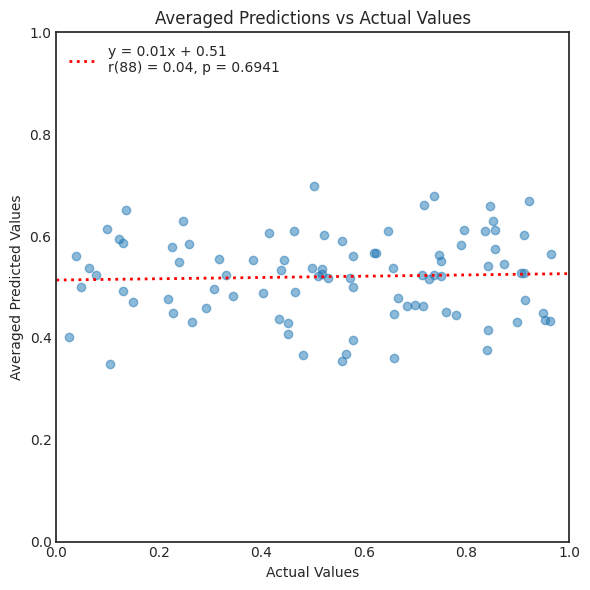

Correlation of averaged predictions (APA format): r(88) = 0.04, p = 0.6941
Regression line: y = 0.0126x + 0.5136

CREATING CSV FILE WITH ID MATCHING
Loaded target data with 90 rows
Created results DataFrame with 90 rows
Sample of results:
     ID  Actual  Prediction_1  Prediction_2  Prediction_3  Prediction_4  \
0  1064  0.0246        0.6426        0.4853        0.3666        0.5666   
1  1073  0.0389        0.6526        0.6582        0.5716        0.9392   
2  1020  0.0478        0.2742        0.5199        0.5475        0.6496   
3  1031  0.0636        0.6115        0.3303        0.7408        0.8246   
4  1044  0.0763        0.4274        0.4937        0.4183        0.6048   

   Prediction_5  Prediction_6  Prediction_7  Prediction_8  Prediction_9  \
0        0.4326        0.4477        0.2937        0.2070        0.2986   
1        0.9925        0.6554        0.4248        0.1822        0.1560   
2        0.7843        0.5458        0.3278        0.2644        0.4167   
3        0

In [55]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import glob

def extract_data(file_content):
    folds_data = []
    for fold in range(1, 6):
        pattern = rf"Fold {fold}.*?Predicted tensors for test set:\s*tensor\((.*?)\).*?Target tensors for test set:\s*tensor\((.*?)\)"
        match = re.search(pattern, file_content, re.DOTALL)
        if match:
            predictions = eval(f"[{match.group(1)}]")
            targets = eval(f"[{match.group(2)}]")
            folds_data.append((predictions, targets))
    return folds_data

def process_file(filename):
    with open(filename, 'r') as file:
        content = file.read()
    return extract_data(content)

def calculate_correlations(folds_data):
    correlations = []
    for predictions, targets in folds_data:
        predictions_flat = [item for sublist in predictions for item in sublist]
        targets_flat = [item for sublist in targets for item in sublist]
        if len(predictions_flat) > 1 and len(targets_flat) > 1:
            corr, _ = stats.pearsonr(predictions_flat, targets_flat)
            correlations.append(corr)
    return correlations

# Process all files
all_correlations_pointnet_amygdala = []
all_predictions = []
all_actual = []

for filename in glob.glob('pointnet_results/job_output_amygdala_fs*.out'):
    if 'old' not in filename.lower() and 'extra' not in filename.lower():
        folds_data = process_file(filename)
        correlations = calculate_correlations(folds_data)
        all_correlations_pointnet_amygdala.extend(correlations)
        
        for predictions, targets in folds_data:
            all_predictions.extend([item for sublist in predictions for item in sublist])
            all_actual.extend([item for sublist in targets for item in sublist])

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_actual = np.array(all_actual)

print(f"Number of predictions: {len(all_predictions)}")
print(f"Number of actual values: {len(all_actual)}")

if len(all_predictions) == 0 or len(all_actual) == 0:
    print("No data extracted from files. Please check your input files and patterns.")
else:
    # Calculate mean and SD
    mean_correlation = np.mean(all_correlations_pointnet_amygdala)
    std_correlation = np.std(all_correlations_pointnet_amygdala)

    print(f"Mean correlation: {mean_correlation:.4f}")
    print(f"Standard deviation of correlation: {std_correlation:.4f}")

    # Plot distribution of correlations
    plt.figure(figsize=(10, 6))
    sns.histplot(all_correlations_pointnet_amygdala, kde=True)
    plt.title("Distribution of Correlations for amygdala")
    plt.xlabel("Pearson Correlation")
    plt.axvline(mean_correlation, color='r', linestyle='--', label=f"Mean ({mean_correlation:.4f})")
    plt.legend()
    # plt.savefig('pointnet_amygdala_correlation_distribution.svg', format='svg', bbox_inches='tight')
    plt.show()

    # Calculate correlation for all predictions
    if len(all_predictions) > 1 and len(all_actual) > 1:
        final_corr, final_p_value = stats.pearsonr(all_actual, all_predictions)
        df_final = len(all_actual) - 2  # degrees of freedom
        print(f"Overall correlation (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")

        # Create scatter plot of predictions vs actual values
        plt.figure(figsize=(10, 6))
        plt.scatter(all_actual, all_predictions, alpha=0.5)
        plt.title("Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.plot([min(all_actual), max(all_actual)], [min(all_actual), max(all_actual)], 'r--', lw=2)
        plt.text(0.05, 0.95, f'r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}', 
                 transform=plt.gca().transAxes, verticalalignment='top')
        #plt.savefig('pointnet_amygdala_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Calculate average predictions for each unique actual value
        predictions_by_actual = {}
        for actual, pred in zip(all_actual, all_predictions):
            if actual not in predictions_by_actual:
                predictions_by_actual[actual] = []
            predictions_by_actual[actual].append(pred)

        avg_predictions = []
        unique_actual = []
        for actual, preds in sorted(predictions_by_actual.items()):
            unique_actual.append(actual)
            avg_predictions.append(np.mean(preds))

        unique_actual = np.array(unique_actual)
        avg_predictions = np.array(avg_predictions)

        # Calculate correlation for averaged predictions
        avg_corr, avg_p_value = stats.pearsonr(unique_actual, avg_predictions)
        df_avg = len(unique_actual) - 2  # degrees of freedom
        
        # Calculate the linear regression line
        slope_reg, intercept_reg, _, _, _ = stats.linregress(unique_actual, avg_predictions)
        
        # Create scatter plot of averaged predictions vs actual values
        plt.figure(figsize=(6, 6))
        plt.scatter(unique_actual, avg_predictions, alpha=0.5)

        # Plot the regression line
        x_range = np.array([0, 1])
        y_range_reg = slope_reg * x_range + intercept_reg

        plt.plot(x_range, y_range_reg, 'r:', linewidth=2, 
                 label=f'y = {slope_reg:.2f}x + {intercept_reg:.2f}\nr({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}')

        plt.title("Averaged Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Averaged Predicted Values")
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # Adjust legend position and font size
        plt.legend(loc='upper left', fontsize='medium')

        # Adjust layout to prevent cutting off the legend
        plt.tight_layout()

        plt.savefig('final_plots/pointnet_amygdala_avg_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Print correlation and p-value in APA format
        print(f"Correlation of averaged predictions (APA format): r({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}")
        print(f"Regression line: y = {slope_reg:.4f}x + {intercept_reg:.4f}")


        # ===== NEW SECTION: Create CSV with ID matching =====
        print("\n" + "="*50)
        print("CREATING CSV FILE WITH ID MATCHING")
        print("="*50)
        
        try:
            # Load the target data to get IDs
            target_df = pd.read_csv('radiomic_results/DataAnalysisWith90Participants_Jupyter.csv')
            print(f"Loaded target data with {len(target_df)} rows")
            
            # Create initial DataFrame using existing all_actual and all_predictions
            results_df = pd.DataFrame({
                'Actual': all_actual,
                'Prediction': all_predictions
            })
            
            # Round actual values for matching
            results_df['Actual'] = results_df['Actual'].round(4)
            target_df['Model_Building_Total'] = target_df['Model_Building_Total'].round(4)
            
            # Create a mapping from actual values to IDs
            actual_to_id = dict(zip(target_df['Model_Building_Total'], target_df['ID']))
            
            # Add ID column by matching actual values
            results_df['ID'] = results_df['Actual'].map(actual_to_id)
            
            # Check for missing matches
            missing_matches = results_df['ID'].isna().sum()
            if missing_matches > 0:
                print(f"Warning: {missing_matches} actual values could not be matched with IDs")
                # Remove rows without ID matches
                results_df = results_df.dropna(subset=['ID'])
            
            # Group by ID and Actual to aggregate multiple predictions per participant
            grouped = results_df.groupby(['ID', 'Actual'])['Prediction'].apply(list).reset_index()
            
            # Create final DataFrame in the format of the first code
            final_results = []
            for _, row in grouped.iterrows():
                predictions = row['Prediction']
                record = {
                    'ID': int(row['ID']),
                    'Actual': row['Actual']
                }
                
                # Add individual predictions
                for i, pred in enumerate(predictions):
                    record[f'Prediction_{i+1}'] = round(pred, 4)
                
                # Add average prediction
                record['Average_Prediction'] = round(np.mean(predictions), 4)
                
                final_results.append(record)
            
            # Create final DataFrame
            results_df = pd.DataFrame(final_results)
            
            # Sort by actual values
            results_df = results_df.sort_values('Actual').reset_index(drop=True)
            
            # Reorder columns to match the first script's format
            prediction_cols = [col for col in results_df.columns if col.startswith('Prediction_')]
            column_order = ['ID', 'Actual'] + sorted(prediction_cols, key=lambda x: int(x.split('_')[1])) + ['Average_Prediction']
            results_df = results_df[column_order]
            
            print(f"Created results DataFrame with {len(results_df)} rows")
            print("Sample of results:")
            print(results_df.head())
            
            # Save to CSV
            output_filename = 'pointnet_amygdala_predictions_with_average_and_id.csv'
            results_df.to_csv(output_filename, index=False)
            print(f"\nResults saved to '{output_filename}'")
            print(f"File contains {len(results_df)} rows and {len(results_df.columns)} columns")
            
        except FileNotFoundError:
            print("Error: Could not find 'radiomic_results/DataAnalysisWith90Participants_Jupyter.csv'")
            print("Please ensure the file exists in the correct location.")
        except Exception as e:
            print(f"Error creating CSV file: {str(e)}")
            import traceback
            traceback.print_exc()
        
        # ===== END NEW SECTION =====

    else:
        print("Not enough data to calculate correlations or create plots.")

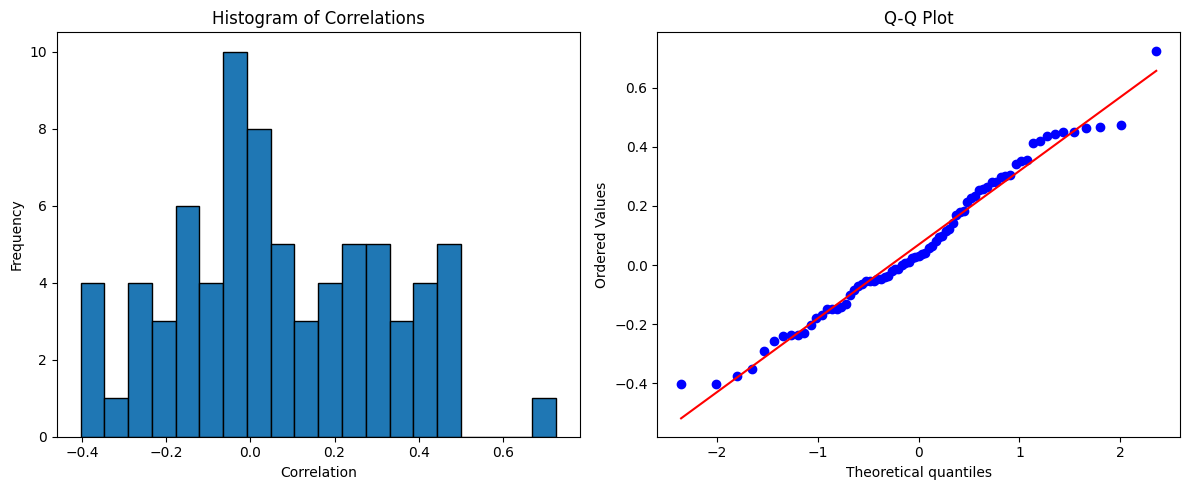


--- APA Style Results ---
Descriptive Statistics:
M = 0.07, SD = 0.25, 95% CI [0.01, 0.13]
N = 75

Normality Assessment:
Shapiro-Wilk test: W(74) = 0.980, p = 0.275

Inference Statistics:
One-sample t-test: t(74) = 2.43, p = 0.018, d = 0.28
Wilcoxon signed-rank test: W = 1034.0, p = 0.039

APA Formatted Results Section:
The correlation coefficients (M = 0.07, SD = 0.25) were significantly different from zero, t(74) = 2.43, p = 0.018, d = 0.28, 95% CI [0.01, 0.13].


In [20]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Use the correct variable name from your code
all_correlations = all_correlations_pointnet_amygdala

# Number of values in all_correlations
num_correlations = len(all_correlations)

# Descriptive statistics
mean_correlation = np.mean(all_correlations)
std_correlation = np.std(all_correlations, ddof=1)  # Using N-1 for sample std dev

# Wilcoxon signed-rank test
wilcoxon_statistic, wilcoxon_p_value = stats.wilcoxon(all_correlations)

# One-sample t-test
t_statistic, t_p_value = stats.ttest_1samp(all_correlations, 0)

# Calculate Cohen's d for one-sample t-test
cohens_d = mean_correlation / std_correlation  # For one-sample t-test comparing to zero

# Calculate 95% confidence interval
degrees_freedom = num_correlations - 1
ci_95 = stats.t.interval(0.95, degrees_freedom, loc=mean_correlation, 
                         scale=std_correlation/np.sqrt(num_correlations))

# Check normality using Shapiro-Wilk test
shapiro_statistic, shapiro_p_value = stats.shapiro(all_correlations)

# Create Q-Q plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
ax1.hist(all_correlations, bins=20, edgecolor='black')
ax1.set_title('Histogram of Correlations')
ax1.set_xlabel('Correlation')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(all_correlations, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot")
plt.tight_layout()
plt.show()

# Format p-values according to APA
def format_p_value(p):
    if p < 0.001:
        return "p < .001"
    else:
        return f"p = {p:.3f}"

# Print statistical results in APA format
print("\n--- APA Style Results ---")
print("Descriptive Statistics:")
print(f"M = {mean_correlation:.2f}, SD = {std_correlation:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
print(f"N = {num_correlations}")

print("\nNormality Assessment:")
print(f"Shapiro-Wilk test: W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}")

print("\nInference Statistics:")
print(f"One-sample t-test: t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}")
print(f"Wilcoxon signed-rank test: W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}")

# APA formatted result (ready for copy-paste)
print("\nAPA Formatted Results Section:")
if shapiro_p_value >= 0.05:
    print(f"The correlation coefficients (M = {mean_correlation:.2f}, SD = {std_correlation:.2f}) were {'not ' if t_p_value >= 0.05 else ''}significantly different from zero, t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}].")
else:
    print(f"Due to the non-normal distribution of correlation coefficients (Shapiro-Wilk W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}), a Wilcoxon signed-rank test was conducted. The correlations (Mdn = {np.median(all_correlations):.2f}) were {'not ' if wilcoxon_p_value >= 0.05 else ''}significantly different from zero, W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}. For completeness, a t-test yielded t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}.")

## Pointnet isthmus cingulate

Number of predictions: 1350
Number of actual values: 1350
Mean correlation: 0.0231
Standard deviation of correlation: 0.2498


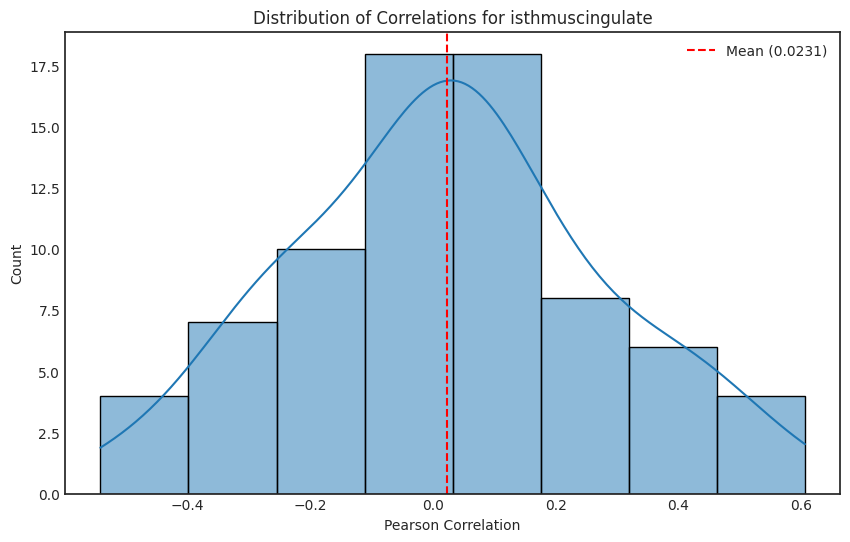

Overall correlation (APA format): r(1348) = -0.01, p = 0.8326


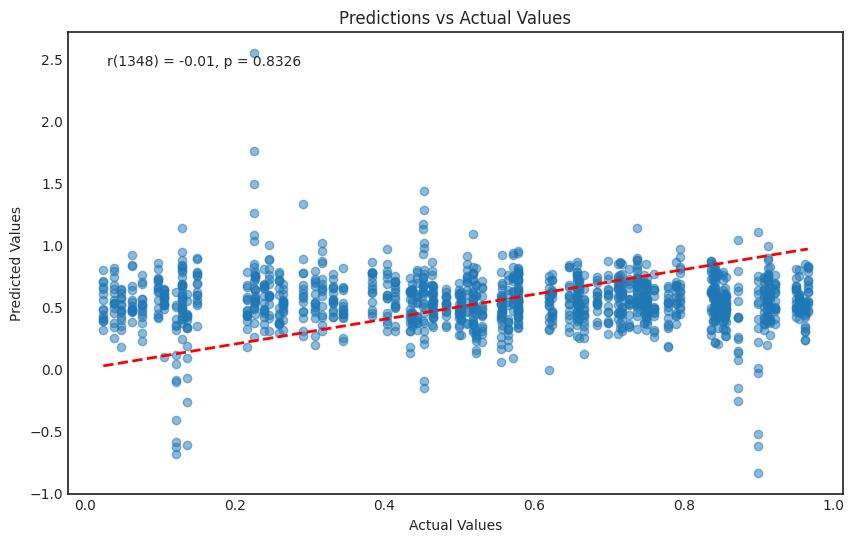

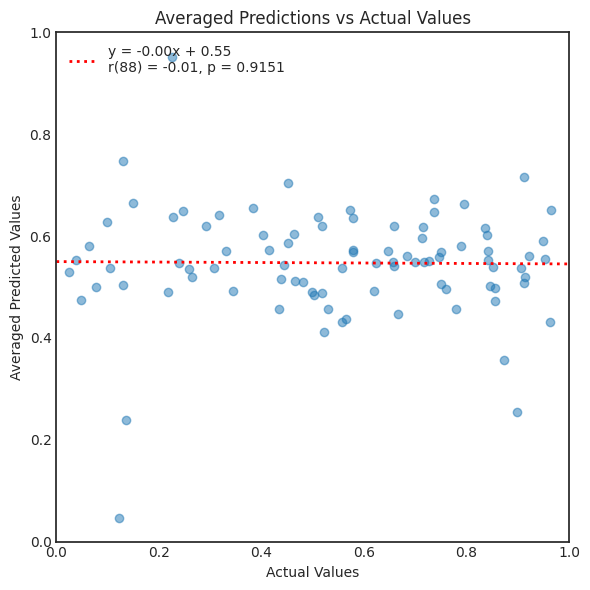

Correlation of averaged predictions (APA format): r(88) = -0.01, p = 0.9151
Regression line: y = -0.0046x + 0.5498

CREATING CSV FILE WITH ID MATCHING
Loaded target data with 90 rows
Created results DataFrame with 90 rows
Sample of results:
     ID  Actual  Prediction_1  Prediction_2  Prediction_3  Prediction_4  \
0  1064  0.0246        0.4736        0.5534        0.4365        0.6021   
1  1073  0.0389        0.4478        0.7433        0.2519        0.5200   
2  1020  0.0478        0.1775        0.4548        0.4658        0.4765   
3  1031  0.0636        0.4626        0.5540        0.3759        0.5094   
4  1044  0.0763        0.2222        0.5200        0.4450        0.4899   

   Prediction_5  Prediction_6  Prediction_7  Prediction_8  Prediction_9  \
0        0.4831        0.3982        0.6626        0.4062        0.3890   
1        0.7854        0.5291        0.6783        0.6132        0.3702   
2        0.6458        0.3154        0.5258        0.5706        0.3945   
3       

In [56]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import glob

def extract_data(file_content):
    folds_data = []
    for fold in range(1, 6):
        pattern = rf"Fold {fold}.*?Predicted tensors for test set:\s*tensor\((.*?)\).*?Target tensors for test set:\s*tensor\((.*?)\)"
        match = re.search(pattern, file_content, re.DOTALL)
        if match:
            predictions = eval(f"[{match.group(1)}]")
            targets = eval(f"[{match.group(2)}]")
            folds_data.append((predictions, targets))
    return folds_data

def process_file(filename):
    with open(filename, 'r') as file:
        content = file.read()
    return extract_data(content)

def calculate_correlations(folds_data):
    correlations = []
    for predictions, targets in folds_data:
        predictions_flat = [item for sublist in predictions for item in sublist]
        targets_flat = [item for sublist in targets for item in sublist]
        if len(predictions_flat) > 1 and len(targets_flat) > 1:
            corr, _ = stats.pearsonr(predictions_flat, targets_flat)
            correlations.append(corr)
    return correlations

# Process all files
all_correlations_pointnet_isthmuscingulate = []
all_predictions = []
all_actual = []

for filename in glob.glob('pointnet_results/job_output_isthmuscingulate_fs*.out'):
    if 'old' not in filename.lower() and 'extra' not in filename.lower():
        folds_data = process_file(filename)
        correlations = calculate_correlations(folds_data)
        all_correlations_pointnet_isthmuscingulate.extend(correlations)
        
        for predictions, targets in folds_data:
            all_predictions.extend([item for sublist in predictions for item in sublist])
            all_actual.extend([item for sublist in targets for item in sublist])

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_actual = np.array(all_actual)

print(f"Number of predictions: {len(all_predictions)}")
print(f"Number of actual values: {len(all_actual)}")

if len(all_predictions) == 0 or len(all_actual) == 0:
    print("No data extracted from files. Please check your input files and patterns.")
else:
    # Calculate mean and SD
    mean_correlation = np.mean(all_correlations_pointnet_isthmuscingulate)
    std_correlation = np.std(all_correlations_pointnet_isthmuscingulate)

    print(f"Mean correlation: {mean_correlation:.4f}")
    print(f"Standard deviation of correlation: {std_correlation:.4f}")

    # Plot distribution of correlations
    plt.figure(figsize=(10, 6))
    sns.histplot(all_correlations_pointnet_isthmuscingulate, kde=True)
    plt.title("Distribution of Correlations for isthmuscingulate")
    plt.xlabel("Pearson Correlation")
    plt.axvline(mean_correlation, color='r', linestyle='--', label=f"Mean ({mean_correlation:.4f})")
    plt.legend()
    # plt.savefig('pointnet_isthmuscingulate_correlation_distribution.svg', format='svg', bbox_inches='tight')
    plt.show()

    # Calculate correlation for all predictions
    if len(all_predictions) > 1 and len(all_actual) > 1:
        final_corr, final_p_value = stats.pearsonr(all_actual, all_predictions)
        df_final = len(all_actual) - 2  # degrees of freedom
        print(f"Overall correlation (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")

        # Create scatter plot of predictions vs actual values
        plt.figure(figsize=(10, 6))
        plt.scatter(all_actual, all_predictions, alpha=0.5)
        plt.title("Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.plot([min(all_actual), max(all_actual)], [min(all_actual), max(all_actual)], 'r--', lw=2)
        plt.text(0.05, 0.95, f'r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}', 
                 transform=plt.gca().transAxes, verticalalignment='top')
        #plt.savefig('pointnet_isthmuscingulate_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Calculate average predictions for each unique actual value
        predictions_by_actual = {}
        for actual, pred in zip(all_actual, all_predictions):
            if actual not in predictions_by_actual:
                predictions_by_actual[actual] = []
            predictions_by_actual[actual].append(pred)

        avg_predictions = []
        unique_actual = []
        for actual, preds in sorted(predictions_by_actual.items()):
            unique_actual.append(actual)
            avg_predictions.append(np.mean(preds))

        unique_actual = np.array(unique_actual)
        avg_predictions = np.array(avg_predictions)

        # Calculate correlation for averaged predictions
        avg_corr, avg_p_value = stats.pearsonr(unique_actual, avg_predictions)
        df_avg = len(unique_actual) - 2  # degrees of freedom
        
        # Calculate the linear regression line
        slope_reg, intercept_reg, _, _, _ = stats.linregress(unique_actual, avg_predictions)
        
        # Create scatter plot of averaged predictions vs actual values
        plt.figure(figsize=(6, 6))
        plt.scatter(unique_actual, avg_predictions, alpha=0.5)

        # Plot the regression line
        x_range = np.array([0, 1])
        y_range_reg = slope_reg * x_range + intercept_reg

        plt.plot(x_range, y_range_reg, 'r:', linewidth=2, 
                 label=f'y = {slope_reg:.2f}x + {intercept_reg:.2f}\nr({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}')

        plt.title("Averaged Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Averaged Predicted Values")
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # Adjust legend position and font size
        plt.legend(loc='upper left', fontsize='medium')

        # Adjust layout to prevent cutting off the legend
        plt.tight_layout()

        plt.savefig('final_plots/pointnet_isthmuscingulate_avg_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Print correlation and p-value in APA format
        print(f"Correlation of averaged predictions (APA format): r({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}")
        print(f"Regression line: y = {slope_reg:.4f}x + {intercept_reg:.4f}")


        # ===== NEW SECTION: Create CSV with ID matching =====
        print("\n" + "="*50)
        print("CREATING CSV FILE WITH ID MATCHING")
        print("="*50)
        
        try:
            # Load the target data to get IDs
            target_df = pd.read_csv('radiomic_results/DataAnalysisWith90Participants_Jupyter.csv')
            print(f"Loaded target data with {len(target_df)} rows")
            
            # Create initial DataFrame using existing all_actual and all_predictions
            results_df = pd.DataFrame({
                'Actual': all_actual,
                'Prediction': all_predictions
            })
            
            # Round actual values for matching
            results_df['Actual'] = results_df['Actual'].round(4)
            target_df['Model_Building_Total'] = target_df['Model_Building_Total'].round(4)
            
            # Create a mapping from actual values to IDs
            actual_to_id = dict(zip(target_df['Model_Building_Total'], target_df['ID']))
            
            # Add ID column by matching actual values
            results_df['ID'] = results_df['Actual'].map(actual_to_id)
            
            # Check for missing matches
            missing_matches = results_df['ID'].isna().sum()
            if missing_matches > 0:
                print(f"Warning: {missing_matches} actual values could not be matched with IDs")
                # Remove rows without ID matches
                results_df = results_df.dropna(subset=['ID'])
            
            # Group by ID and Actual to aggregate multiple predictions per participant
            grouped = results_df.groupby(['ID', 'Actual'])['Prediction'].apply(list).reset_index()
            
            # Create final DataFrame in the format of the first code
            final_results = []
            for _, row in grouped.iterrows():
                predictions = row['Prediction']
                record = {
                    'ID': int(row['ID']),
                    'Actual': row['Actual']
                }
                
                # Add individual predictions
                for i, pred in enumerate(predictions):
                    record[f'Prediction_{i+1}'] = round(pred, 4)
                
                # Add average prediction
                record['Average_Prediction'] = round(np.mean(predictions), 4)
                
                final_results.append(record)
            
            # Create final DataFrame
            results_df = pd.DataFrame(final_results)
            
            # Sort by actual values
            results_df = results_df.sort_values('Actual').reset_index(drop=True)
            
            # Reorder columns to match the first script's format
            prediction_cols = [col for col in results_df.columns if col.startswith('Prediction_')]
            column_order = ['ID', 'Actual'] + sorted(prediction_cols, key=lambda x: int(x.split('_')[1])) + ['Average_Prediction']
            results_df = results_df[column_order]
            
            print(f"Created results DataFrame with {len(results_df)} rows")
            print("Sample of results:")
            print(results_df.head())
            
            # Save to CSV
            output_filename = 'pointnet_isthmuscingulate_predictions_with_average_and_id.csv'
            results_df.to_csv(output_filename, index=False)
            print(f"\nResults saved to '{output_filename}'")
            print(f"File contains {len(results_df)} rows and {len(results_df.columns)} columns")
            
        except FileNotFoundError:
            print("Error: Could not find 'radiomic_results/DataAnalysisWith90Participants_Jupyter.csv'")
            print("Please ensure the file exists in the correct location.")
        except Exception as e:
            print(f"Error creating CSV file: {str(e)}")
            import traceback
            traceback.print_exc()
        
        # ===== END NEW SECTION =====

    else:
        print("Not enough data to calculate correlations or create plots.")

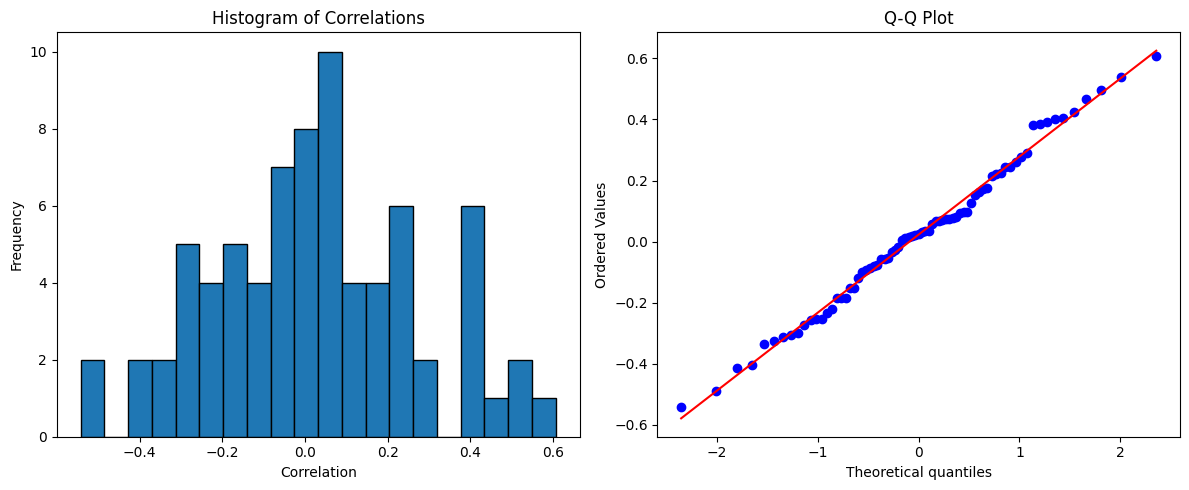


--- APA Style Results ---
Descriptive Statistics:
M = 0.02, SD = 0.25, 95% CI [-0.03, 0.08]
N = 75

Normality Assessment:
Shapiro-Wilk test: W(74) = 0.990, p = 0.810

Inference Statistics:
One-sample t-test: t(74) = 0.80, p = 0.428, d = 0.09
Wilcoxon signed-rank test: W = 1295.0, p = 0.492

APA Formatted Results Section:
The correlation coefficients (M = 0.02, SD = 0.25) were not significantly different from zero, t(74) = 0.80, p = 0.428, d = 0.09, 95% CI [-0.03, 0.08].


In [22]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Use the correct variable name from your code
all_correlations = all_correlations_pointnet_isthmuscingulate

# Number of values in all_correlations
num_correlations = len(all_correlations)

# Descriptive statistics
mean_correlation = np.mean(all_correlations)
std_correlation = np.std(all_correlations, ddof=1)  # Using N-1 for sample std dev

# Wilcoxon signed-rank test
wilcoxon_statistic, wilcoxon_p_value = stats.wilcoxon(all_correlations)

# One-sample t-test
t_statistic, t_p_value = stats.ttest_1samp(all_correlations, 0)

# Calculate Cohen's d for one-sample t-test
cohens_d = mean_correlation / std_correlation  # For one-sample t-test comparing to zero

# Calculate 95% confidence interval
degrees_freedom = num_correlations - 1
ci_95 = stats.t.interval(0.95, degrees_freedom, loc=mean_correlation, 
                         scale=std_correlation/np.sqrt(num_correlations))

# Check normality using Shapiro-Wilk test
shapiro_statistic, shapiro_p_value = stats.shapiro(all_correlations)

# Create Q-Q plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
ax1.hist(all_correlations, bins=20, edgecolor='black')
ax1.set_title('Histogram of Correlations')
ax1.set_xlabel('Correlation')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(all_correlations, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot")
plt.tight_layout()
plt.show()

# Format p-values according to APA
def format_p_value(p):
    if p < 0.001:
        return "p < .001"
    else:
        return f"p = {p:.3f}"

# Print statistical results in APA format
print("\n--- APA Style Results ---")
print("Descriptive Statistics:")
print(f"M = {mean_correlation:.2f}, SD = {std_correlation:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
print(f"N = {num_correlations}")

print("\nNormality Assessment:")
print(f"Shapiro-Wilk test: W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}")

print("\nInference Statistics:")
print(f"One-sample t-test: t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}")
print(f"Wilcoxon signed-rank test: W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}")

# APA formatted result (ready for copy-paste)
print("\nAPA Formatted Results Section:")
if shapiro_p_value >= 0.05:
    print(f"The correlation coefficients (M = {mean_correlation:.2f}, SD = {std_correlation:.2f}) were {'not ' if t_p_value >= 0.05 else ''}significantly different from zero, t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}].")
else:
    print(f"Due to the non-normal distribution of correlation coefficients (Shapiro-Wilk W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}), a Wilcoxon signed-rank test was conducted. The correlations (Mdn = {np.median(all_correlations):.2f}) were {'not ' if wilcoxon_p_value >= 0.05 else ''}significantly different from zero, W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}. For completeness, a t-test yielded t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}.")

## Pointnet parahippocampus

Number of predictions: 1350
Number of actual values: 1350
Mean correlation: 0.0083
Standard deviation of correlation: 0.2625


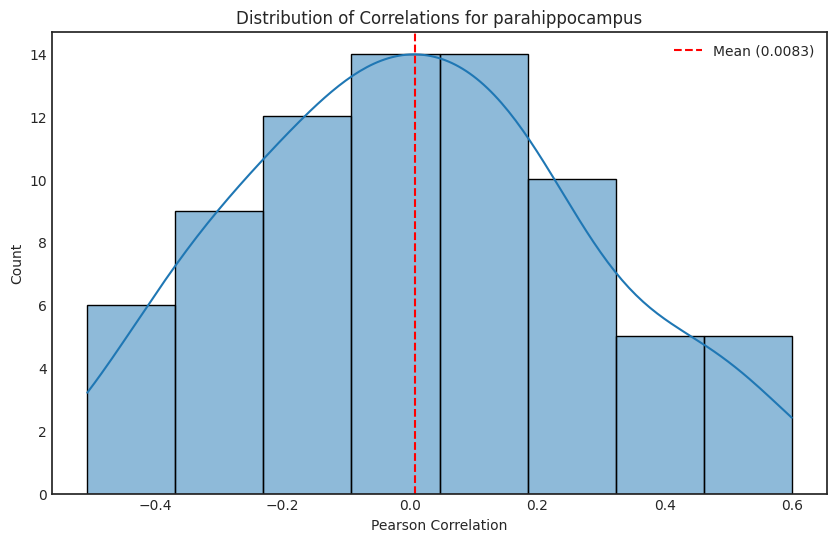

Overall correlation (APA format): r(1348) = -0.04, p = 0.1196


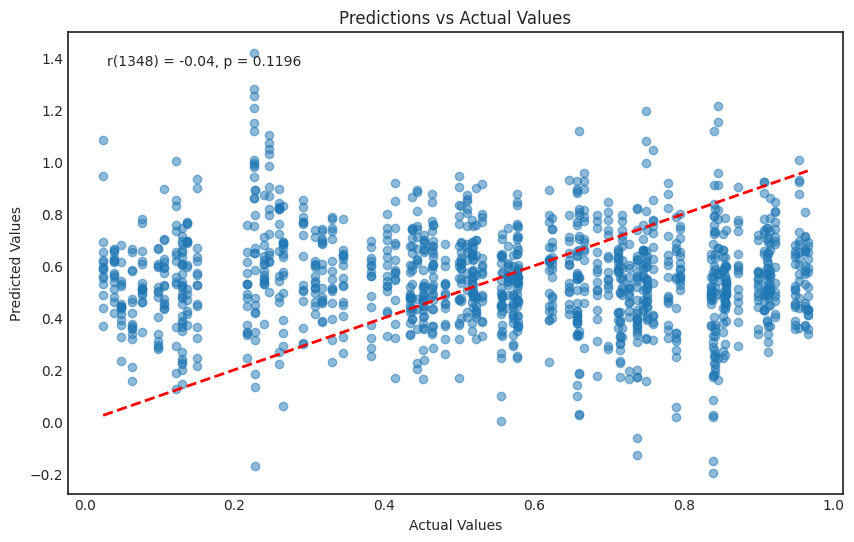

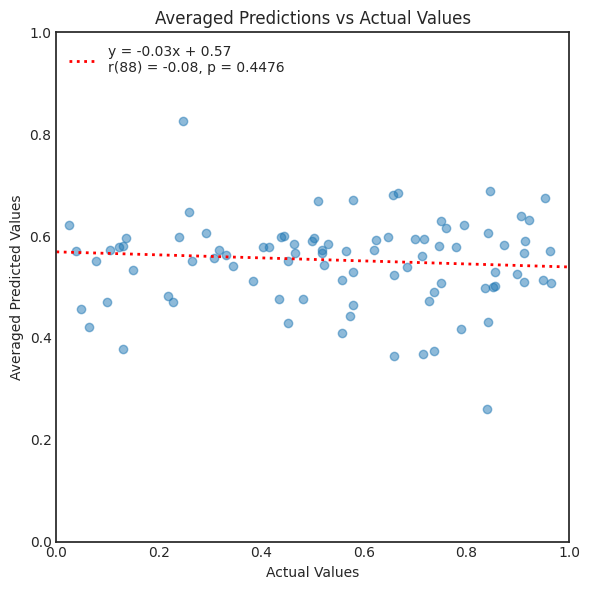

Correlation of averaged predictions (APA format): r(88) = -0.08, p = 0.4476
Regression line: y = -0.0297x + 0.5689

CREATING CSV FILE WITH ID MATCHING
Loaded target data with 90 rows
Created results DataFrame with 90 rows
Sample of results:
     ID  Actual  Prediction_1  Prediction_2  Prediction_3  Prediction_4  \
0  1064  0.0246        0.5938        0.6212        0.5306        1.0827   
1  1073  0.0389        0.5389        0.6132        0.4782        0.6307   
2  1020  0.0478        0.5224        0.5408        0.2322        0.6146   
3  1031  0.0636        0.6546        0.5792        0.3584        0.5837   
4  1044  0.0763        0.5128        0.5171        0.4897        0.7658   

   Prediction_5  Prediction_6  Prediction_7  Prediction_8  Prediction_9  \
0        0.9468        0.6921        0.3689        0.5882        0.5540   
1        0.6601        0.6635        0.4169        0.5110        0.5576   
2        0.6804        0.5318        0.3267        0.4433        0.4130   
3       

In [57]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import glob

def extract_data(file_content):
    folds_data = []
    for fold in range(1, 6):
        pattern = rf"Fold {fold}.*?Predicted tensors for test set:\s*tensor\((.*?)\).*?Target tensors for test set:\s*tensor\((.*?)\)"
        match = re.search(pattern, file_content, re.DOTALL)
        if match:
            predictions = eval(f"[{match.group(1)}]")
            targets = eval(f"[{match.group(2)}]")
            folds_data.append((predictions, targets))
    return folds_data

def process_file(filename):
    with open(filename, 'r') as file:
        content = file.read()
    return extract_data(content)

def calculate_correlations(folds_data):
    correlations = []
    for predictions, targets in folds_data:
        predictions_flat = [item for sublist in predictions for item in sublist]
        targets_flat = [item for sublist in targets for item in sublist]
        if len(predictions_flat) > 1 and len(targets_flat) > 1:
            corr, _ = stats.pearsonr(predictions_flat, targets_flat)
            correlations.append(corr)
    return correlations

# Process all files
all_correlations_pointnet_parahippocampus = []
all_predictions = []
all_actual = []

for filename in glob.glob('pointnet_results/job_output_parahippocampus_fs*.out'):
    if 'old' not in filename.lower() and 'extra' not in filename.lower():
        folds_data = process_file(filename)
        correlations = calculate_correlations(folds_data)
        all_correlations_pointnet_parahippocampus.extend(correlations)
        
        for predictions, targets in folds_data:
            all_predictions.extend([item for sublist in predictions for item in sublist])
            all_actual.extend([item for sublist in targets for item in sublist])

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_actual = np.array(all_actual)

print(f"Number of predictions: {len(all_predictions)}")
print(f"Number of actual values: {len(all_actual)}")

if len(all_predictions) == 0 or len(all_actual) == 0:
    print("No data extracted from files. Please check your input files and patterns.")
else:
    # Calculate mean and SD
    mean_correlation = np.mean(all_correlations_pointnet_parahippocampus)
    std_correlation = np.std(all_correlations_pointnet_parahippocampus)

    print(f"Mean correlation: {mean_correlation:.4f}")
    print(f"Standard deviation of correlation: {std_correlation:.4f}")

    # Plot distribution of correlations
    plt.figure(figsize=(10, 6))
    sns.histplot(all_correlations_pointnet_parahippocampus, kde=True)
    plt.title("Distribution of Correlations for parahippocampus")
    plt.xlabel("Pearson Correlation")
    plt.axvline(mean_correlation, color='r', linestyle='--', label=f"Mean ({mean_correlation:.4f})")
    plt.legend()
    # plt.savefig('pointnet_parahippocampus_correlation_distribution.svg', format='svg', bbox_inches='tight')
    plt.show()

    # Calculate correlation for all predictions
    if len(all_predictions) > 1 and len(all_actual) > 1:
        final_corr, final_p_value = stats.pearsonr(all_actual, all_predictions)
        df_final = len(all_actual) - 2  # degrees of freedom
        print(f"Overall correlation (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")

        # Create scatter plot of predictions vs actual values
        plt.figure(figsize=(10, 6))
        plt.scatter(all_actual, all_predictions, alpha=0.5)
        plt.title("Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.plot([min(all_actual), max(all_actual)], [min(all_actual), max(all_actual)], 'r--', lw=2)
        plt.text(0.05, 0.95, f'r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}', 
                 transform=plt.gca().transAxes, verticalalignment='top')
        #plt.savefig('pointnet_parahippocampus_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Calculate average predictions for each unique actual value
        predictions_by_actual = {}
        for actual, pred in zip(all_actual, all_predictions):
            if actual not in predictions_by_actual:
                predictions_by_actual[actual] = []
            predictions_by_actual[actual].append(pred)

        avg_predictions = []
        unique_actual = []
        for actual, preds in sorted(predictions_by_actual.items()):
            unique_actual.append(actual)
            avg_predictions.append(np.mean(preds))

        unique_actual = np.array(unique_actual)
        avg_predictions = np.array(avg_predictions)

        # Calculate correlation for averaged predictions
        avg_corr, avg_p_value = stats.pearsonr(unique_actual, avg_predictions)
        df_avg = len(unique_actual) - 2  # degrees of freedom
        
        # Calculate the linear regression line
        slope_reg, intercept_reg, _, _, _ = stats.linregress(unique_actual, avg_predictions)
        
        # Create scatter plot of averaged predictions vs actual values
        plt.figure(figsize=(6, 6))
        plt.scatter(unique_actual, avg_predictions, alpha=0.5)

        # Plot the regression line
        x_range = np.array([0, 1])
        y_range_reg = slope_reg * x_range + intercept_reg

        plt.plot(x_range, y_range_reg, 'r:', linewidth=2, 
                 label=f'y = {slope_reg:.2f}x + {intercept_reg:.2f}\nr({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}')

        plt.title("Averaged Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Averaged Predicted Values")
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # Adjust legend position and font size
        plt.legend(loc='upper left', fontsize='medium')

        # Adjust layout to prevent cutting off the legend
        plt.tight_layout()

        plt.savefig('final_plots/pointnet_parahippocampus_avg_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Print correlation and p-value in APA format
        print(f"Correlation of averaged predictions (APA format): r({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}")
        print(f"Regression line: y = {slope_reg:.4f}x + {intercept_reg:.4f}")


        # ===== NEW SECTION: Create CSV with ID matching =====
        print("\n" + "="*50)
        print("CREATING CSV FILE WITH ID MATCHING")
        print("="*50)
        
        try:
            # Load the target data to get IDs
            target_df = pd.read_csv('radiomic_results/DataAnalysisWith90Participants_Jupyter.csv')
            print(f"Loaded target data with {len(target_df)} rows")
            
            # Create initial DataFrame using existing all_actual and all_predictions
            results_df = pd.DataFrame({
                'Actual': all_actual,
                'Prediction': all_predictions
            })
            
            # Round actual values for matching
            results_df['Actual'] = results_df['Actual'].round(4)
            target_df['Model_Building_Total'] = target_df['Model_Building_Total'].round(4)
            
            # Create a mapping from actual values to IDs
            actual_to_id = dict(zip(target_df['Model_Building_Total'], target_df['ID']))
            
            # Add ID column by matching actual values
            results_df['ID'] = results_df['Actual'].map(actual_to_id)
            
            # Check for missing matches
            missing_matches = results_df['ID'].isna().sum()
            if missing_matches > 0:
                print(f"Warning: {missing_matches} actual values could not be matched with IDs")
                # Remove rows without ID matches
                results_df = results_df.dropna(subset=['ID'])
            
            # Group by ID and Actual to aggregate multiple predictions per participant
            grouped = results_df.groupby(['ID', 'Actual'])['Prediction'].apply(list).reset_index()
            
            # Create final DataFrame in the format of the first code
            final_results = []
            for _, row in grouped.iterrows():
                predictions = row['Prediction']
                record = {
                    'ID': int(row['ID']),
                    'Actual': row['Actual']
                }
                
                # Add individual predictions
                for i, pred in enumerate(predictions):
                    record[f'Prediction_{i+1}'] = round(pred, 4)
                
                # Add average prediction
                record['Average_Prediction'] = round(np.mean(predictions), 4)
                
                final_results.append(record)
            
            # Create final DataFrame
            results_df = pd.DataFrame(final_results)
            
            # Sort by actual values
            results_df = results_df.sort_values('Actual').reset_index(drop=True)
            
            # Reorder columns to match the first script's format
            prediction_cols = [col for col in results_df.columns if col.startswith('Prediction_')]
            column_order = ['ID', 'Actual'] + sorted(prediction_cols, key=lambda x: int(x.split('_')[1])) + ['Average_Prediction']
            results_df = results_df[column_order]
            
            print(f"Created results DataFrame with {len(results_df)} rows")
            print("Sample of results:")
            print(results_df.head())
            
            # Save to CSV
            output_filename = 'pointnet_parahippocampus_predictions_with_average_and_id.csv'
            results_df.to_csv(output_filename, index=False)
            print(f"\nResults saved to '{output_filename}'")
            print(f"File contains {len(results_df)} rows and {len(results_df.columns)} columns")
            
        except FileNotFoundError:
            print("Error: Could not find 'radiomic_results/DataAnalysisWith90Participants_Jupyter.csv'")
            print("Please ensure the file exists in the correct location.")
        except Exception as e:
            print(f"Error creating CSV file: {str(e)}")
            import traceback
            traceback.print_exc()
        
        # ===== END NEW SECTION =====

    else:
        print("Not enough data to calculate correlations or create plots.")

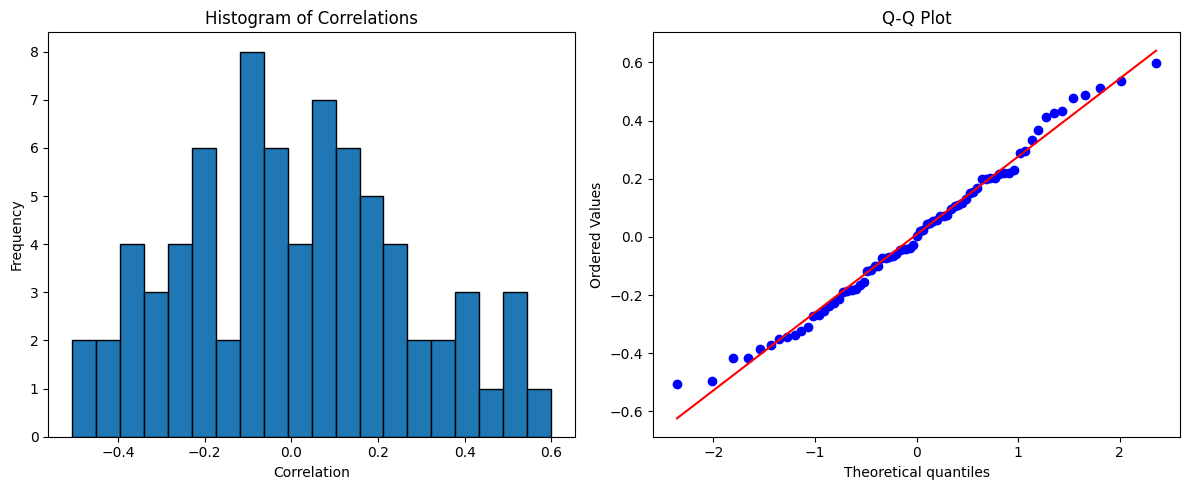


--- APA Style Results ---
Descriptive Statistics:
M = 0.01, SD = 0.26, 95% CI [-0.05, 0.07]
N = 75

Normality Assessment:
Shapiro-Wilk test: W(74) = 0.985, p = 0.497

Inference Statistics:
One-sample t-test: t(74) = 0.27, p = 0.786, d = 0.03
Wilcoxon signed-rank test: W = 1398.0, p = 0.887

APA Formatted Results Section:
The correlation coefficients (M = 0.01, SD = 0.26) were not significantly different from zero, t(74) = 0.27, p = 0.786, d = 0.03, 95% CI [-0.05, 0.07].


In [24]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Use the correct variable name from your code
all_correlations = all_correlations_pointnet_parahippocampus

# Number of values in all_correlations
num_correlations = len(all_correlations)

# Descriptive statistics
mean_correlation = np.mean(all_correlations)
std_correlation = np.std(all_correlations, ddof=1)  # Using N-1 for sample std dev

# Wilcoxon signed-rank test
wilcoxon_statistic, wilcoxon_p_value = stats.wilcoxon(all_correlations)

# One-sample t-test
t_statistic, t_p_value = stats.ttest_1samp(all_correlations, 0)

# Calculate Cohen's d for one-sample t-test
cohens_d = mean_correlation / std_correlation  # For one-sample t-test comparing to zero

# Calculate 95% confidence interval
degrees_freedom = num_correlations - 1
ci_95 = stats.t.interval(0.95, degrees_freedom, loc=mean_correlation, 
                         scale=std_correlation/np.sqrt(num_correlations))

# Check normality using Shapiro-Wilk test
shapiro_statistic, shapiro_p_value = stats.shapiro(all_correlations)

# Create Q-Q plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
ax1.hist(all_correlations, bins=20, edgecolor='black')
ax1.set_title('Histogram of Correlations')
ax1.set_xlabel('Correlation')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(all_correlations, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot")
plt.tight_layout()
plt.show()

# Format p-values according to APA
def format_p_value(p):
    if p < 0.001:
        return "p < .001"
    else:
        return f"p = {p:.3f}"

# Print statistical results in APA format
print("\n--- APA Style Results ---")
print("Descriptive Statistics:")
print(f"M = {mean_correlation:.2f}, SD = {std_correlation:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
print(f"N = {num_correlations}")

print("\nNormality Assessment:")
print(f"Shapiro-Wilk test: W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}")

print("\nInference Statistics:")
print(f"One-sample t-test: t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}")
print(f"Wilcoxon signed-rank test: W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}")

# APA formatted result (ready for copy-paste)
print("\nAPA Formatted Results Section:")
if shapiro_p_value >= 0.05:
    print(f"The correlation coefficients (M = {mean_correlation:.2f}, SD = {std_correlation:.2f}) were {'not ' if t_p_value >= 0.05 else ''}significantly different from zero, t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}].")
else:
    print(f"Due to the non-normal distribution of correlation coefficients (Shapiro-Wilk W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}), a Wilcoxon signed-rank test was conducted. The correlations (Mdn = {np.median(all_correlations):.2f}) were {'not ' if wilcoxon_p_value >= 0.05 else ''}significantly different from zero, W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}. For completeness, a t-test yielded t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}.")

## Pointnet entorhinal

Number of predictions: 1350
Number of actual values: 1350
Mean correlation: -0.0689
Standard deviation of correlation: 0.2149


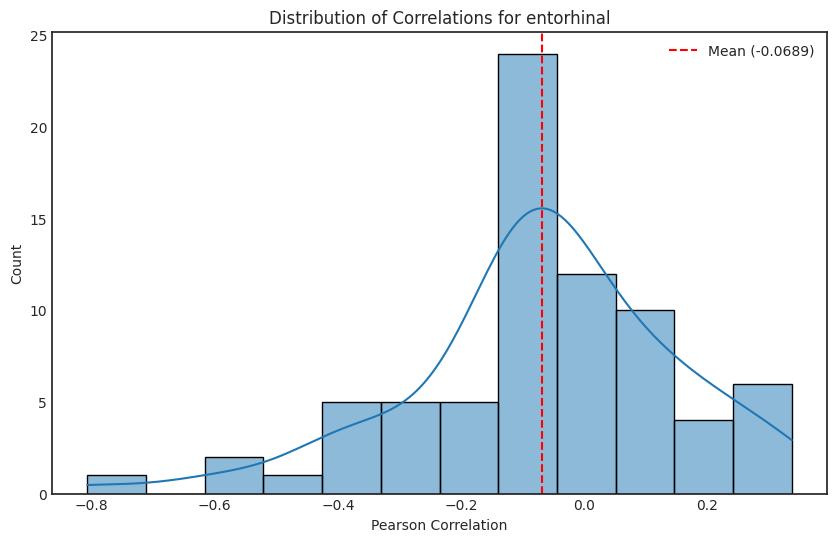

Overall correlation (APA format): r(1348) = -0.08, p = 0.0043


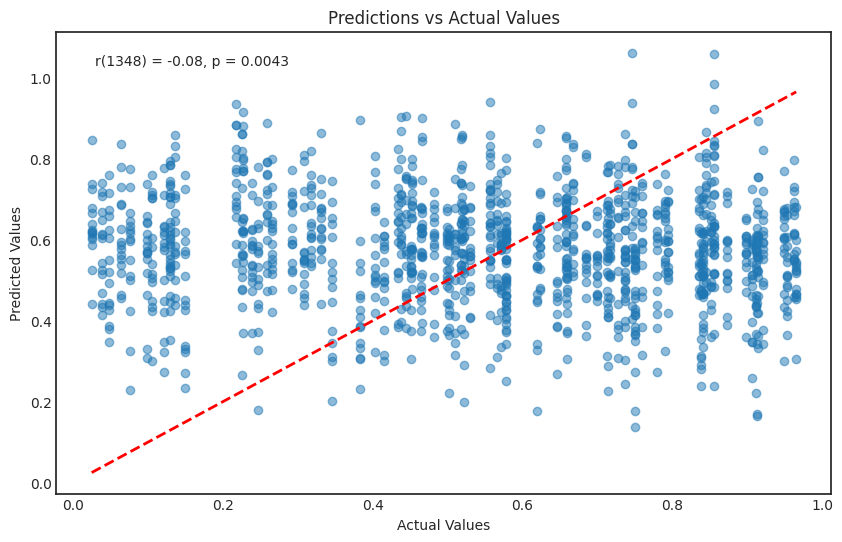

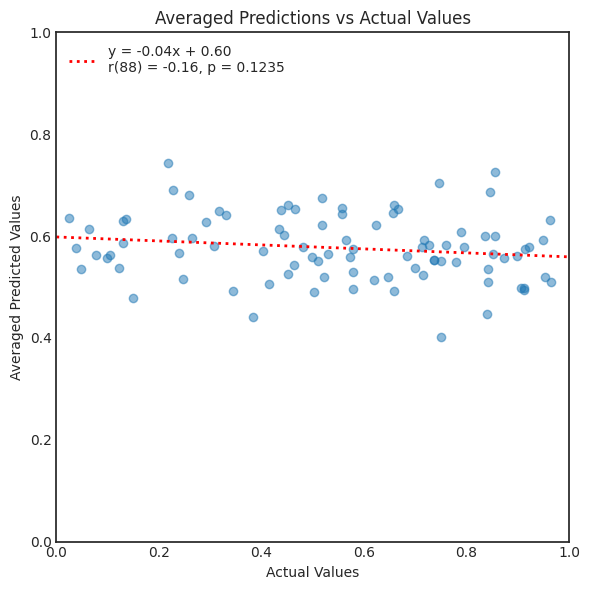

Correlation of averaged predictions (APA format): r(88) = -0.16, p = 0.1235
Regression line: y = -0.0391x + 0.5982

CREATING CSV FILE WITH ID MATCHING
Loaded target data with 90 rows
Created results DataFrame with 90 rows
Sample of results:
     ID  Actual  Prediction_1  Prediction_2  Prediction_3  Prediction_4  \
0  1064  0.0246        0.4403        0.6200        0.6064        0.6387   
1  1073  0.0389        0.5146        0.7413        0.5247        0.5436   
2  1020  0.0478        0.4941        0.6236        0.4449        0.4271   
3  1031  0.0636        0.5933        0.5764        0.5514        0.7306   
4  1044  0.0763        0.6334        0.7302        0.5106        0.2281   

   Prediction_5  Prediction_6  Prediction_7  Prediction_8  Prediction_9  \
0        0.5258        0.6782        0.7248        0.6027        0.5871   
1        0.7076        0.7187        0.4425        0.6037        0.6149   
2        0.4399        0.6588        0.6043        0.5489        0.5195   
3       

In [58]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import glob

def extract_data(file_content):
    folds_data = []
    for fold in range(1, 6):
        pattern = rf"Fold {fold}.*?Predicted tensors for test set:\s*tensor\((.*?)\).*?Target tensors for test set:\s*tensor\((.*?)\)"
        match = re.search(pattern, file_content, re.DOTALL)
        if match:
            predictions = eval(f"[{match.group(1)}]")
            targets = eval(f"[{match.group(2)}]")
            folds_data.append((predictions, targets))
    return folds_data

def process_file(filename):
    with open(filename, 'r') as file:
        content = file.read()
    return extract_data(content)

def calculate_correlations(folds_data):
    correlations = []
    for predictions, targets in folds_data:
        predictions_flat = [item for sublist in predictions for item in sublist]
        targets_flat = [item for sublist in targets for item in sublist]
        if len(predictions_flat) > 1 and len(targets_flat) > 1:
            corr, _ = stats.pearsonr(predictions_flat, targets_flat)
            correlations.append(corr)
    return correlations

# Process all files
all_correlations_pointnet_entorhinal = []
all_predictions = []
all_actual = []

for filename in glob.glob('pointnet_results/job_output_entorhinal_fs*.out'):
    if 'old' not in filename.lower() and 'extra' not in filename.lower():
        folds_data = process_file(filename)
        correlations = calculate_correlations(folds_data)
        all_correlations_pointnet_entorhinal.extend(correlations)
        
        for predictions, targets in folds_data:
            all_predictions.extend([item for sublist in predictions for item in sublist])
            all_actual.extend([item for sublist in targets for item in sublist])

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_actual = np.array(all_actual)

print(f"Number of predictions: {len(all_predictions)}")
print(f"Number of actual values: {len(all_actual)}")

if len(all_predictions) == 0 or len(all_actual) == 0:
    print("No data extracted from files. Please check your input files and patterns.")
else:
    # Calculate mean and SD
    mean_correlation = np.mean(all_correlations_pointnet_entorhinal)
    std_correlation = np.std(all_correlations_pointnet_entorhinal)

    print(f"Mean correlation: {mean_correlation:.4f}")
    print(f"Standard deviation of correlation: {std_correlation:.4f}")

    # Plot distribution of correlations
    plt.figure(figsize=(10, 6))
    sns.histplot(all_correlations_pointnet_entorhinal, kde=True)
    plt.title("Distribution of Correlations for entorhinal")
    plt.xlabel("Pearson Correlation")
    plt.axvline(mean_correlation, color='r', linestyle='--', label=f"Mean ({mean_correlation:.4f})")
    plt.legend()
    # plt.savefig('pointnet_entorhinal_correlation_distribution.svg', format='svg', bbox_inches='tight')
    plt.show()

    # Calculate correlation for all predictions
    if len(all_predictions) > 1 and len(all_actual) > 1:
        final_corr, final_p_value = stats.pearsonr(all_actual, all_predictions)
        df_final = len(all_actual) - 2  # degrees of freedom
        print(f"Overall correlation (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")

        # Create scatter plot of predictions vs actual values
        plt.figure(figsize=(10, 6))
        plt.scatter(all_actual, all_predictions, alpha=0.5)
        plt.title("Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.plot([min(all_actual), max(all_actual)], [min(all_actual), max(all_actual)], 'r--', lw=2)
        plt.text(0.05, 0.95, f'r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}', 
                 transform=plt.gca().transAxes, verticalalignment='top')
        #plt.savefig('pointnet_entorhinal_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Calculate average predictions for each unique actual value
        predictions_by_actual = {}
        for actual, pred in zip(all_actual, all_predictions):
            if actual not in predictions_by_actual:
                predictions_by_actual[actual] = []
            predictions_by_actual[actual].append(pred)

        avg_predictions = []
        unique_actual = []
        for actual, preds in sorted(predictions_by_actual.items()):
            unique_actual.append(actual)
            avg_predictions.append(np.mean(preds))

        unique_actual = np.array(unique_actual)
        avg_predictions = np.array(avg_predictions)

        # Calculate correlation for averaged predictions
        avg_corr, avg_p_value = stats.pearsonr(unique_actual, avg_predictions)
        df_avg = len(unique_actual) - 2  # degrees of freedom
        
        # Calculate the linear regression line
        slope_reg, intercept_reg, _, _, _ = stats.linregress(unique_actual, avg_predictions)
        
        # Create scatter plot of averaged predictions vs actual values
        plt.figure(figsize=(6, 6))
        plt.scatter(unique_actual, avg_predictions, alpha=0.5)

        # Plot the regression line
        x_range = np.array([0, 1])
        y_range_reg = slope_reg * x_range + intercept_reg

        plt.plot(x_range, y_range_reg, 'r:', linewidth=2, 
                 label=f'y = {slope_reg:.2f}x + {intercept_reg:.2f}\nr({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}')

        plt.title("Averaged Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Averaged Predicted Values")
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # Adjust legend position and font size
        plt.legend(loc='upper left', fontsize='medium')

        # Adjust layout to prevent cutting off the legend
        plt.tight_layout()

        plt.savefig('final_plots/pointnet_entorhinal_avg_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Print correlation and p-value in APA format
        print(f"Correlation of averaged predictions (APA format): r({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}")
        print(f"Regression line: y = {slope_reg:.4f}x + {intercept_reg:.4f}")


        # ===== NEW SECTION: Create CSV with ID matching =====
        print("\n" + "="*50)
        print("CREATING CSV FILE WITH ID MATCHING")
        print("="*50)
        
        try:
            # Load the target data to get IDs
            target_df = pd.read_csv('radiomic_results/DataAnalysisWith90Participants_Jupyter.csv')
            print(f"Loaded target data with {len(target_df)} rows")
            
            # Create initial DataFrame using existing all_actual and all_predictions
            results_df = pd.DataFrame({
                'Actual': all_actual,
                'Prediction': all_predictions
            })
            
            # Round actual values for matching
            results_df['Actual'] = results_df['Actual'].round(4)
            target_df['Model_Building_Total'] = target_df['Model_Building_Total'].round(4)
            
            # Create a mapping from actual values to IDs
            actual_to_id = dict(zip(target_df['Model_Building_Total'], target_df['ID']))
            
            # Add ID column by matching actual values
            results_df['ID'] = results_df['Actual'].map(actual_to_id)
            
            # Check for missing matches
            missing_matches = results_df['ID'].isna().sum()
            if missing_matches > 0:
                print(f"Warning: {missing_matches} actual values could not be matched with IDs")
                # Remove rows without ID matches
                results_df = results_df.dropna(subset=['ID'])
            
            # Group by ID and Actual to aggregate multiple predictions per participant
            grouped = results_df.groupby(['ID', 'Actual'])['Prediction'].apply(list).reset_index()
            
            # Create final DataFrame in the format of the first code
            final_results = []
            for _, row in grouped.iterrows():
                predictions = row['Prediction']
                record = {
                    'ID': int(row['ID']),
                    'Actual': row['Actual']
                }
                
                # Add individual predictions
                for i, pred in enumerate(predictions):
                    record[f'Prediction_{i+1}'] = round(pred, 4)
                
                # Add average prediction
                record['Average_Prediction'] = round(np.mean(predictions), 4)
                
                final_results.append(record)
            
            # Create final DataFrame
            results_df = pd.DataFrame(final_results)
            
            # Sort by actual values
            results_df = results_df.sort_values('Actual').reset_index(drop=True)
            
            # Reorder columns to match the first script's format
            prediction_cols = [col for col in results_df.columns if col.startswith('Prediction_')]
            column_order = ['ID', 'Actual'] + sorted(prediction_cols, key=lambda x: int(x.split('_')[1])) + ['Average_Prediction']
            results_df = results_df[column_order]
            
            print(f"Created results DataFrame with {len(results_df)} rows")
            print("Sample of results:")
            print(results_df.head())
            
            # Save to CSV
            output_filename = 'pointnet_entorhinal_predictions_with_average_and_id.csv'
            results_df.to_csv(output_filename, index=False)
            print(f"\nResults saved to '{output_filename}'")
            print(f"File contains {len(results_df)} rows and {len(results_df.columns)} columns")
            
        except FileNotFoundError:
            print("Error: Could not find 'radiomic_results/DataAnalysisWith90Participants_Jupyter.csv'")
            print("Please ensure the file exists in the correct location.")
        except Exception as e:
            print(f"Error creating CSV file: {str(e)}")
            import traceback
            traceback.print_exc()
        
        # ===== END NEW SECTION =====

    else:
        print("Not enough data to calculate correlations or create plots.")

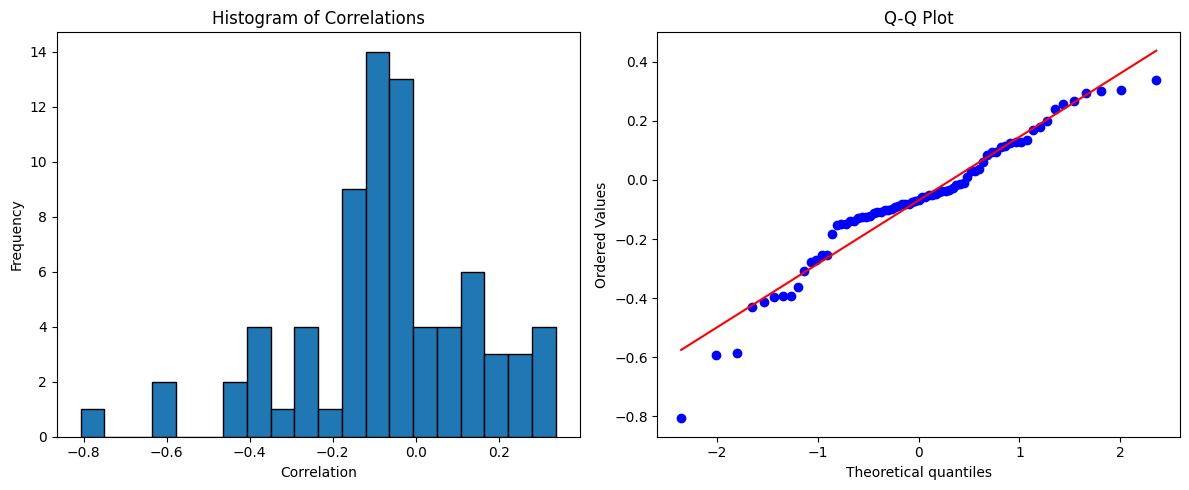


--- APA Style Results ---
Descriptive Statistics:
M = -0.07, SD = 0.22, 95% CI [-0.12, -0.02]
N = 75

Normality Assessment:
Shapiro-Wilk test: W(74) = 0.953, p = 0.007

Inference Statistics:
One-sample t-test: t(74) = -2.76, p = 0.007, d = -0.32
Wilcoxon signed-rank test: W = 954.0, p = 0.013

APA Formatted Results Section:
Due to the non-normal distribution of correlation coefficients (Shapiro-Wilk W(74) = 0.953, p = 0.007), a Wilcoxon signed-rank test was conducted. The correlations (Mdn = -0.07) were significantly different from zero, W = 954.0, p = 0.013. For completeness, a t-test yielded t(74) = -2.76, p = 0.007, d = -0.32.


In [26]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Use the correct variable name from your code
all_correlations = all_correlations_pointnet_entorhinal

# Number of values in all_correlations
num_correlations = len(all_correlations)

# Descriptive statistics
mean_correlation = np.mean(all_correlations)
std_correlation = np.std(all_correlations, ddof=1)  # Using N-1 for sample std dev

# Wilcoxon signed-rank test
wilcoxon_statistic, wilcoxon_p_value = stats.wilcoxon(all_correlations)

# One-sample t-test
t_statistic, t_p_value = stats.ttest_1samp(all_correlations, 0)

# Calculate Cohen's d for one-sample t-test
cohens_d = mean_correlation / std_correlation  # For one-sample t-test comparing to zero

# Calculate 95% confidence interval
degrees_freedom = num_correlations - 1
ci_95 = stats.t.interval(0.95, degrees_freedom, loc=mean_correlation, 
                         scale=std_correlation/np.sqrt(num_correlations))

# Check normality using Shapiro-Wilk test
shapiro_statistic, shapiro_p_value = stats.shapiro(all_correlations)

# Create Q-Q plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
ax1.hist(all_correlations, bins=20, edgecolor='black')
ax1.set_title('Histogram of Correlations')
ax1.set_xlabel('Correlation')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(all_correlations, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot")
plt.tight_layout()
plt.show()

# Format p-values according to APA
def format_p_value(p):
    if p < 0.001:
        return "p < .001"
    else:
        return f"p = {p:.3f}"

# Print statistical results in APA format
print("\n--- APA Style Results ---")
print("Descriptive Statistics:")
print(f"M = {mean_correlation:.2f}, SD = {std_correlation:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
print(f"N = {num_correlations}")

print("\nNormality Assessment:")
print(f"Shapiro-Wilk test: W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}")

print("\nInference Statistics:")
print(f"One-sample t-test: t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}")
print(f"Wilcoxon signed-rank test: W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}")

# APA formatted result (ready for copy-paste)
print("\nAPA Formatted Results Section:")
if shapiro_p_value >= 0.05:
    print(f"The correlation coefficients (M = {mean_correlation:.2f}, SD = {std_correlation:.2f}) were {'not ' if t_p_value >= 0.05 else ''}significantly different from zero, t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}].")
else:
    print(f"Due to the non-normal distribution of correlation coefficients (Shapiro-Wilk W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}), a Wilcoxon signed-rank test was conducted. The correlations (Mdn = {np.median(all_correlations):.2f}) were {'not ' if wilcoxon_p_value >= 0.05 else ''}significantly different from zero, W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}. For completeness, a t-test yielded t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}.")

# Pointnet whole brain

Number of predictions: 1350
Number of actual values: 1350
Mean correlation: 0.1776
Standard deviation of correlation: 0.2127


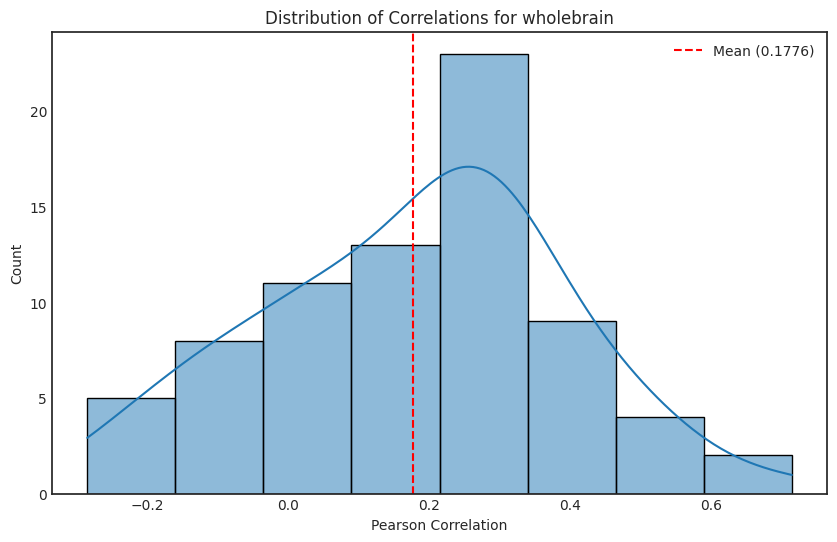

Overall correlation (APA format): r(1348) = 0.11, p = 0.0000


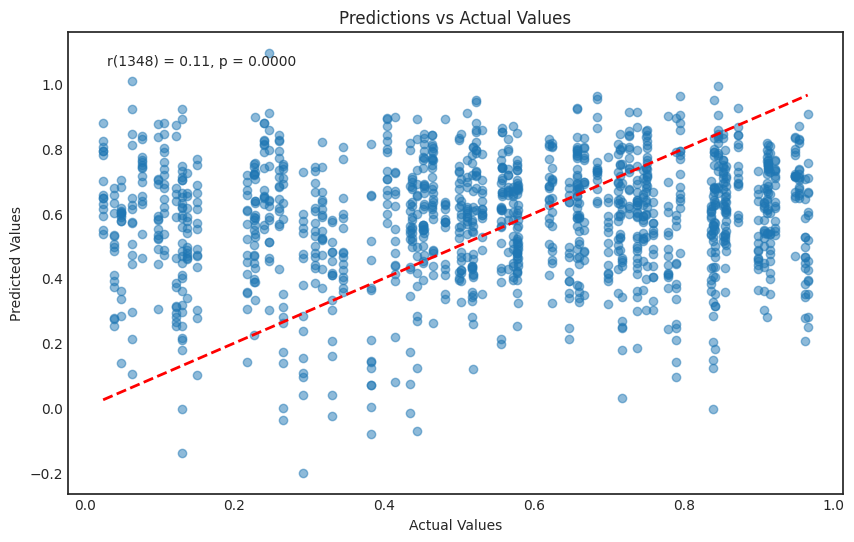

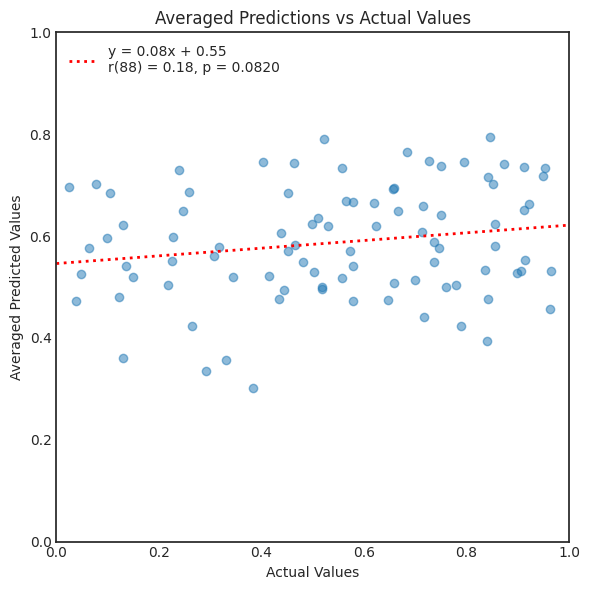

Correlation of averaged predictions (APA format): r(88) = 0.18, p = 0.0820
Regression line: y = 0.0754x + 0.5460

CREATING CSV FILE WITH ID MATCHING
Loaded target data with 90 rows
Created results DataFrame with 90 rows
Sample of results:
     ID  Actual  Prediction_1  Prediction_2  Prediction_3  Prediction_4  \
0  1064  0.0246        0.6464        0.6491        0.5937        0.6278   
1  1073  0.0389        0.3717        0.6005        0.5065        0.6786   
2  1020  0.0478        0.6007        0.6173        0.6076        0.5897   
3  1031  0.0636        0.9227        0.5717        0.5737        0.6482   
4  1044  0.0763        0.7650        0.7595        0.6967        0.6299   

   Prediction_5  Prediction_6  Prediction_7  Prediction_8  Prediction_9  \
0        0.7934        0.7918        0.5377        0.5486        0.6573   
1        0.4103        0.5309        0.4966        0.2537        0.5324   
2        0.6003        0.2825        0.3591        0.3363        0.6819   
3        0

In [59]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import glob

def extract_data(file_content):
    folds_data = []
    for fold in range(1, 6):
        pattern = rf"Fold {fold}.*?Predicted tensors for test set:\s*tensor\((.*?)\).*?Target tensors for test set:\s*tensor\((.*?)\)"
        match = re.search(pattern, file_content, re.DOTALL)
        if match:
            predictions = eval(f"[{match.group(1)}]")
            targets = eval(f"[{match.group(2)}]")
            folds_data.append((predictions, targets))
    return folds_data

def process_file(filename):
    with open(filename, 'r') as file:
        content = file.read()
    return extract_data(content)

def calculate_correlations(folds_data):
    correlations = []
    for predictions, targets in folds_data:
        predictions_flat = [item for sublist in predictions for item in sublist]
        targets_flat = [item for sublist in targets for item in sublist]
        if len(predictions_flat) > 1 and len(targets_flat) > 1:
            corr, _ = stats.pearsonr(predictions_flat, targets_flat)
            correlations.append(corr)
    return correlations

# Process all files
all_correlations_pointnet_wholebrain = []
all_predictions = []
all_actual = []

for filename in glob.glob('pointnet_results/job_output_wholebrain_fs*.out'):
    if 'old' not in filename.lower() and 'extra' not in filename.lower():
        folds_data = process_file(filename)
        correlations = calculate_correlations(folds_data)
        all_correlations_pointnet_wholebrain.extend(correlations)
        
        for predictions, targets in folds_data:
            all_predictions.extend([item for sublist in predictions for item in sublist])
            all_actual.extend([item for sublist in targets for item in sublist])

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_actual = np.array(all_actual)

print(f"Number of predictions: {len(all_predictions)}")
print(f"Number of actual values: {len(all_actual)}")

if len(all_predictions) == 0 or len(all_actual) == 0:
    print("No data extracted from files. Please check your input files and patterns.")
else:
    # Calculate mean and SD
    mean_correlation = np.mean(all_correlations_pointnet_wholebrain)
    std_correlation = np.std(all_correlations_pointnet_wholebrain)

    print(f"Mean correlation: {mean_correlation:.4f}")
    print(f"Standard deviation of correlation: {std_correlation:.4f}")

    # Plot distribution of correlations
    plt.figure(figsize=(10, 6))
    sns.histplot(all_correlations_pointnet_wholebrain, kde=True)
    plt.title("Distribution of Correlations for wholebrain")
    plt.xlabel("Pearson Correlation")
    plt.axvline(mean_correlation, color='r', linestyle='--', label=f"Mean ({mean_correlation:.4f})")
    plt.legend()
    # plt.savefig('pointnet_wholebrain_correlation_distribution.svg', format='svg', bbox_inches='tight')
    plt.show()

    # Calculate correlation for all predictions
    if len(all_predictions) > 1 and len(all_actual) > 1:
        final_corr, final_p_value = stats.pearsonr(all_actual, all_predictions)
        df_final = len(all_actual) - 2  # degrees of freedom
        print(f"Overall correlation (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")

        # Create scatter plot of predictions vs actual values
        plt.figure(figsize=(10, 6))
        plt.scatter(all_actual, all_predictions, alpha=0.5)
        plt.title("Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.plot([min(all_actual), max(all_actual)], [min(all_actual), max(all_actual)], 'r--', lw=2)
        plt.text(0.05, 0.95, f'r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}', 
                 transform=plt.gca().transAxes, verticalalignment='top')
        #plt.savefig('pointnet_wholebrain_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Calculate average predictions for each unique actual value
        predictions_by_actual = {}
        for actual, pred in zip(all_actual, all_predictions):
            if actual not in predictions_by_actual:
                predictions_by_actual[actual] = []
            predictions_by_actual[actual].append(pred)

        avg_predictions = []
        unique_actual = []
        for actual, preds in sorted(predictions_by_actual.items()):
            unique_actual.append(actual)
            avg_predictions.append(np.mean(preds))

        unique_actual = np.array(unique_actual)
        avg_predictions = np.array(avg_predictions)

        # Calculate correlation for averaged predictions
        avg_corr, avg_p_value = stats.pearsonr(unique_actual, avg_predictions)
        df_avg = len(unique_actual) - 2  # degrees of freedom
        
        # Calculate the linear regression line
        slope_reg, intercept_reg, _, _, _ = stats.linregress(unique_actual, avg_predictions)
        
        # Create scatter plot of averaged predictions vs actual values
        plt.figure(figsize=(6, 6))
        plt.scatter(unique_actual, avg_predictions, alpha=0.5)

        # Plot the regression line
        x_range = np.array([0, 1])
        y_range_reg = slope_reg * x_range + intercept_reg

        plt.plot(x_range, y_range_reg, 'r:', linewidth=2, 
                 label=f'y = {slope_reg:.2f}x + {intercept_reg:.2f}\nr({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}')

        plt.title("Averaged Predictions vs Actual Values")
        plt.xlabel("Actual Values")
        plt.ylabel("Averaged Predicted Values")
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        # Adjust legend position and font size
        plt.legend(loc='upper left', fontsize='medium')

        # Adjust layout to prevent cutting off the legend
        plt.tight_layout()

        plt.savefig('final_plots/pointnet_wholebrain_avg_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
        plt.show()

        # Print correlation and p-value in APA format
        print(f"Correlation of averaged predictions (APA format): r({df_avg}) = {avg_corr:.2f}, p = {avg_p_value:.4f}")
        print(f"Regression line: y = {slope_reg:.4f}x + {intercept_reg:.4f}")


        # ===== NEW SECTION: Create CSV with ID matching =====
        print("\n" + "="*50)
        print("CREATING CSV FILE WITH ID MATCHING")
        print("="*50)
        
        try:
            # Load the target data to get IDs
            target_df = pd.read_csv('radiomic_results/DataAnalysisWith90Participants_Jupyter.csv')
            print(f"Loaded target data with {len(target_df)} rows")
            
            # Create initial DataFrame using existing all_actual and all_predictions
            results_df = pd.DataFrame({
                'Actual': all_actual,
                'Prediction': all_predictions
            })
            
            # Round actual values for matching
            results_df['Actual'] = results_df['Actual'].round(4)
            target_df['Model_Building_Total'] = target_df['Model_Building_Total'].round(4)
            
            # Create a mapping from actual values to IDs
            actual_to_id = dict(zip(target_df['Model_Building_Total'], target_df['ID']))
            
            # Add ID column by matching actual values
            results_df['ID'] = results_df['Actual'].map(actual_to_id)
            
            # Check for missing matches
            missing_matches = results_df['ID'].isna().sum()
            if missing_matches > 0:
                print(f"Warning: {missing_matches} actual values could not be matched with IDs")
                # Remove rows without ID matches
                results_df = results_df.dropna(subset=['ID'])
            
            # Group by ID and Actual to aggregate multiple predictions per participant
            grouped = results_df.groupby(['ID', 'Actual'])['Prediction'].apply(list).reset_index()
            
            # Create final DataFrame in the format of the first code
            final_results = []
            for _, row in grouped.iterrows():
                predictions = row['Prediction']
                record = {
                    'ID': int(row['ID']),
                    'Actual': row['Actual']
                }
                
                # Add individual predictions
                for i, pred in enumerate(predictions):
                    record[f'Prediction_{i+1}'] = round(pred, 4)
                
                # Add average prediction
                record['Average_Prediction'] = round(np.mean(predictions), 4)
                
                final_results.append(record)
            
            # Create final DataFrame
            results_df = pd.DataFrame(final_results)
            
            # Sort by actual values
            results_df = results_df.sort_values('Actual').reset_index(drop=True)
            
            # Reorder columns to match the first script's format
            prediction_cols = [col for col in results_df.columns if col.startswith('Prediction_')]
            column_order = ['ID', 'Actual'] + sorted(prediction_cols, key=lambda x: int(x.split('_')[1])) + ['Average_Prediction']
            results_df = results_df[column_order]
            
            print(f"Created results DataFrame with {len(results_df)} rows")
            print("Sample of results:")
            print(results_df.head())
            
            # Save to CSV
            output_filename = 'pointnet_wholebrain_predictions_with_average_and_id.csv'
            results_df.to_csv(output_filename, index=False)
            print(f"\nResults saved to '{output_filename}'")
            print(f"File contains {len(results_df)} rows and {len(results_df.columns)} columns")
            
        except FileNotFoundError:
            print("Error: Could not find 'radiomic_results/DataAnalysisWith90Participants_Jupyter.csv'")
            print("Please ensure the file exists in the correct location.")
        except Exception as e:
            print(f"Error creating CSV file: {str(e)}")
            import traceback
            traceback.print_exc()
        
        # ===== END NEW SECTION =====

    else:
        print("Not enough data to calculate correlations or create plots.")

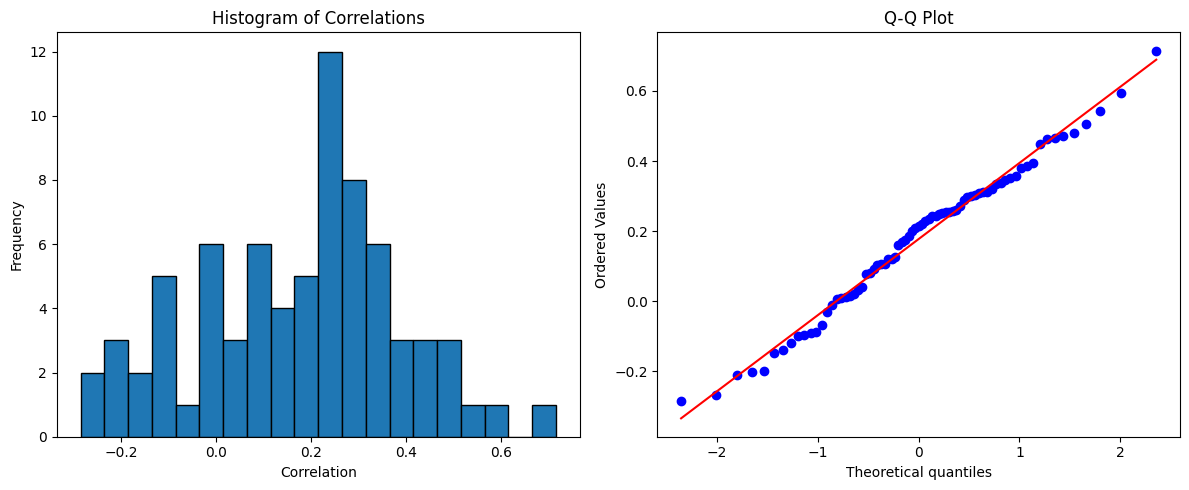


--- APA Style Results ---
Descriptive Statistics:
M = 0.18, SD = 0.21, 95% CI [0.13, 0.23]
N = 75

Normality Assessment:
Shapiro-Wilk test: W(74) = 0.986, p = 0.608

Inference Statistics:
One-sample t-test: t(74) = 7.18, p < .001, d = 0.83
Wilcoxon signed-rank test: W = 352.0, p < .001

APA Formatted Results Section:
The correlation coefficients (M = 0.18, SD = 0.21) were significantly different from zero, t(74) = 7.18, p < .001, d = 0.83, 95% CI [0.13, 0.23].


In [28]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Use the correct variable name from your code
all_correlations = all_correlations_pointnet_wholebrain

# Number of values in all_correlations
num_correlations = len(all_correlations)

# Descriptive statistics
mean_correlation = np.mean(all_correlations)
std_correlation = np.std(all_correlations, ddof=1)  # Using N-1 for sample std dev

# Wilcoxon signed-rank test
wilcoxon_statistic, wilcoxon_p_value = stats.wilcoxon(all_correlations)

# One-sample t-test
t_statistic, t_p_value = stats.ttest_1samp(all_correlations, 0)

# Calculate Cohen's d for one-sample t-test
cohens_d = mean_correlation / std_correlation  # For one-sample t-test comparing to zero

# Calculate 95% confidence interval
degrees_freedom = num_correlations - 1
ci_95 = stats.t.interval(0.95, degrees_freedom, loc=mean_correlation, 
                         scale=std_correlation/np.sqrt(num_correlations))

# Check normality using Shapiro-Wilk test
shapiro_statistic, shapiro_p_value = stats.shapiro(all_correlations)

# Create Q-Q plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
ax1.hist(all_correlations, bins=20, edgecolor='black')
ax1.set_title('Histogram of Correlations')
ax1.set_xlabel('Correlation')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(all_correlations, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot")
plt.tight_layout()
plt.show()

# Format p-values according to APA
def format_p_value(p):
    if p < 0.001:
        return "p < .001"
    else:
        return f"p = {p:.3f}"

# Print statistical results in APA format
print("\n--- APA Style Results ---")
print("Descriptive Statistics:")
print(f"M = {mean_correlation:.2f}, SD = {std_correlation:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
print(f"N = {num_correlations}")

print("\nNormality Assessment:")
print(f"Shapiro-Wilk test: W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}")

print("\nInference Statistics:")
print(f"One-sample t-test: t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}")
print(f"Wilcoxon signed-rank test: W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}")

# APA formatted result (ready for copy-paste)
print("\nAPA Formatted Results Section:")
if shapiro_p_value >= 0.05:
    print(f"The correlation coefficients (M = {mean_correlation:.2f}, SD = {std_correlation:.2f}) were {'not ' if t_p_value >= 0.05 else ''}significantly different from zero, t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}].")
else:
    print(f"Due to the non-normal distribution of correlation coefficients (Shapiro-Wilk W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}), a Wilcoxon signed-rank test was conducted. The correlations (Mdn = {np.median(all_correlations):.2f}) were {'not ' if wilcoxon_p_value >= 0.05 else ''}significantly different from zero, W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}. For completeness, a t-test yielded t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}.")

# Pyradiomics hippocampus

Running seed 0
Running seed 1
Running seed 2
Running seed 3
Running seed 4
Running seed 5
Running seed 6
Running seed 7
Running seed 8
Running seed 9
Running seed 10
Running seed 11
Running seed 12
Running seed 13
Running seed 14
Top 20 Most Important Features:
                                               feature  importance
88                    original_glszm_GrayLevelVariance    0.051329
97       original_glszm_SmallAreaHighGrayLevelEmphasis    0.030469
94                original_glszm_SizeZoneNonUniformity    0.029920
96                    original_glszm_SmallAreaEmphasis    0.025777
34                          original_glcm_ClusterShade    0.025410
68   original_gldm_SmallDependenceHighGrayLevelEmph...    0.023572
10                           original_shape_Sphericity    0.022799
95      original_glszm_SizeZoneNonUniformityNormalized    0.022352
4               original_shape_Maximum2DDiameterColumn    0.021124
12                   original_shape_SurfaceVolumeRatio    0.020773
9

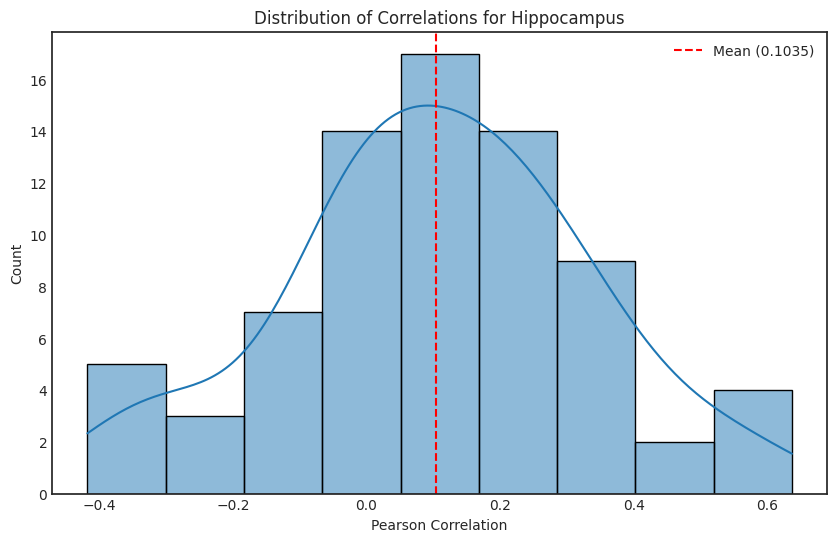

Overall correlation (APA format): r(88) = 0.18, p = 0.0913


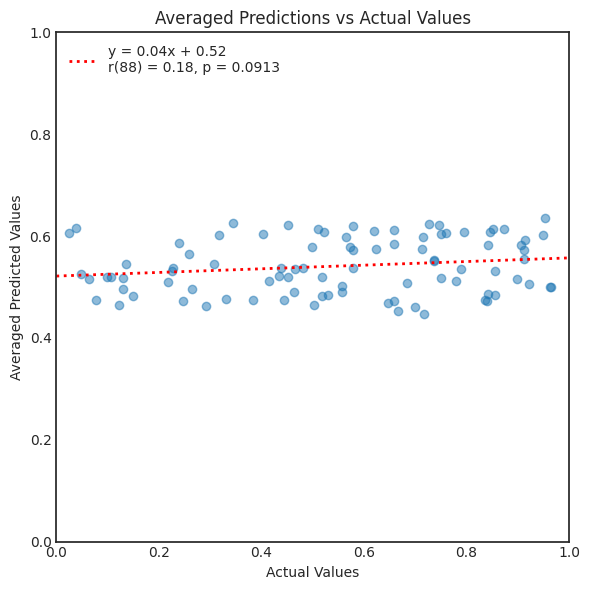

Correlation of averaged predictions (APA format): r(88) = 0.18, p = 0.0913
Regression line: y = 0.0356x + 0.5214

Running verification checks:
✓ Number of rows match
✓ All IDs are present and correct
Mismatched values:
      Original  Results  Difference  Is_Close
ID                                           
1002  0.684642   0.6846    0.000042     False
1003  0.259369   0.2594    0.000031     False
1004  0.855580   0.8556    0.000020     False
1005  0.657692   0.6577    0.000008     False
1006  0.105524   0.1055    0.000024     False
...        ...      ...         ...       ...
1088  0.914986   0.9150    0.000014     False
1089  0.779103   0.7791    0.000003     False
1090  0.227116   0.2271    0.000016     False
1091  0.578327   0.5783    0.000027     False
1092  0.451287   0.4513    0.000013     False

[89 rows x 4 columns]
All differences are within the specified tolerance.
✓ Actual values match with original data (accounting for rounding)
✓ 'Actual' column is correctly sorted
✓ '

In [60]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def run_cv_with_seed(X, y, seed, n_splits=5):
    np.random.seed(seed)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    correlations = []
    p_values = []
    all_predictions = []
    all_actual = []
    feature_importances = np.zeros(X.shape[1])

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        rf_model = RandomForestRegressor(n_estimators=100, random_state=seed)
        rf_model.fit(X_train_scaled, y_train)
        
        y_pred = rf_model.predict(X_test_scaled)
        
        corr, p_value = stats.pearsonr(y_test, y_pred)
        correlations.append(corr)
        p_values.append(p_value)
        all_predictions.extend(y_pred)
        all_actual.extend(y_test)
        
        feature_importances += rf_model.feature_importances_
    
    feature_importances /= n_splits
    
    return correlations, p_values, all_predictions, all_actual, feature_importances

def verify_predictions(original_data, results_df, n_seeds):
    print("\nRunning verification checks:")
    
    # 1. Check if the number of rows matches
    assert len(original_data) == len(results_df), "Number of rows mismatch"
    print("✓ Number of rows match")
    
    # 2. Verify that all IDs in the results are present in the original data
    assert set(results_df['ID']) == set(original_data['ID']), "ID mismatch"
    print("✓ All IDs are present and correct")
    
    # 3. Check if 'Actual' values match between original data and results, accounting for rounding
    original_actual = original_data.set_index('ID')['Model_Building_Total'].round(6)
    results_actual = results_df.set_index('ID')['Actual'].round(6)
    
    # Use a more lenient comparison
    tolerance = 1e-4  # Increased tolerance
    is_close = np.isclose(original_actual, results_actual, atol=tolerance, rtol=0)
    mismatch = ~is_close
    
    if mismatch.any():
        print("Mismatched values:")
        mismatched_df = pd.DataFrame({
            'Original': original_actual[mismatch],
            'Results': results_actual[mismatch],
            'Difference': (original_actual[mismatch] - results_actual[mismatch]).abs(),
            'Is_Close': is_close[mismatch]
        })
        print(mismatched_df)
        
        if mismatched_df['Difference'].max() <= tolerance:
            print("All differences are within the specified tolerance.")
            print("✓ Actual values match with original data (accounting for rounding)")
        else:
            raise AssertionError("Actual values mismatch")
    else:
        print("✓ Actual values match with original data (accounting for rounding)")
    
    # 4. Verify that 'Actual' column is sorted
    assert all(results_df['Actual'].diff()[1:] >= -1e-9), "'Actual' column is not sorted"
    print("✓ 'Actual' column is correctly sorted")
    
    # 5. Check if 'Average_Prediction' is the average of all individual predictions
    calculated_avg = results_df[[f'Prediction_{i+1}' for i in range(n_seeds)]].mean(axis=1)
    assert np.allclose(calculated_avg, results_df['Average_Prediction'], atol=1e-4), "Average prediction mismatch"
    print("✓ 'Average_Prediction' is correctly calculated")
    
    print("All verification checks passed successfully!")

# Load and prepare data
radiomics_df = pd.read_csv('radiomic_results/mri_radiomics_features_regions_17_53_hippocampus_combined_default.csv')
target_df = pd.read_csv('radiomic_results/DataAnalysisWith90Participants_Jupyter.csv')

radiomics_df['ID'] = radiomics_df['subject_id'].str[-4:].astype(int)
merged_df = pd.merge(radiomics_df, target_df[['ID', 'Model_Building_Total']], on='ID', how='inner')

feature_columns = [col for col in merged_df.columns if col.startswith('original_')]
X = merged_df[feature_columns]
y = merged_df['Model_Building_Total']

X = X.select_dtypes(include=[np.number])

# Run multiple seeds
n_seeds = 15
all_correlations_pyradiomics_hippocampus = []
all_p_values = []
all_predictions = []
all_actual = []
all_feature_importances = np.zeros(X.shape[1])

for seed in range(n_seeds):
    print(f"Running seed {seed}")
    correlations, p_values, predictions, actual, feature_importances = run_cv_with_seed(X, y, seed)
    all_correlations_pyradiomics_hippocampus.extend(correlations)
    all_p_values.extend(p_values)
    all_predictions.append(predictions)
    all_actual = actual  # This will be the same for all runs
    all_feature_importances += feature_importances

# Average feature importances across seeds
all_feature_importances /= n_seeds

# Get the 20 most important features
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': all_feature_importances})
top_20_features = feature_importance_df.sort_values('importance', ascending=False).head(20)

print("Top 20 Most Important Features:")
print(top_20_features)

# Analyze results
mean_correlation = np.mean(all_correlations_pyradiomics_hippocampus)
std_correlation = np.std(all_correlations_pyradiomics_hippocampus)
mean_p_value = np.mean(all_p_values)

print(f"Mean correlation: {mean_correlation:.4f}")
print(f"Mean p-value: {mean_p_value:.4f}")
print(f"Standard deviation of correlation: {std_correlation:.4f}")

# Plot distribution of correlations
plt.figure(figsize=(10, 6))
sns.histplot(all_correlations_pyradiomics_hippocampus, kde=True)
plt.title("Distribution of Correlations for Hippocampus")
plt.xlabel("Pearson Correlation")
plt.axvline(mean_correlation, color='r', linestyle='--', label=f"Mean ({mean_correlation:.4f})")
plt.legend()
# plt.savefig('pyradiomics_random_forest_hippocampus_correlation.svg', format='svg', bbox_inches='tight')
plt.show()

# Average predictions across all seeds
avg_predictions = np.mean(all_predictions, axis=0)

# Calculate correlation for averaged predictions
final_corr, final_p_value = stats.pearsonr(all_actual, avg_predictions)
df_final = len(all_actual) - 2  # degrees of freedom

# Print correlation in APA format
print(f"Overall correlation (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")

# Calculate the linear regression line
slope_reg, intercept_reg, _, _, _ = stats.linregress(all_actual, avg_predictions)

# Create scatter plot of averaged predictions vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(all_actual, avg_predictions, alpha=0.5)

# Plot the regression line
x_range = np.array([0, 1])
y_range_reg = slope_reg * x_range + intercept_reg

plt.plot(x_range, y_range_reg, 'r:', linewidth=2, 
         label=f'y = {slope_reg:.2f}x + {intercept_reg:.2f}\nr({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}')

plt.title("Averaged Predictions vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Averaged Predicted Values")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='upper left', fontsize='medium')
plt.tight_layout()
plt.savefig('pyradiomics_random_forest_hippocampus_avg_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
plt.show()

# Print correlation and p-value in APA format
print(f"Correlation of averaged predictions (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")
print(f"Regression line: y = {slope_reg:.4f}x + {intercept_reg:.4f}")

# Create initial DataFrame without IDs
results_df = pd.DataFrame({
    'Actual': all_actual,
    'Average_Prediction': avg_predictions
})

# Add individual predictions as columns
for i in range(n_seeds):
    results_df[f'Prediction_{i+1}'] = all_predictions[i]

# Round all numeric columns to 4 decimal points
numeric_columns = results_df.select_dtypes(include=[np.number]).columns
results_df[numeric_columns] = results_df[numeric_columns].round(4)

# Create a temporary DataFrame with actual values and IDs
temp_df = pd.DataFrame({
    'Actual': merged_df['Model_Building_Total'].round(4),
    'ID': merged_df['ID']
})

# Sort both DataFrames by the 'Actual' values to ensure correct matching
results_df = results_df.sort_values('Actual').reset_index(drop=True)
temp_df = temp_df.sort_values('Actual').reset_index(drop=True)

# Add the ID column to results_df
results_df.insert(0, 'ID', temp_df['ID'])

# Sort the entire DataFrame by the 'Actual' column
results_df = results_df.sort_values('Actual').reset_index(drop=True)

# Reorder columns
column_order = ['ID', 'Actual'] + [f'Prediction_{i+1}' for i in range(n_seeds)] + ['Average_Prediction']
results_df = results_df[column_order]

# Run the verification
verify_predictions(merged_df, results_df, n_seeds)

# Save results to CSV (commented out)
#output_filename = 'random_forest_pyradiomics_hippocampus_predictions_with_average_and_id.csv'
#results_df.to_csv(output_filename, index=False)
# print(f"\nResults saved to '{output_filename}'")

print("\nPlease check the output files and the statistics above to ensure the process was successful.")

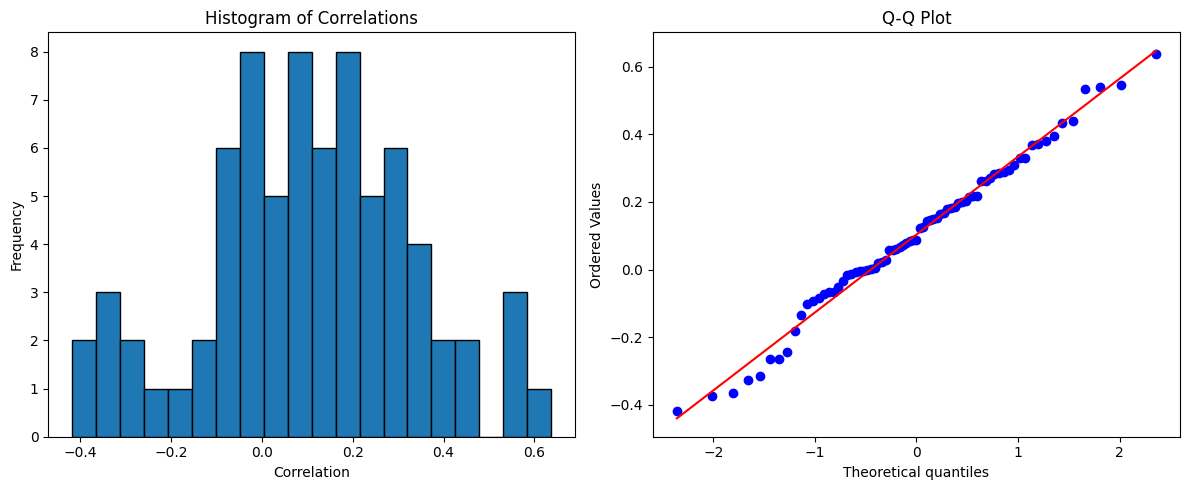


--- APA Style Results ---
Descriptive Statistics:
M = 0.10, SD = 0.23, 95% CI [0.05, 0.16]
N = 75

Normality Assessment:
Shapiro-Wilk test: W(74) = 0.988, p = 0.697

Inference Statistics:
One-sample t-test: t(74) = 3.94, p < .001, d = 0.46
Wilcoxon signed-rank test: W = 729.0, p < .001

APA Formatted Results Section:
The correlation coefficients (M = 0.10, SD = 0.23) were significantly different from zero, t(74) = 3.94, p < .001, d = 0.46, 95% CI [0.05, 0.16].


In [30]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Use the correct variable name from your code
all_correlations = all_correlations_pyradiomics_hippocampus

# Number of values in all_correlations
num_correlations = len(all_correlations)

# Descriptive statistics
mean_correlation = np.mean(all_correlations)
std_correlation = np.std(all_correlations, ddof=1)  # Using N-1 for sample std dev

# Wilcoxon signed-rank test
wilcoxon_statistic, wilcoxon_p_value = stats.wilcoxon(all_correlations)

# One-sample t-test
t_statistic, t_p_value = stats.ttest_1samp(all_correlations, 0)

# Calculate Cohen's d for one-sample t-test
cohens_d = mean_correlation / std_correlation  # For one-sample t-test comparing to zero

# Calculate 95% confidence interval
degrees_freedom = num_correlations - 1
ci_95 = stats.t.interval(0.95, degrees_freedom, loc=mean_correlation, 
                         scale=std_correlation/np.sqrt(num_correlations))

# Check normality using Shapiro-Wilk test
shapiro_statistic, shapiro_p_value = stats.shapiro(all_correlations)

# Create Q-Q plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
ax1.hist(all_correlations, bins=20, edgecolor='black')
ax1.set_title('Histogram of Correlations')
ax1.set_xlabel('Correlation')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(all_correlations, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot")
plt.tight_layout()
plt.show()

# Format p-values according to APA
def format_p_value(p):
    if p < 0.001:
        return "p < .001"
    else:
        return f"p = {p:.3f}"

# Print statistical results in APA format
print("\n--- APA Style Results ---")
print("Descriptive Statistics:")
print(f"M = {mean_correlation:.2f}, SD = {std_correlation:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
print(f"N = {num_correlations}")

print("\nNormality Assessment:")
print(f"Shapiro-Wilk test: W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}")

print("\nInference Statistics:")
print(f"One-sample t-test: t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}")
print(f"Wilcoxon signed-rank test: W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}")

# APA formatted result (ready for copy-paste)
print("\nAPA Formatted Results Section:")
if shapiro_p_value >= 0.05:
    print(f"The correlation coefficients (M = {mean_correlation:.2f}, SD = {std_correlation:.2f}) were {'not ' if t_p_value >= 0.05 else ''}significantly different from zero, t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}].")
else:
    print(f"Due to the non-normal distribution of correlation coefficients (Shapiro-Wilk W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}), a Wilcoxon signed-rank test was conducted. The correlations (Mdn = {np.median(all_correlations):.2f}) were {'not ' if wilcoxon_p_value >= 0.05 else ''}significantly different from zero, W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}. For completeness, a t-test yielded t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}.")

# Pyradiomics thalamus

Running seed 0
Running seed 1
Running seed 2
Running seed 3
Running seed 4
Running seed 5
Running seed 6
Running seed 7
Running seed 8
Running seed 9
Running seed 10
Running seed 11
Running seed 12
Running seed 13
Running seed 14
Top 20 Most Important Features:
                                              feature  importance
75        original_glrlm_LongRunHighGrayLevelEmphasis    0.052878
31                       original_firstorder_Variance    0.051602
57              original_gldm_DependenceNonUniformity    0.037600
78                          original_glrlm_RunEntropy    0.030575
21          original_firstorder_MeanAbsoluteDeviation    0.028611
83                    original_glrlm_ShortRunEmphasis    0.022256
85        original_glrlm_ShortRunLowGrayLevelEmphasis    0.021016
29                    original_firstorder_TotalEnergy    0.019006
9                      original_shape_MinorAxisLength    0.018654
16                         original_firstorder_Energy    0.018496
10          

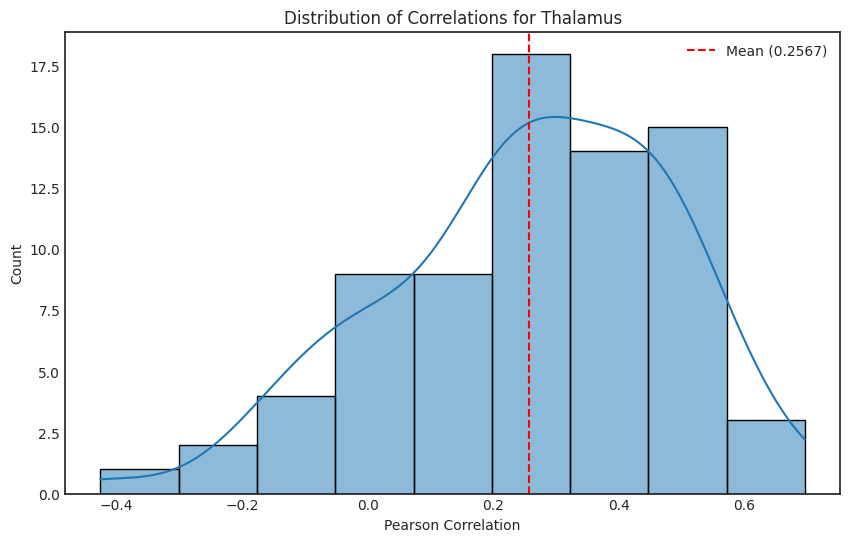

Overall correlation (APA format): r(88) = 0.21, p = 0.0458


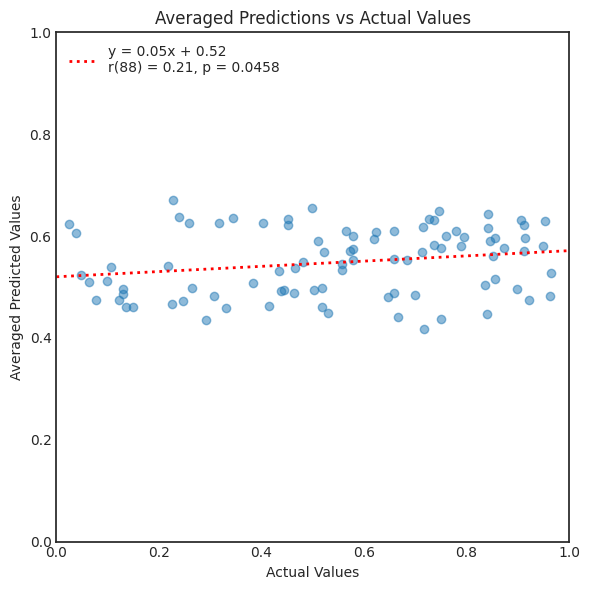

Correlation of averaged predictions (APA format): r(88) = 0.21, p = 0.0458
Regression line: y = 0.0513x + 0.5200

Running verification checks:
✓ Number of rows match
✓ All IDs are present and correct
Mismatched values:
      Original  Results  Difference  Is_Close
ID                                           
1002  0.684642   0.6846    0.000042     False
1003  0.259369   0.2594    0.000031     False
1004  0.855580   0.8556    0.000020     False
1005  0.657692   0.6577    0.000008     False
1006  0.105524   0.1055    0.000024     False
...        ...      ...         ...       ...
1088  0.914986   0.9150    0.000014     False
1089  0.779103   0.7791    0.000003     False
1090  0.227116   0.2271    0.000016     False
1091  0.578327   0.5783    0.000027     False
1092  0.451287   0.4513    0.000013     False

[89 rows x 4 columns]
All differences are within the specified tolerance.
✓ Actual values match with original data (accounting for rounding)
✓ 'Actual' column is correctly sorted
✓ '

In [61]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def run_cv_with_seed(X, y, seed, n_splits=5):
    np.random.seed(seed)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    correlations = []
    p_values = []
    all_predictions = []
    all_actual = []
    feature_importances = np.zeros(X.shape[1])

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        rf_model = RandomForestRegressor(n_estimators=100, random_state=seed)
        rf_model.fit(X_train_scaled, y_train)
        
        y_pred = rf_model.predict(X_test_scaled)
        
        corr, p_value = stats.pearsonr(y_test, y_pred)
        correlations.append(corr)
        p_values.append(p_value)
        all_predictions.extend(y_pred)
        all_actual.extend(y_test)
        
        feature_importances += rf_model.feature_importances_
    
    feature_importances /= n_splits
    
    return correlations, p_values, all_predictions, all_actual, feature_importances

def verify_predictions(original_data, results_df, n_seeds):
    print("\nRunning verification checks:")
    
    # 1. Check if the number of rows matches
    assert len(original_data) == len(results_df), "Number of rows mismatch"
    print("✓ Number of rows match")
    
    # 2. Verify that all IDs in the results are present in the original data
    assert set(results_df['ID']) == set(original_data['ID']), "ID mismatch"
    print("✓ All IDs are present and correct")
    
    # 3. Check if 'Actual' values match between original data and results, accounting for rounding
    original_actual = original_data.set_index('ID')['Model_Building_Total'].round(6)
    results_actual = results_df.set_index('ID')['Actual'].round(6)
    
    # Use a more lenient comparison
    tolerance = 1e-4  # Increased tolerance
    is_close = np.isclose(original_actual, results_actual, atol=tolerance, rtol=0)
    mismatch = ~is_close
    
    if mismatch.any():
        print("Mismatched values:")
        mismatched_df = pd.DataFrame({
            'Original': original_actual[mismatch],
            'Results': results_actual[mismatch],
            'Difference': (original_actual[mismatch] - results_actual[mismatch]).abs(),
            'Is_Close': is_close[mismatch]
        })
        print(mismatched_df)
        
        if mismatched_df['Difference'].max() <= tolerance:
            print("All differences are within the specified tolerance.")
            print("✓ Actual values match with original data (accounting for rounding)")
        else:
            raise AssertionError("Actual values mismatch")
    else:
        print("✓ Actual values match with original data (accounting for rounding)")
    
    # 4. Verify that 'Actual' column is sorted
    assert all(results_df['Actual'].diff()[1:] >= -1e-9), "'Actual' column is not sorted"
    print("✓ 'Actual' column is correctly sorted")
    
    # 5. Check if 'Average_Prediction' is the average of all individual predictions
    calculated_avg = results_df[[f'Prediction_{i+1}' for i in range(n_seeds)]].mean(axis=1)
    assert np.allclose(calculated_avg, results_df['Average_Prediction'], atol=1e-4), "Average prediction mismatch"
    print("✓ 'Average_Prediction' is correctly calculated")
    
    print("All verification checks passed successfully!")

# Load and prepare data
radiomics_df = pd.read_csv('radiomic_results/mri_radiomics_features_regions_10_49_thalamus_combined_default.csv')
target_df = pd.read_csv('radiomic_results/DataAnalysisWith90Participants_Jupyter.csv')

radiomics_df['ID'] = radiomics_df['subject_id'].str[-4:].astype(int)
merged_df = pd.merge(radiomics_df, target_df[['ID', 'Model_Building_Total']], on='ID', how='inner')

feature_columns = [col for col in merged_df.columns if col.startswith('original_')]
X = merged_df[feature_columns]
y = merged_df['Model_Building_Total']

X = X.select_dtypes(include=[np.number])

# Run multiple seeds
n_seeds = 15
all_correlations_pyradiomics_thalamus = []
all_p_values = []
all_predictions = []
all_actual = []
all_feature_importances = np.zeros(X.shape[1])

for seed in range(n_seeds):
    print(f"Running seed {seed}")
    correlations, p_values, predictions, actual, feature_importances = run_cv_with_seed(X, y, seed)
    all_correlations_pyradiomics_thalamus.extend(correlations)
    all_p_values.extend(p_values)
    all_predictions.append(predictions)
    all_actual = actual  # This will be the same for all runs
    all_feature_importances += feature_importances

# Average feature importances across seeds
all_feature_importances /= n_seeds

# Get the 20 most important features
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': all_feature_importances})
top_20_features = feature_importance_df.sort_values('importance', ascending=False).head(20)

print("Top 20 Most Important Features:")
print(top_20_features)

# Analyze results
mean_correlation = np.mean(all_correlations_pyradiomics_thalamus)
std_correlation = np.std(all_correlations_pyradiomics_thalamus)
mean_p_value = np.mean(all_p_values)

print(f"Mean correlation: {mean_correlation:.4f}")
print(f"Mean p-value: {mean_p_value:.4f}")
print(f"Standard deviation of correlation: {std_correlation:.4f}")

# Plot distribution of correlations
plt.figure(figsize=(10, 6))
sns.histplot(all_correlations_pyradiomics_thalamus, kde=True)
plt.title("Distribution of Correlations for Thalamus")
plt.xlabel("Pearson Correlation")
plt.axvline(mean_correlation, color='r', linestyle='--', label=f"Mean ({mean_correlation:.4f})")
plt.legend()
# plt.savefig('pyradiomics_random_forest_thalamus_correlation.svg', format='svg', bbox_inches='tight')
plt.show()

# Average predictions across all seeds
avg_predictions = np.mean(all_predictions, axis=0)

# Calculate correlation for averaged predictions
final_corr, final_p_value = stats.pearsonr(all_actual, avg_predictions)
df_final = len(all_actual) - 2  # degrees of freedom

# Print correlation in APA format
print(f"Overall correlation (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")

# Calculate the linear regression line
slope_reg, intercept_reg, _, _, _ = stats.linregress(all_actual, avg_predictions)

# Create scatter plot of averaged predictions vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(all_actual, avg_predictions, alpha=0.5)

# Plot the regression line
x_range = np.array([0, 1])
y_range_reg = slope_reg * x_range + intercept_reg

plt.plot(x_range, y_range_reg, 'r:', linewidth=2, 
         label=f'y = {slope_reg:.2f}x + {intercept_reg:.2f}\nr({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}')

plt.title("Averaged Predictions vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Averaged Predicted Values")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='upper left', fontsize='medium')
plt.tight_layout()
plt.savefig('pyradiomics_random_forest_thalamus_avg_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
plt.show()

# Print correlation and p-value in APA format
print(f"Correlation of averaged predictions (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")
print(f"Regression line: y = {slope_reg:.4f}x + {intercept_reg:.4f}")

# Create initial DataFrame without IDs
results_df = pd.DataFrame({
    'Actual': all_actual,
    'Average_Prediction': avg_predictions
})

# Add individual predictions as columns
for i in range(n_seeds):
    results_df[f'Prediction_{i+1}'] = all_predictions[i]

# Round all numeric columns to 4 decimal points
numeric_columns = results_df.select_dtypes(include=[np.number]).columns
results_df[numeric_columns] = results_df[numeric_columns].round(4)

# Create a temporary DataFrame with actual values and IDs
temp_df = pd.DataFrame({
    'Actual': merged_df['Model_Building_Total'].round(4),
    'ID': merged_df['ID']
})

# Sort both DataFrames by the 'Actual' values to ensure correct matching
results_df = results_df.sort_values('Actual').reset_index(drop=True)
temp_df = temp_df.sort_values('Actual').reset_index(drop=True)

# Add the ID column to results_df
results_df.insert(0, 'ID', temp_df['ID'])

# Sort the entire DataFrame by the 'Actual' column
results_df = results_df.sort_values('Actual').reset_index(drop=True)

# Reorder columns
column_order = ['ID', 'Actual'] + [f'Prediction_{i+1}' for i in range(n_seeds)] + ['Average_Prediction']
results_df = results_df[column_order]

# Run the verification
verify_predictions(merged_df, results_df, n_seeds)

# Save results to CSV (commented out)
#output_filename = 'random_forest_pyradiomics_thalamus_predictions_with_average_and_id.csv'
#results_df.to_csv(output_filename, index=False)
# print(f"\nResults saved to '{output_filename}'")

print("\nPlease check the output files and the statistics above to ensure the process was successful.")

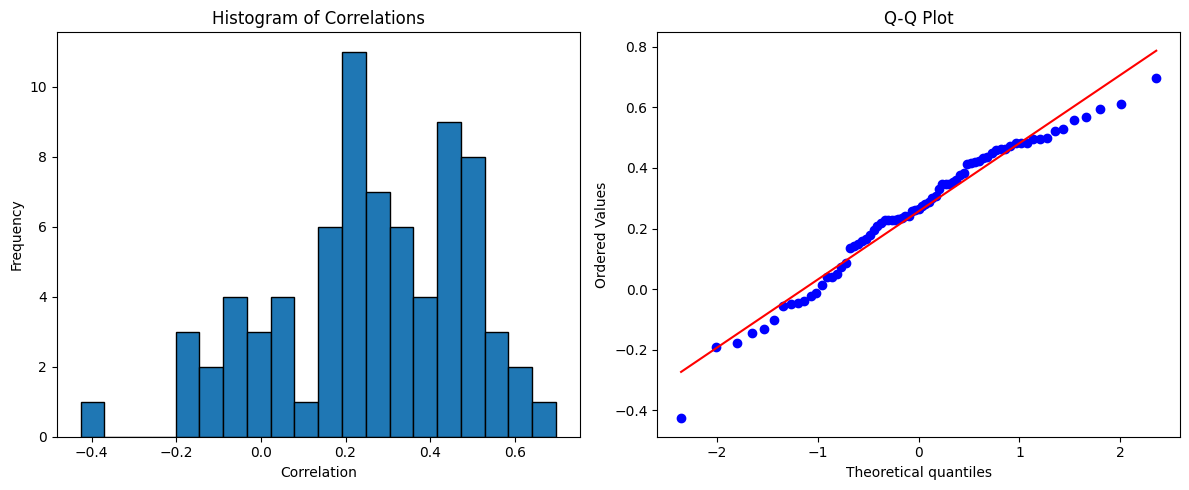


--- APA Style Results ---
Descriptive Statistics:
M = 0.26, SD = 0.22, 95% CI [0.21, 0.31]
N = 75

Normality Assessment:
Shapiro-Wilk test: W(74) = 0.971, p = 0.086

Inference Statistics:
One-sample t-test: t(74) = 9.94, p < .001, d = 1.15
Wilcoxon signed-rank test: W = 178.0, p < .001

APA Formatted Results Section:
The correlation coefficients (M = 0.26, SD = 0.22) were significantly different from zero, t(74) = 9.94, p < .001, d = 1.15, 95% CI [0.21, 0.31].


In [32]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Use the correct variable name from your code
all_correlations = all_correlations_pyradiomics_thalamus

# Number of values in all_correlations
num_correlations = len(all_correlations)

# Descriptive statistics
mean_correlation = np.mean(all_correlations)
std_correlation = np.std(all_correlations, ddof=1)  # Using N-1 for sample std dev

# Wilcoxon signed-rank test
wilcoxon_statistic, wilcoxon_p_value = stats.wilcoxon(all_correlations)

# One-sample t-test
t_statistic, t_p_value = stats.ttest_1samp(all_correlations, 0)

# Calculate Cohen's d for one-sample t-test
cohens_d = mean_correlation / std_correlation  # For one-sample t-test comparing to zero

# Calculate 95% confidence interval
degrees_freedom = num_correlations - 1
ci_95 = stats.t.interval(0.95, degrees_freedom, loc=mean_correlation, 
                         scale=std_correlation/np.sqrt(num_correlations))

# Check normality using Shapiro-Wilk test
shapiro_statistic, shapiro_p_value = stats.shapiro(all_correlations)

# Create Q-Q plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
ax1.hist(all_correlations, bins=20, edgecolor='black')
ax1.set_title('Histogram of Correlations')
ax1.set_xlabel('Correlation')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(all_correlations, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot")
plt.tight_layout()
plt.show()

# Format p-values according to APA
def format_p_value(p):
    if p < 0.001:
        return "p < .001"
    else:
        return f"p = {p:.3f}"

# Print statistical results in APA format
print("\n--- APA Style Results ---")
print("Descriptive Statistics:")
print(f"M = {mean_correlation:.2f}, SD = {std_correlation:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
print(f"N = {num_correlations}")

print("\nNormality Assessment:")
print(f"Shapiro-Wilk test: W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}")

print("\nInference Statistics:")
print(f"One-sample t-test: t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}")
print(f"Wilcoxon signed-rank test: W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}")

# APA formatted result (ready for copy-paste)
print("\nAPA Formatted Results Section:")
if shapiro_p_value >= 0.05:
    print(f"The correlation coefficients (M = {mean_correlation:.2f}, SD = {std_correlation:.2f}) were {'not ' if t_p_value >= 0.05 else ''}significantly different from zero, t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}].")
else:
    print(f"Due to the non-normal distribution of correlation coefficients (Shapiro-Wilk W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}), a Wilcoxon signed-rank test was conducted. The correlations (Mdn = {np.median(all_correlations):.2f}) were {'not ' if wilcoxon_p_value >= 0.05 else ''}significantly different from zero, W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}. For completeness, a t-test yielded t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}.")

## Pyradiomics amygdala 

Running seed 0
Running seed 1
Running seed 2
Running seed 3
Running seed 4
Running seed 5
Running seed 6
Running seed 7
Running seed 8
Running seed 9
Running seed 10
Running seed 11
Running seed 12
Running seed 13
Running seed 14
Top 20 Most Important Features:
                                            feature  importance
10                        original_shape_Sphericity    0.041982
0                         original_shape_Elongation    0.039256
99                       original_glszm_ZoneEntropy    0.035570
94             original_glszm_SizeZoneNonUniformity    0.029412
2                    original_shape_LeastAxisLength    0.028448
58  original_gldm_DependenceNonUniformityNormalized    0.025652
67            original_gldm_SmallDependenceEmphasis    0.024048
1                           original_shape_Flatness    0.023051
28                     original_firstorder_Skewness    0.021900
96                 original_glszm_SmallAreaEmphasis    0.021635
4            original_shape_Maximu

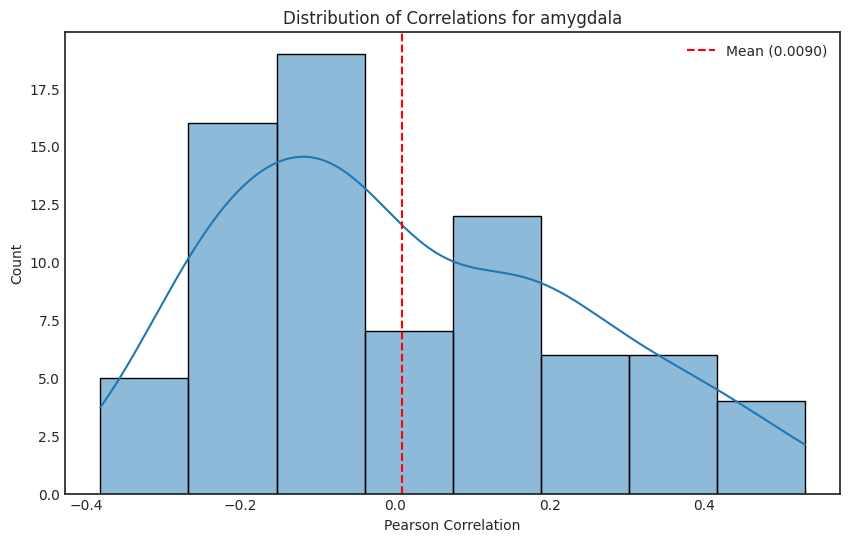

Overall correlation (APA format): r(88) = 0.20, p = 0.0605


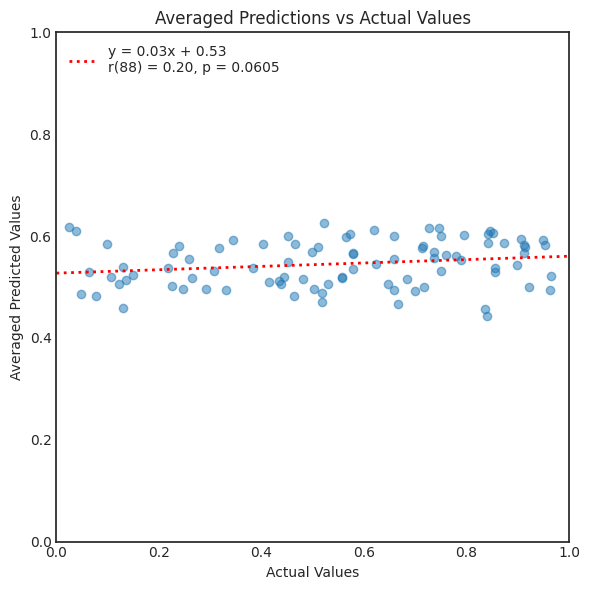

Correlation of averaged predictions (APA format): r(88) = 0.20, p = 0.0605
Regression line: y = 0.0332x + 0.5272

Running verification checks:
✓ Number of rows match
✓ All IDs are present and correct
Mismatched values:
      Original  Results  Difference  Is_Close
ID                                           
1002  0.684642   0.6846    0.000042     False
1003  0.259369   0.2594    0.000031     False
1004  0.855580   0.8556    0.000020     False
1005  0.657692   0.6577    0.000008     False
1006  0.105524   0.1055    0.000024     False
...        ...      ...         ...       ...
1088  0.914986   0.9150    0.000014     False
1089  0.779103   0.7791    0.000003     False
1090  0.227116   0.2271    0.000016     False
1091  0.578327   0.5783    0.000027     False
1092  0.451287   0.4513    0.000013     False

[89 rows x 4 columns]
All differences are within the specified tolerance.
✓ Actual values match with original data (accounting for rounding)
✓ 'Actual' column is correctly sorted
✓ '

In [62]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def run_cv_with_seed(X, y, seed, n_splits=5):
    np.random.seed(seed)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    correlations = []
    p_values = []
    all_predictions = []
    all_actual = []
    feature_importances = np.zeros(X.shape[1])

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        rf_model = RandomForestRegressor(n_estimators=100, random_state=seed)
        rf_model.fit(X_train_scaled, y_train)
        
        y_pred = rf_model.predict(X_test_scaled)
        
        corr, p_value = stats.pearsonr(y_test, y_pred)
        correlations.append(corr)
        p_values.append(p_value)
        all_predictions.extend(y_pred)
        all_actual.extend(y_test)
        
        feature_importances += rf_model.feature_importances_
    
    feature_importances /= n_splits
    
    return correlations, p_values, all_predictions, all_actual, feature_importances

def verify_predictions(original_data, results_df, n_seeds):
    print("\nRunning verification checks:")
    
    # 1. Check if the number of rows matches
    assert len(original_data) == len(results_df), "Number of rows mismatch"
    print("✓ Number of rows match")
    
    # 2. Verify that all IDs in the results are present in the original data
    assert set(results_df['ID']) == set(original_data['ID']), "ID mismatch"
    print("✓ All IDs are present and correct")
    
    # 3. Check if 'Actual' values match between original data and results, accounting for rounding
    original_actual = original_data.set_index('ID')['Model_Building_Total'].round(6)
    results_actual = results_df.set_index('ID')['Actual'].round(6)
    
    # Use a more lenient comparison
    tolerance = 1e-4  # Increased tolerance
    is_close = np.isclose(original_actual, results_actual, atol=tolerance, rtol=0)
    mismatch = ~is_close
    
    if mismatch.any():
        print("Mismatched values:")
        mismatched_df = pd.DataFrame({
            'Original': original_actual[mismatch],
            'Results': results_actual[mismatch],
            'Difference': (original_actual[mismatch] - results_actual[mismatch]).abs(),
            'Is_Close': is_close[mismatch]
        })
        print(mismatched_df)
        
        if mismatched_df['Difference'].max() <= tolerance:
            print("All differences are within the specified tolerance.")
            print("✓ Actual values match with original data (accounting for rounding)")
        else:
            raise AssertionError("Actual values mismatch")
    else:
        print("✓ Actual values match with original data (accounting for rounding)")
    
    # 4. Verify that 'Actual' column is sorted
    assert all(results_df['Actual'].diff()[1:] >= -1e-9), "'Actual' column is not sorted"
    print("✓ 'Actual' column is correctly sorted")
    
    # 5. Check if 'Average_Prediction' is the average of all individual predictions
    calculated_avg = results_df[[f'Prediction_{i+1}' for i in range(n_seeds)]].mean(axis=1)
    assert np.allclose(calculated_avg, results_df['Average_Prediction'], atol=1e-4), "Average prediction mismatch"
    print("✓ 'Average_Prediction' is correctly calculated")
    
    print("All verification checks passed successfully!")

# Load and prepare data
radiomics_df = pd.read_csv('radiomic_results/mri_radiomics_features_regions_18_54_amygdala_combined_default.csv')
target_df = pd.read_csv('radiomic_results/DataAnalysisWith90Participants_Jupyter.csv')

radiomics_df['ID'] = radiomics_df['subject_id'].str[-4:].astype(int)
merged_df = pd.merge(radiomics_df, target_df[['ID', 'Model_Building_Total']], on='ID', how='inner')

feature_columns = [col for col in merged_df.columns if col.startswith('original_')]
X = merged_df[feature_columns]
y = merged_df['Model_Building_Total']

X = X.select_dtypes(include=[np.number])

# Run multiple seeds
n_seeds = 15
all_correlations_pyradiomics_amygdala = []
all_p_values = []
all_predictions = []
all_actual = []
all_feature_importances = np.zeros(X.shape[1])

for seed in range(n_seeds):
    print(f"Running seed {seed}")
    correlations, p_values, predictions, actual, feature_importances = run_cv_with_seed(X, y, seed)
    all_correlations_pyradiomics_amygdala.extend(correlations)
    all_p_values.extend(p_values)
    all_predictions.append(predictions)
    all_actual = actual  # This will be the same for all runs
    all_feature_importances += feature_importances

# Average feature importances across seeds
all_feature_importances /= n_seeds

# Get the 20 most important features
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': all_feature_importances})
top_20_features = feature_importance_df.sort_values('importance', ascending=False).head(20)

print("Top 20 Most Important Features:")
print(top_20_features)

# Analyze results
mean_correlation = np.mean(all_correlations_pyradiomics_amygdala)
std_correlation = np.std(all_correlations_pyradiomics_amygdala)
mean_p_value = np.mean(all_p_values)

print(f"Mean correlation: {mean_correlation:.4f}")
print(f"Mean p-value: {mean_p_value:.4f}")
print(f"Standard deviation of correlation: {std_correlation:.4f}")

# Plot distribution of correlations
plt.figure(figsize=(10, 6))
sns.histplot(all_correlations_pyradiomics_amygdala, kde=True)
plt.title("Distribution of Correlations for amygdala")
plt.xlabel("Pearson Correlation")
plt.axvline(mean_correlation, color='r', linestyle='--', label=f"Mean ({mean_correlation:.4f})")
plt.legend()
# plt.savefig('pyradiomics_random_forest_amygdala_correlation.svg', format='svg', bbox_inches='tight')
plt.show()

# Average predictions across all seeds
avg_predictions = np.mean(all_predictions, axis=0)

# Calculate correlation for averaged predictions
final_corr, final_p_value = stats.pearsonr(all_actual, avg_predictions)
df_final = len(all_actual) - 2  # degrees of freedom

# Print correlation in APA format
print(f"Overall correlation (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")

# Calculate the linear regression line
slope_reg, intercept_reg, _, _, _ = stats.linregress(all_actual, avg_predictions)

# Create scatter plot of averaged predictions vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(all_actual, avg_predictions, alpha=0.5)

# Plot the regression line
x_range = np.array([0, 1])
y_range_reg = slope_reg * x_range + intercept_reg

plt.plot(x_range, y_range_reg, 'r:', linewidth=2, 
         label=f'y = {slope_reg:.2f}x + {intercept_reg:.2f}\nr({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}')

plt.title("Averaged Predictions vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Averaged Predicted Values")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='upper left', fontsize='medium')
plt.tight_layout()
plt.savefig('pyradiomics_random_forest_amygdala_avg_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
plt.show()

# Print correlation and p-value in APA format
print(f"Correlation of averaged predictions (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")
print(f"Regression line: y = {slope_reg:.4f}x + {intercept_reg:.4f}")

# Create initial DataFrame without IDs
results_df = pd.DataFrame({
    'Actual': all_actual,
    'Average_Prediction': avg_predictions
})

# Add individual predictions as columns
for i in range(n_seeds):
    results_df[f'Prediction_{i+1}'] = all_predictions[i]

# Round all numeric columns to 4 decimal points
numeric_columns = results_df.select_dtypes(include=[np.number]).columns
results_df[numeric_columns] = results_df[numeric_columns].round(4)

# Create a temporary DataFrame with actual values and IDs
temp_df = pd.DataFrame({
    'Actual': merged_df['Model_Building_Total'].round(4),
    'ID': merged_df['ID']
})

# Sort both DataFrames by the 'Actual' values to ensure correct matching
results_df = results_df.sort_values('Actual').reset_index(drop=True)
temp_df = temp_df.sort_values('Actual').reset_index(drop=True)

# Add the ID column to results_df
results_df.insert(0, 'ID', temp_df['ID'])

# Sort the entire DataFrame by the 'Actual' column
results_df = results_df.sort_values('Actual').reset_index(drop=True)

# Reorder columns
column_order = ['ID', 'Actual'] + [f'Prediction_{i+1}' for i in range(n_seeds)] + ['Average_Prediction']
results_df = results_df[column_order]

# Run the verification
verify_predictions(merged_df, results_df, n_seeds)

# Save results to CSV (commented out)
#output_filename = 'random_forest_pyradiomics_amygdala_predictions_with_average_and_id.csv'
#results_df.to_csv(output_filename, index=False)
# print(f"\nResults saved to '{output_filename}'")

print("\nPlease check the output files and the statistics above to ensure the process was successful.")

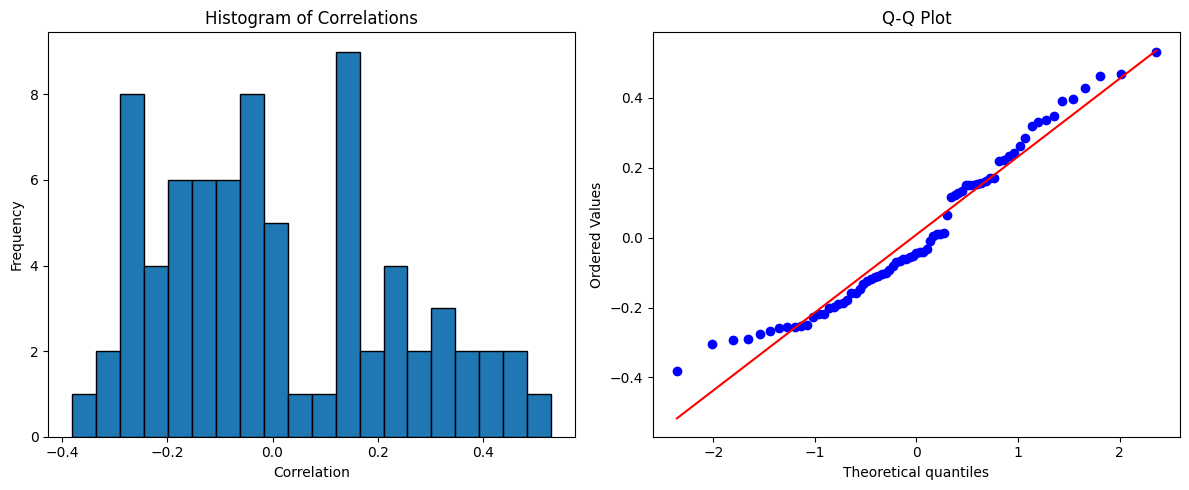


--- APA Style Results ---
Descriptive Statistics:
M = 0.01, SD = 0.22, 95% CI [-0.04, 0.06]
N = 75

Normality Assessment:
Shapiro-Wilk test: W(74) = 0.954, p = 0.009

Inference Statistics:
One-sample t-test: t(74) = 0.35, p = 0.728, d = 0.04
Wilcoxon signed-rank test: W = 1417.0, p = 0.966

APA Formatted Results Section:
Due to the non-normal distribution of correlation coefficients (Shapiro-Wilk W(74) = 0.954, p = 0.009), a Wilcoxon signed-rank test was conducted. The correlations (Mdn = -0.04) were not significantly different from zero, W = 1417.0, p = 0.966. For completeness, a t-test yielded t(74) = 0.35, p = 0.728, d = 0.04.


In [34]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Use the correct variable name from your code
all_correlations = all_correlations_pyradiomics_amygdala

# Number of values in all_correlations
num_correlations = len(all_correlations)

# Descriptive statistics
mean_correlation = np.mean(all_correlations)
std_correlation = np.std(all_correlations, ddof=1)  # Using N-1 for sample std dev

# Wilcoxon signed-rank test
wilcoxon_statistic, wilcoxon_p_value = stats.wilcoxon(all_correlations)

# One-sample t-test
t_statistic, t_p_value = stats.ttest_1samp(all_correlations, 0)

# Calculate Cohen's d for one-sample t-test
cohens_d = mean_correlation / std_correlation  # For one-sample t-test comparing to zero

# Calculate 95% confidence interval
degrees_freedom = num_correlations - 1
ci_95 = stats.t.interval(0.95, degrees_freedom, loc=mean_correlation, 
                         scale=std_correlation/np.sqrt(num_correlations))

# Check normality using Shapiro-Wilk test
shapiro_statistic, shapiro_p_value = stats.shapiro(all_correlations)

# Create Q-Q plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
ax1.hist(all_correlations, bins=20, edgecolor='black')
ax1.set_title('Histogram of Correlations')
ax1.set_xlabel('Correlation')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(all_correlations, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot")
plt.tight_layout()
plt.show()

# Format p-values according to APA
def format_p_value(p):
    if p < 0.001:
        return "p < .001"
    else:
        return f"p = {p:.3f}"

# Print statistical results in APA format
print("\n--- APA Style Results ---")
print("Descriptive Statistics:")
print(f"M = {mean_correlation:.2f}, SD = {std_correlation:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
print(f"N = {num_correlations}")

print("\nNormality Assessment:")
print(f"Shapiro-Wilk test: W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}")

print("\nInference Statistics:")
print(f"One-sample t-test: t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}")
print(f"Wilcoxon signed-rank test: W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}")

# APA formatted result (ready for copy-paste)
print("\nAPA Formatted Results Section:")
if shapiro_p_value >= 0.05:
    print(f"The correlation coefficients (M = {mean_correlation:.2f}, SD = {std_correlation:.2f}) were {'not ' if t_p_value >= 0.05 else ''}significantly different from zero, t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}].")
else:
    print(f"Due to the non-normal distribution of correlation coefficients (Shapiro-Wilk W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}), a Wilcoxon signed-rank test was conducted. The correlations (Mdn = {np.median(all_correlations):.2f}) were {'not ' if wilcoxon_p_value >= 0.05 else ''}significantly different from zero, W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}. For completeness, a t-test yielded t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}.")

## Pyradiomics isthmus cingulate

Running seed 0
Running seed 1
Running seed 2
Running seed 3
Running seed 4
Running seed 5
Running seed 6
Running seed 7
Running seed 8
Running seed 9
Running seed 10
Running seed 11
Running seed 12
Running seed 13
Running seed 14
Top 20 Most Important Features:
                                            feature  importance
19                     original_firstorder_Kurtosis    0.067113
45                               original_glcm_Imc1    0.045181
99                       original_glszm_ZoneEntropy    0.042472
75      original_glrlm_LongRunHighGrayLevelEmphasis    0.038959
67            original_gldm_SmallDependenceEmphasis    0.035212
102                         original_ngtdm_Busyness    0.028722
4            original_shape_Maximum2DDiameterColumn    0.022592
103                       original_ngtdm_Coarseness    0.020515
34                       original_glcm_ClusterShade    0.017547
96                 original_glszm_SmallAreaEmphasis    0.017403
28                     original_fi

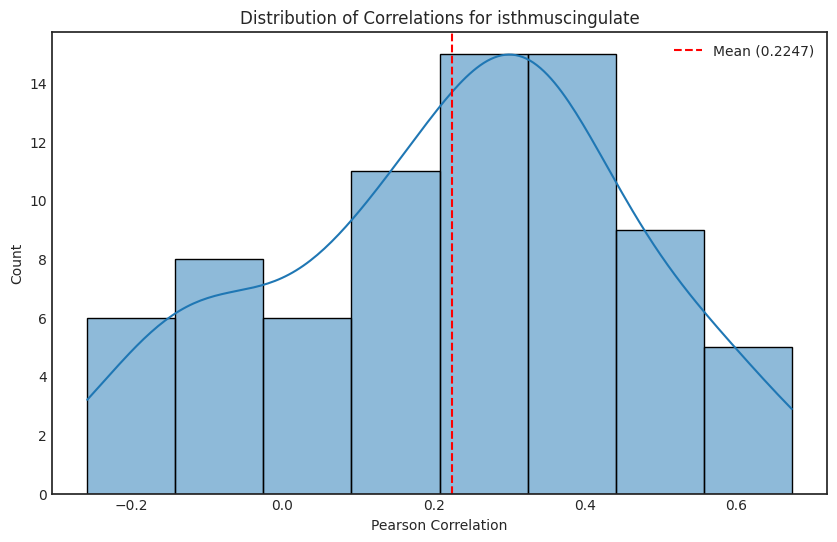

Overall correlation (APA format): r(88) = 0.20, p = 0.0600


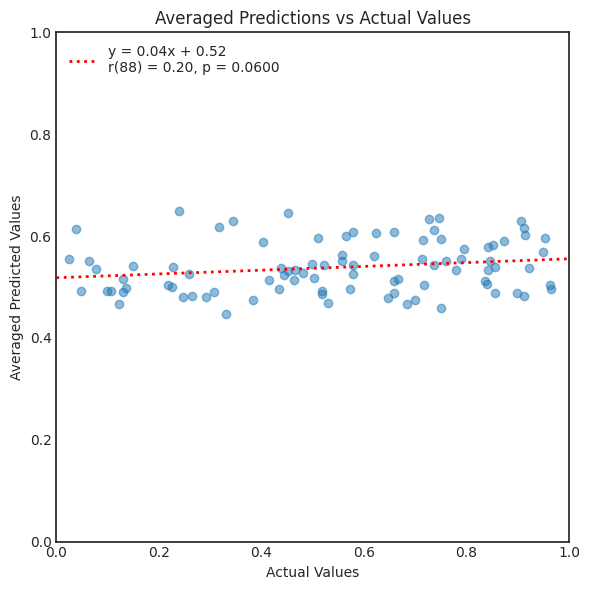

Correlation of averaged predictions (APA format): r(88) = 0.20, p = 0.0600
Regression line: y = 0.0372x + 0.5181

Running verification checks:
✓ Number of rows match
✓ All IDs are present and correct
Mismatched values:
      Original  Results  Difference  Is_Close
ID                                           
1002  0.684642   0.6846    0.000042     False
1003  0.259369   0.2594    0.000031     False
1004  0.855580   0.8556    0.000020     False
1005  0.657692   0.6577    0.000008     False
1006  0.105524   0.1055    0.000024     False
...        ...      ...         ...       ...
1088  0.914986   0.9150    0.000014     False
1089  0.779103   0.7791    0.000003     False
1090  0.227116   0.2271    0.000016     False
1091  0.578327   0.5783    0.000027     False
1092  0.451287   0.4513    0.000013     False

[89 rows x 4 columns]
All differences are within the specified tolerance.
✓ Actual values match with original data (accounting for rounding)
✓ 'Actual' column is correctly sorted
✓ '

In [63]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def run_cv_with_seed(X, y, seed, n_splits=5):
    np.random.seed(seed)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    correlations = []
    p_values = []
    all_predictions = []
    all_actual = []
    feature_importances = np.zeros(X.shape[1])

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        rf_model = RandomForestRegressor(n_estimators=100, random_state=seed)
        rf_model.fit(X_train_scaled, y_train)
        
        y_pred = rf_model.predict(X_test_scaled)
        
        corr, p_value = stats.pearsonr(y_test, y_pred)
        correlations.append(corr)
        p_values.append(p_value)
        all_predictions.extend(y_pred)
        all_actual.extend(y_test)
        
        feature_importances += rf_model.feature_importances_
    
    feature_importances /= n_splits
    
    return correlations, p_values, all_predictions, all_actual, feature_importances

def verify_predictions(original_data, results_df, n_seeds):
    print("\nRunning verification checks:")
    
    # 1. Check if the number of rows matches
    assert len(original_data) == len(results_df), "Number of rows mismatch"
    print("✓ Number of rows match")
    
    # 2. Verify that all IDs in the results are present in the original data
    assert set(results_df['ID']) == set(original_data['ID']), "ID mismatch"
    print("✓ All IDs are present and correct")
    
    # 3. Check if 'Actual' values match between original data and results, accounting for rounding
    original_actual = original_data.set_index('ID')['Model_Building_Total'].round(6)
    results_actual = results_df.set_index('ID')['Actual'].round(6)
    
    # Use a more lenient comparison
    tolerance = 1e-4  # Increased tolerance
    is_close = np.isclose(original_actual, results_actual, atol=tolerance, rtol=0)
    mismatch = ~is_close
    
    if mismatch.any():
        print("Mismatched values:")
        mismatched_df = pd.DataFrame({
            'Original': original_actual[mismatch],
            'Results': results_actual[mismatch],
            'Difference': (original_actual[mismatch] - results_actual[mismatch]).abs(),
            'Is_Close': is_close[mismatch]
        })
        print(mismatched_df)
        
        if mismatched_df['Difference'].max() <= tolerance:
            print("All differences are within the specified tolerance.")
            print("✓ Actual values match with original data (accounting for rounding)")
        else:
            raise AssertionError("Actual values mismatch")
    else:
        print("✓ Actual values match with original data (accounting for rounding)")
    
    # 4. Verify that 'Actual' column is sorted
    assert all(results_df['Actual'].diff()[1:] >= -1e-9), "'Actual' column is not sorted"
    print("✓ 'Actual' column is correctly sorted")
    
    # 5. Check if 'Average_Prediction' is the average of all individual predictions
    calculated_avg = results_df[[f'Prediction_{i+1}' for i in range(n_seeds)]].mean(axis=1)
    assert np.allclose(calculated_avg, results_df['Average_Prediction'], atol=1e-4), "Average prediction mismatch"
    print("✓ 'Average_Prediction' is correctly calculated")
    
    print("All verification checks passed successfully!")

# Load and prepare data
radiomics_df = pd.read_csv('radiomic_results/mri_radiomics_features_regions_1010_2010_isthmuscingulate_combined_default.csv')
target_df = pd.read_csv('radiomic_results/DataAnalysisWith90Participants_Jupyter.csv')

radiomics_df['ID'] = radiomics_df['subject_id'].str[-4:].astype(int)
merged_df = pd.merge(radiomics_df, target_df[['ID', 'Model_Building_Total']], on='ID', how='inner')

feature_columns = [col for col in merged_df.columns if col.startswith('original_')]
X = merged_df[feature_columns]
y = merged_df['Model_Building_Total']

X = X.select_dtypes(include=[np.number])

# Run multiple seeds
n_seeds = 15
all_correlations_pyradiomics_isthmuscingulate = []
all_p_values = []
all_predictions = []
all_actual = []
all_feature_importances = np.zeros(X.shape[1])

for seed in range(n_seeds):
    print(f"Running seed {seed}")
    correlations, p_values, predictions, actual, feature_importances = run_cv_with_seed(X, y, seed)
    all_correlations_pyradiomics_isthmuscingulate.extend(correlations)
    all_p_values.extend(p_values)
    all_predictions.append(predictions)
    all_actual = actual  # This will be the same for all runs
    all_feature_importances += feature_importances

# Average feature importances across seeds
all_feature_importances /= n_seeds

# Get the 20 most important features
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': all_feature_importances})
top_20_features = feature_importance_df.sort_values('importance', ascending=False).head(20)

print("Top 20 Most Important Features:")
print(top_20_features)

# Analyze results
mean_correlation = np.mean(all_correlations_pyradiomics_isthmuscingulate)
std_correlation = np.std(all_correlations_pyradiomics_isthmuscingulate)
mean_p_value = np.mean(all_p_values)

print(f"Mean correlation: {mean_correlation:.4f}")
print(f"Mean p-value: {mean_p_value:.4f}")
print(f"Standard deviation of correlation: {std_correlation:.4f}")

# Plot distribution of correlations
plt.figure(figsize=(10, 6))
sns.histplot(all_correlations_pyradiomics_isthmuscingulate, kde=True)
plt.title("Distribution of Correlations for isthmuscingulate")
plt.xlabel("Pearson Correlation")
plt.axvline(mean_correlation, color='r', linestyle='--', label=f"Mean ({mean_correlation:.4f})")
plt.legend()
# plt.savefig('pyradiomics_random_forest_isthmuscingulate_correlation.svg', format='svg', bbox_inches='tight')
plt.show()

# Average predictions across all seeds
avg_predictions = np.mean(all_predictions, axis=0)

# Calculate correlation for averaged predictions
final_corr, final_p_value = stats.pearsonr(all_actual, avg_predictions)
df_final = len(all_actual) - 2  # degrees of freedom

# Print correlation in APA format
print(f"Overall correlation (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")

# Calculate the linear regression line
slope_reg, intercept_reg, _, _, _ = stats.linregress(all_actual, avg_predictions)

# Create scatter plot of averaged predictions vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(all_actual, avg_predictions, alpha=0.5)

# Plot the regression line
x_range = np.array([0, 1])
y_range_reg = slope_reg * x_range + intercept_reg

plt.plot(x_range, y_range_reg, 'r:', linewidth=2, 
         label=f'y = {slope_reg:.2f}x + {intercept_reg:.2f}\nr({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}')

plt.title("Averaged Predictions vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Averaged Predicted Values")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='upper left', fontsize='medium')
plt.tight_layout()
plt.savefig('pyradiomics_random_forest_isthmuscingulate_avg_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
plt.show()

# Print correlation and p-value in APA format
print(f"Correlation of averaged predictions (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")
print(f"Regression line: y = {slope_reg:.4f}x + {intercept_reg:.4f}")

# Create initial DataFrame without IDs
results_df = pd.DataFrame({
    'Actual': all_actual,
    'Average_Prediction': avg_predictions
})

# Add individual predictions as columns
for i in range(n_seeds):
    results_df[f'Prediction_{i+1}'] = all_predictions[i]

# Round all numeric columns to 4 decimal points
numeric_columns = results_df.select_dtypes(include=[np.number]).columns
results_df[numeric_columns] = results_df[numeric_columns].round(4)

# Create a temporary DataFrame with actual values and IDs
temp_df = pd.DataFrame({
    'Actual': merged_df['Model_Building_Total'].round(4),
    'ID': merged_df['ID']
})

# Sort both DataFrames by the 'Actual' values to ensure correct matching
results_df = results_df.sort_values('Actual').reset_index(drop=True)
temp_df = temp_df.sort_values('Actual').reset_index(drop=True)

# Add the ID column to results_df
results_df.insert(0, 'ID', temp_df['ID'])

# Sort the entire DataFrame by the 'Actual' column
results_df = results_df.sort_values('Actual').reset_index(drop=True)

# Reorder columns
column_order = ['ID', 'Actual'] + [f'Prediction_{i+1}' for i in range(n_seeds)] + ['Average_Prediction']
results_df = results_df[column_order]

# Run the verification
verify_predictions(merged_df, results_df, n_seeds)

# Save results to CSV (commented out)
#output_filename = 'random_forest_pyradiomics_isthmuscingulate_predictions_with_average_and_id.csv'
#results_df.to_csv(output_filename, index=False)
# print(f"\nResults saved to '{output_filename}'")

print("\nPlease check the output files and the statistics above to ensure the process was successful.")

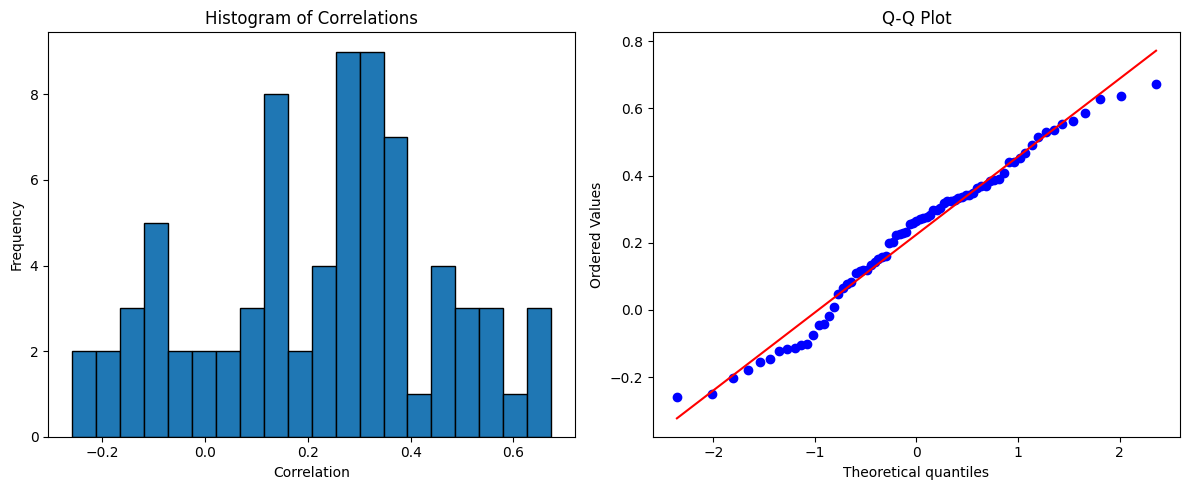


--- APA Style Results ---
Descriptive Statistics:
M = 0.22, SD = 0.23, 95% CI [0.17, 0.28]
N = 75

Normality Assessment:
Shapiro-Wilk test: W(74) = 0.974, p = 0.124

Inference Statistics:
One-sample t-test: t(74) = 8.46, p < .001, d = 0.98
Wilcoxon signed-rank test: W = 252.0, p < .001

APA Formatted Results Section:
The correlation coefficients (M = 0.22, SD = 0.23) were significantly different from zero, t(74) = 8.46, p < .001, d = 0.98, 95% CI [0.17, 0.28].


In [36]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Use the correct variable name from your code
all_correlations = all_correlations_pyradiomics_isthmuscingulate

# Number of values in all_correlations
num_correlations = len(all_correlations)

# Descriptive statistics
mean_correlation = np.mean(all_correlations)
std_correlation = np.std(all_correlations, ddof=1)  # Using N-1 for sample std dev

# Wilcoxon signed-rank test
wilcoxon_statistic, wilcoxon_p_value = stats.wilcoxon(all_correlations)

# One-sample t-test
t_statistic, t_p_value = stats.ttest_1samp(all_correlations, 0)

# Calculate Cohen's d for one-sample t-test
cohens_d = mean_correlation / std_correlation  # For one-sample t-test comparing to zero

# Calculate 95% confidence interval
degrees_freedom = num_correlations - 1
ci_95 = stats.t.interval(0.95, degrees_freedom, loc=mean_correlation, 
                         scale=std_correlation/np.sqrt(num_correlations))

# Check normality using Shapiro-Wilk test
shapiro_statistic, shapiro_p_value = stats.shapiro(all_correlations)

# Create Q-Q plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
ax1.hist(all_correlations, bins=20, edgecolor='black')
ax1.set_title('Histogram of Correlations')
ax1.set_xlabel('Correlation')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(all_correlations, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot")
plt.tight_layout()
plt.show()

# Format p-values according to APA
def format_p_value(p):
    if p < 0.001:
        return "p < .001"
    else:
        return f"p = {p:.3f}"

# Print statistical results in APA format
print("\n--- APA Style Results ---")
print("Descriptive Statistics:")
print(f"M = {mean_correlation:.2f}, SD = {std_correlation:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
print(f"N = {num_correlations}")

print("\nNormality Assessment:")
print(f"Shapiro-Wilk test: W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}")

print("\nInference Statistics:")
print(f"One-sample t-test: t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}")
print(f"Wilcoxon signed-rank test: W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}")

# APA formatted result (ready for copy-paste)
print("\nAPA Formatted Results Section:")
if shapiro_p_value >= 0.05:
    print(f"The correlation coefficients (M = {mean_correlation:.2f}, SD = {std_correlation:.2f}) were {'not ' if t_p_value >= 0.05 else ''}significantly different from zero, t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}].")
else:
    print(f"Due to the non-normal distribution of correlation coefficients (Shapiro-Wilk W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}), a Wilcoxon signed-rank test was conducted. The correlations (Mdn = {np.median(all_correlations):.2f}) were {'not ' if wilcoxon_p_value >= 0.05 else ''}significantly different from zero, W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}. For completeness, a t-test yielded t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}.")

## Pyradiomics parahippocampus

Running seed 0
Running seed 1
Running seed 2
Running seed 3
Running seed 4
Running seed 5
Running seed 6
Running seed 7
Running seed 8
Running seed 9
Running seed 10
Running seed 11
Running seed 12
Running seed 13
Running seed 14
Top 20 Most Important Features:
                                               feature  importance
56                     original_gldm_DependenceEntropy    0.047052
92        original_glszm_LargeAreaLowGrayLevelEmphasis    0.032892
28                        original_firstorder_Skewness    0.031554
1                              original_shape_Flatness    0.024958
45                                  original_glcm_Imc1    0.023814
11                          original_shape_SurfaceArea    0.022637
71     original_glrlm_GrayLevelNonUniformityNormalized    0.021333
4               original_shape_Maximum2DDiameterColumn    0.020893
3                       original_shape_MajorAxisLength    0.020174
102                            original_ngtdm_Busyness    0.019984
7

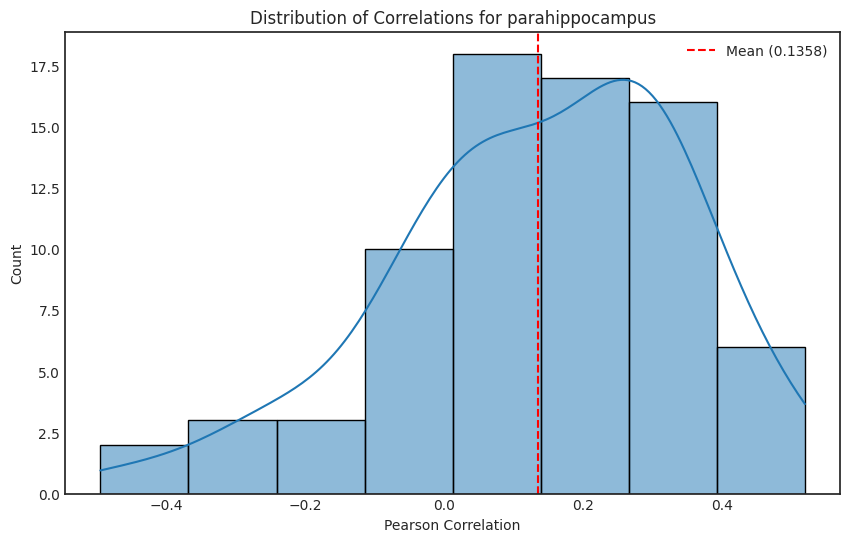

Overall correlation (APA format): r(88) = 0.22, p = 0.0403


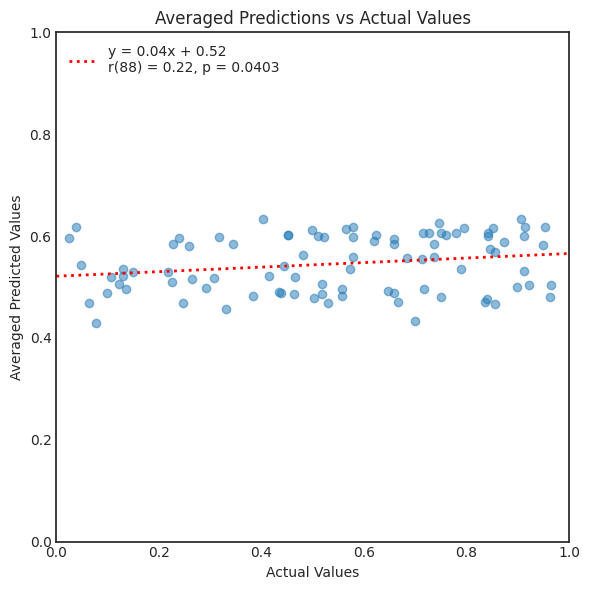

Correlation of averaged predictions (APA format): r(88) = 0.22, p = 0.0403
Regression line: y = 0.0446x + 0.5211

Running verification checks:
✓ Number of rows match
✓ All IDs are present and correct
Mismatched values:
      Original  Results  Difference  Is_Close
ID                                           
1002  0.684642   0.6846    0.000042     False
1003  0.259369   0.2594    0.000031     False
1004  0.855580   0.8556    0.000020     False
1005  0.657692   0.6577    0.000008     False
1006  0.105524   0.1055    0.000024     False
...        ...      ...         ...       ...
1088  0.914986   0.9150    0.000014     False
1089  0.779103   0.7791    0.000003     False
1090  0.227116   0.2271    0.000016     False
1091  0.578327   0.5783    0.000027     False
1092  0.451287   0.4513    0.000013     False

[89 rows x 4 columns]
All differences are within the specified tolerance.
✓ Actual values match with original data (accounting for rounding)
✓ 'Actual' column is correctly sorted
✓ '

In [64]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def run_cv_with_seed(X, y, seed, n_splits=5):
    np.random.seed(seed)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    correlations = []
    p_values = []
    all_predictions = []
    all_actual = []
    feature_importances = np.zeros(X.shape[1])

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        rf_model = RandomForestRegressor(n_estimators=100, random_state=seed)
        rf_model.fit(X_train_scaled, y_train)
        
        y_pred = rf_model.predict(X_test_scaled)
        
        corr, p_value = stats.pearsonr(y_test, y_pred)
        correlations.append(corr)
        p_values.append(p_value)
        all_predictions.extend(y_pred)
        all_actual.extend(y_test)
        
        feature_importances += rf_model.feature_importances_
    
    feature_importances /= n_splits
    
    return correlations, p_values, all_predictions, all_actual, feature_importances

def verify_predictions(original_data, results_df, n_seeds):
    print("\nRunning verification checks:")
    
    # 1. Check if the number of rows matches
    assert len(original_data) == len(results_df), "Number of rows mismatch"
    print("✓ Number of rows match")
    
    # 2. Verify that all IDs in the results are present in the original data
    assert set(results_df['ID']) == set(original_data['ID']), "ID mismatch"
    print("✓ All IDs are present and correct")
    
    # 3. Check if 'Actual' values match between original data and results, accounting for rounding
    original_actual = original_data.set_index('ID')['Model_Building_Total'].round(6)
    results_actual = results_df.set_index('ID')['Actual'].round(6)
    
    # Use a more lenient comparison
    tolerance = 1e-4  # Increased tolerance
    is_close = np.isclose(original_actual, results_actual, atol=tolerance, rtol=0)
    mismatch = ~is_close
    
    if mismatch.any():
        print("Mismatched values:")
        mismatched_df = pd.DataFrame({
            'Original': original_actual[mismatch],
            'Results': results_actual[mismatch],
            'Difference': (original_actual[mismatch] - results_actual[mismatch]).abs(),
            'Is_Close': is_close[mismatch]
        })
        print(mismatched_df)
        
        if mismatched_df['Difference'].max() <= tolerance:
            print("All differences are within the specified tolerance.")
            print("✓ Actual values match with original data (accounting for rounding)")
        else:
            raise AssertionError("Actual values mismatch")
    else:
        print("✓ Actual values match with original data (accounting for rounding)")
    
    # 4. Verify that 'Actual' column is sorted
    assert all(results_df['Actual'].diff()[1:] >= -1e-9), "'Actual' column is not sorted"
    print("✓ 'Actual' column is correctly sorted")
    
    # 5. Check if 'Average_Prediction' is the average of all individual predictions
    calculated_avg = results_df[[f'Prediction_{i+1}' for i in range(n_seeds)]].mean(axis=1)
    assert np.allclose(calculated_avg, results_df['Average_Prediction'], atol=1e-4), "Average prediction mismatch"
    print("✓ 'Average_Prediction' is correctly calculated")
    
    print("All verification checks passed successfully!")

# Load and prepare data
radiomics_df = pd.read_csv('radiomic_results/mri_radiomics_features_regions_1016_2016_parahippocampus_combined_default.csv')
target_df = pd.read_csv('radiomic_results/DataAnalysisWith90Participants_Jupyter.csv')

radiomics_df['ID'] = radiomics_df['subject_id'].str[-4:].astype(int)
merged_df = pd.merge(radiomics_df, target_df[['ID', 'Model_Building_Total']], on='ID', how='inner')

feature_columns = [col for col in merged_df.columns if col.startswith('original_')]
X = merged_df[feature_columns]
y = merged_df['Model_Building_Total']

X = X.select_dtypes(include=[np.number])

# Run multiple seeds
n_seeds = 15
all_correlations_pyradiomics_parahippocampus = []
all_p_values = []
all_predictions = []
all_actual = []
all_feature_importances = np.zeros(X.shape[1])

for seed in range(n_seeds):
    print(f"Running seed {seed}")
    correlations, p_values, predictions, actual, feature_importances = run_cv_with_seed(X, y, seed)
    all_correlations_pyradiomics_parahippocampus.extend(correlations)
    all_p_values.extend(p_values)
    all_predictions.append(predictions)
    all_actual = actual  # This will be the same for all runs
    all_feature_importances += feature_importances

# Average feature importances across seeds
all_feature_importances /= n_seeds

# Get the 20 most important features
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': all_feature_importances})
top_20_features = feature_importance_df.sort_values('importance', ascending=False).head(20)

print("Top 20 Most Important Features:")
print(top_20_features)

# Analyze results
mean_correlation = np.mean(all_correlations_pyradiomics_parahippocampus)
std_correlation = np.std(all_correlations_pyradiomics_parahippocampus)
mean_p_value = np.mean(all_p_values)

print(f"Mean correlation: {mean_correlation:.4f}")
print(f"Mean p-value: {mean_p_value:.4f}")
print(f"Standard deviation of correlation: {std_correlation:.4f}")

# Plot distribution of correlations
plt.figure(figsize=(10, 6))
sns.histplot(all_correlations_pyradiomics_parahippocampus, kde=True)
plt.title("Distribution of Correlations for parahippocampus")
plt.xlabel("Pearson Correlation")
plt.axvline(mean_correlation, color='r', linestyle='--', label=f"Mean ({mean_correlation:.4f})")
plt.legend()
# plt.savefig('pyradiomics_random_forest_parahippocampus_correlation.svg', format='svg', bbox_inches='tight')
plt.show()

# Average predictions across all seeds
avg_predictions = np.mean(all_predictions, axis=0)

# Calculate correlation for averaged predictions
final_corr, final_p_value = stats.pearsonr(all_actual, avg_predictions)
df_final = len(all_actual) - 2  # degrees of freedom

# Print correlation in APA format
print(f"Overall correlation (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")

# Calculate the linear regression line
slope_reg, intercept_reg, _, _, _ = stats.linregress(all_actual, avg_predictions)

# Create scatter plot of averaged predictions vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(all_actual, avg_predictions, alpha=0.5)

# Plot the regression line
x_range = np.array([0, 1])
y_range_reg = slope_reg * x_range + intercept_reg

plt.plot(x_range, y_range_reg, 'r:', linewidth=2, 
         label=f'y = {slope_reg:.2f}x + {intercept_reg:.2f}\nr({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}')

plt.title("Averaged Predictions vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Averaged Predicted Values")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='upper left', fontsize='medium')
plt.tight_layout()
plt.savefig('pyradiomics_random_forest_parahippocampus_avg_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
plt.show()

# Print correlation and p-value in APA format
print(f"Correlation of averaged predictions (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")
print(f"Regression line: y = {slope_reg:.4f}x + {intercept_reg:.4f}")

# Create initial DataFrame without IDs
results_df = pd.DataFrame({
    'Actual': all_actual,
    'Average_Prediction': avg_predictions
})

# Add individual predictions as columns
for i in range(n_seeds):
    results_df[f'Prediction_{i+1}'] = all_predictions[i]

# Round all numeric columns to 4 decimal points
numeric_columns = results_df.select_dtypes(include=[np.number]).columns
results_df[numeric_columns] = results_df[numeric_columns].round(4)

# Create a temporary DataFrame with actual values and IDs
temp_df = pd.DataFrame({
    'Actual': merged_df['Model_Building_Total'].round(4),
    'ID': merged_df['ID']
})

# Sort both DataFrames by the 'Actual' values to ensure correct matching
results_df = results_df.sort_values('Actual').reset_index(drop=True)
temp_df = temp_df.sort_values('Actual').reset_index(drop=True)

# Add the ID column to results_df
results_df.insert(0, 'ID', temp_df['ID'])

# Sort the entire DataFrame by the 'Actual' column
results_df = results_df.sort_values('Actual').reset_index(drop=True)

# Reorder columns
column_order = ['ID', 'Actual'] + [f'Prediction_{i+1}' for i in range(n_seeds)] + ['Average_Prediction']
results_df = results_df[column_order]

# Run the verification
verify_predictions(merged_df, results_df, n_seeds)

# Save results to CSV (commented out)
#output_filename = 'random_forest_pyradiomics_parahippocampus_predictions_with_average_and_id.csv'
#results_df.to_csv(output_filename, index=False)
# print(f"\nResults saved to '{output_filename}'")

print("\nPlease check the output files and the statistics above to ensure the process was successful.")

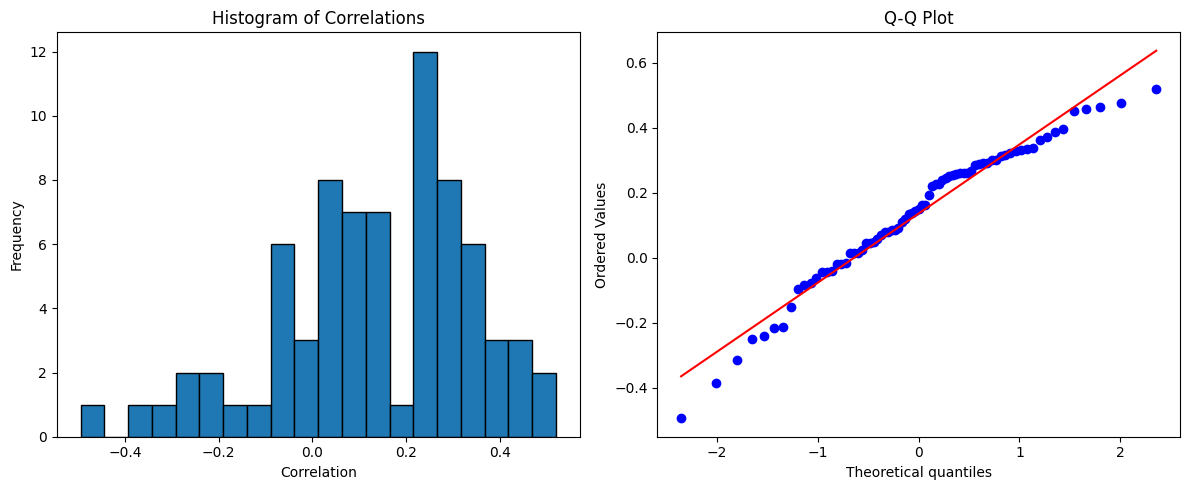


--- APA Style Results ---
Descriptive Statistics:
M = 0.14, SD = 0.21, 95% CI [0.09, 0.18]
N = 75

Normality Assessment:
Shapiro-Wilk test: W(74) = 0.967, p = 0.045

Inference Statistics:
One-sample t-test: t(74) = 5.55, p < .001, d = 0.64
Wilcoxon signed-rank test: W = 502.0, p < .001

APA Formatted Results Section:
Due to the non-normal distribution of correlation coefficients (Shapiro-Wilk W(74) = 0.967, p = 0.045), a Wilcoxon signed-rank test was conducted. The correlations (Mdn = 0.15) were significantly different from zero, W = 502.0, p < .001. For completeness, a t-test yielded t(74) = 5.55, p < .001, d = 0.64.


In [38]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Use the correct variable name from your code
all_correlations = all_correlations_pyradiomics_parahippocampus

# Number of values in all_correlations
num_correlations = len(all_correlations)

# Descriptive statistics
mean_correlation = np.mean(all_correlations)
std_correlation = np.std(all_correlations, ddof=1)  # Using N-1 for sample std dev

# Wilcoxon signed-rank test
wilcoxon_statistic, wilcoxon_p_value = stats.wilcoxon(all_correlations)

# One-sample t-test
t_statistic, t_p_value = stats.ttest_1samp(all_correlations, 0)

# Calculate Cohen's d for one-sample t-test
cohens_d = mean_correlation / std_correlation  # For one-sample t-test comparing to zero

# Calculate 95% confidence interval
degrees_freedom = num_correlations - 1
ci_95 = stats.t.interval(0.95, degrees_freedom, loc=mean_correlation, 
                         scale=std_correlation/np.sqrt(num_correlations))

# Check normality using Shapiro-Wilk test
shapiro_statistic, shapiro_p_value = stats.shapiro(all_correlations)

# Create Q-Q plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
ax1.hist(all_correlations, bins=20, edgecolor='black')
ax1.set_title('Histogram of Correlations')
ax1.set_xlabel('Correlation')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(all_correlations, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot")
plt.tight_layout()
plt.show()

# Format p-values according to APA
def format_p_value(p):
    if p < 0.001:
        return "p < .001"
    else:
        return f"p = {p:.3f}"

# Print statistical results in APA format
print("\n--- APA Style Results ---")
print("Descriptive Statistics:")
print(f"M = {mean_correlation:.2f}, SD = {std_correlation:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
print(f"N = {num_correlations}")

print("\nNormality Assessment:")
print(f"Shapiro-Wilk test: W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}")

print("\nInference Statistics:")
print(f"One-sample t-test: t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}")
print(f"Wilcoxon signed-rank test: W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}")

# APA formatted result (ready for copy-paste)
print("\nAPA Formatted Results Section:")
if shapiro_p_value >= 0.05:
    print(f"The correlation coefficients (M = {mean_correlation:.2f}, SD = {std_correlation:.2f}) were {'not ' if t_p_value >= 0.05 else ''}significantly different from zero, t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}].")
else:
    print(f"Due to the non-normal distribution of correlation coefficients (Shapiro-Wilk W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}), a Wilcoxon signed-rank test was conducted. The correlations (Mdn = {np.median(all_correlations):.2f}) were {'not ' if wilcoxon_p_value >= 0.05 else ''}significantly different from zero, W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}. For completeness, a t-test yielded t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}.")

## Pyradiomics entorhinal

Running seed 0
Running seed 1
Running seed 2
Running seed 3
Running seed 4
Running seed 5
Running seed 6
Running seed 7
Running seed 8
Running seed 9
Running seed 10
Running seed 11
Running seed 12
Running seed 13
Running seed 14
Top 20 Most Important Features:
                                       feature  importance
12           original_shape_SurfaceVolumeRatio    0.048232
28                original_firstorder_Skewness    0.032588
86       original_glszm_GrayLevelNonUniformity    0.031239
94        original_glszm_SizeZoneNonUniformity    0.031229
7             original_shape_Maximum3DDiameter    0.026691
10                   original_shape_Sphericity    0.026627
56             original_gldm_DependenceEntropy    0.020454
99                  original_glszm_ZoneEntropy    0.020044
21   original_firstorder_MeanAbsoluteDeviation    0.019856
100              original_glszm_ZonePercentage    0.019150
4       original_shape_Maximum2DDiameterColumn    0.018650
78                   original_

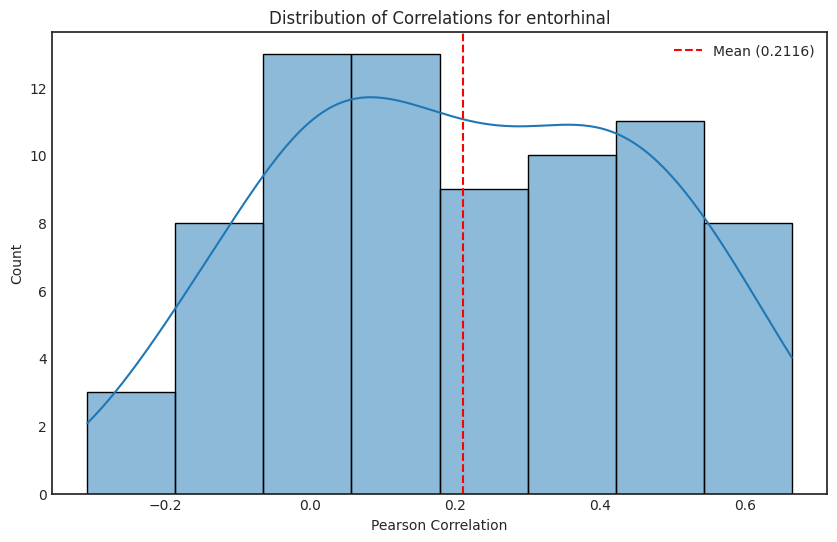

Overall correlation (APA format): r(88) = 0.12, p = 0.2517


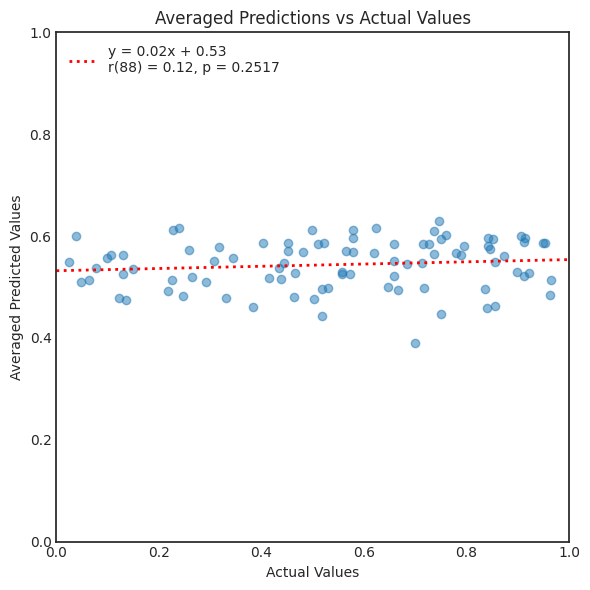

Correlation of averaged predictions (APA format): r(88) = 0.12, p = 0.2517
Regression line: y = 0.0218x + 0.5319

Running verification checks:
✓ Number of rows match
✓ All IDs are present and correct
Mismatched values:
      Original  Results  Difference  Is_Close
ID                                           
1002  0.684642   0.6846    0.000042     False
1003  0.259369   0.2594    0.000031     False
1004  0.855580   0.8556    0.000020     False
1005  0.657692   0.6577    0.000008     False
1006  0.105524   0.1055    0.000024     False
...        ...      ...         ...       ...
1088  0.914986   0.9150    0.000014     False
1089  0.779103   0.7791    0.000003     False
1090  0.227116   0.2271    0.000016     False
1091  0.578327   0.5783    0.000027     False
1092  0.451287   0.4513    0.000013     False

[89 rows x 4 columns]
All differences are within the specified tolerance.
✓ Actual values match with original data (accounting for rounding)
✓ 'Actual' column is correctly sorted
✓ '

In [65]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def run_cv_with_seed(X, y, seed, n_splits=5):
    np.random.seed(seed)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    correlations = []
    p_values = []
    all_predictions = []
    all_actual = []
    feature_importances = np.zeros(X.shape[1])

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        rf_model = RandomForestRegressor(n_estimators=100, random_state=seed)
        rf_model.fit(X_train_scaled, y_train)
        
        y_pred = rf_model.predict(X_test_scaled)
        
        corr, p_value = stats.pearsonr(y_test, y_pred)
        correlations.append(corr)
        p_values.append(p_value)
        all_predictions.extend(y_pred)
        all_actual.extend(y_test)
        
        feature_importances += rf_model.feature_importances_
    
    feature_importances /= n_splits
    
    return correlations, p_values, all_predictions, all_actual, feature_importances

def verify_predictions(original_data, results_df, n_seeds):
    print("\nRunning verification checks:")
    
    # 1. Check if the number of rows matches
    assert len(original_data) == len(results_df), "Number of rows mismatch"
    print("✓ Number of rows match")
    
    # 2. Verify that all IDs in the results are present in the original data
    assert set(results_df['ID']) == set(original_data['ID']), "ID mismatch"
    print("✓ All IDs are present and correct")
    
    # 3. Check if 'Actual' values match between original data and results, accounting for rounding
    original_actual = original_data.set_index('ID')['Model_Building_Total'].round(6)
    results_actual = results_df.set_index('ID')['Actual'].round(6)
    
    # Use a more lenient comparison
    tolerance = 1e-4  # Increased tolerance
    is_close = np.isclose(original_actual, results_actual, atol=tolerance, rtol=0)
    mismatch = ~is_close
    
    if mismatch.any():
        print("Mismatched values:")
        mismatched_df = pd.DataFrame({
            'Original': original_actual[mismatch],
            'Results': results_actual[mismatch],
            'Difference': (original_actual[mismatch] - results_actual[mismatch]).abs(),
            'Is_Close': is_close[mismatch]
        })
        print(mismatched_df)
        
        if mismatched_df['Difference'].max() <= tolerance:
            print("All differences are within the specified tolerance.")
            print("✓ Actual values match with original data (accounting for rounding)")
        else:
            raise AssertionError("Actual values mismatch")
    else:
        print("✓ Actual values match with original data (accounting for rounding)")
    
    # 4. Verify that 'Actual' column is sorted
    assert all(results_df['Actual'].diff()[1:] >= -1e-9), "'Actual' column is not sorted"
    print("✓ 'Actual' column is correctly sorted")
    
    # 5. Check if 'Average_Prediction' is the average of all individual predictions
    calculated_avg = results_df[[f'Prediction_{i+1}' for i in range(n_seeds)]].mean(axis=1)
    assert np.allclose(calculated_avg, results_df['Average_Prediction'], atol=1e-4), "Average prediction mismatch"
    print("✓ 'Average_Prediction' is correctly calculated")
    
    print("All verification checks passed successfully!")

# Load and prepare data
radiomics_df = pd.read_csv('radiomic_results/mri_radiomics_features_regions_1006_2006_entorhinal_combined_default.csv')
target_df = pd.read_csv('radiomic_results/DataAnalysisWith90Participants_Jupyter.csv')

radiomics_df['ID'] = radiomics_df['subject_id'].str[-4:].astype(int)
merged_df = pd.merge(radiomics_df, target_df[['ID', 'Model_Building_Total']], on='ID', how='inner')

feature_columns = [col for col in merged_df.columns if col.startswith('original_')]
X = merged_df[feature_columns]
y = merged_df['Model_Building_Total']

X = X.select_dtypes(include=[np.number])

# Run multiple seeds
n_seeds = 15
all_correlations_pyradiomics_entorhinal = []
all_p_values = []
all_predictions = []
all_actual = []
all_feature_importances = np.zeros(X.shape[1])

for seed in range(n_seeds):
    print(f"Running seed {seed}")
    correlations, p_values, predictions, actual, feature_importances = run_cv_with_seed(X, y, seed)
    all_correlations_pyradiomics_entorhinal.extend(correlations)
    all_p_values.extend(p_values)
    all_predictions.append(predictions)
    all_actual = actual  # This will be the same for all runs
    all_feature_importances += feature_importances

# Average feature importances across seeds
all_feature_importances /= n_seeds

# Get the 20 most important features
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': all_feature_importances})
top_20_features = feature_importance_df.sort_values('importance', ascending=False).head(20)

print("Top 20 Most Important Features:")
print(top_20_features)

# Analyze results
mean_correlation = np.mean(all_correlations_pyradiomics_entorhinal)
std_correlation = np.std(all_correlations_pyradiomics_entorhinal)
mean_p_value = np.mean(all_p_values)

print(f"Mean correlation: {mean_correlation:.4f}")
print(f"Mean p-value: {mean_p_value:.4f}")
print(f"Standard deviation of correlation: {std_correlation:.4f}")

# Plot distribution of correlations
plt.figure(figsize=(10, 6))
sns.histplot(all_correlations_pyradiomics_entorhinal, kde=True)
plt.title("Distribution of Correlations for entorhinal")
plt.xlabel("Pearson Correlation")
plt.axvline(mean_correlation, color='r', linestyle='--', label=f"Mean ({mean_correlation:.4f})")
plt.legend()
# plt.savefig('pyradiomics_random_forest_entorhinal_correlation.svg', format='svg', bbox_inches='tight')
plt.show()

# Average predictions across all seeds
avg_predictions = np.mean(all_predictions, axis=0)

# Calculate correlation for averaged predictions
final_corr, final_p_value = stats.pearsonr(all_actual, avg_predictions)
df_final = len(all_actual) - 2  # degrees of freedom

# Print correlation in APA format
print(f"Overall correlation (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")

# Calculate the linear regression line
slope_reg, intercept_reg, _, _, _ = stats.linregress(all_actual, avg_predictions)

# Create scatter plot of averaged predictions vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(all_actual, avg_predictions, alpha=0.5)

# Plot the regression line
x_range = np.array([0, 1])
y_range_reg = slope_reg * x_range + intercept_reg

plt.plot(x_range, y_range_reg, 'r:', linewidth=2, 
         label=f'y = {slope_reg:.2f}x + {intercept_reg:.2f}\nr({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}')

plt.title("Averaged Predictions vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Averaged Predicted Values")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='upper left', fontsize='medium')
plt.tight_layout()
plt.savefig('pyradiomics_random_forest_entorhinal_avg_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
plt.show()

# Print correlation and p-value in APA format
print(f"Correlation of averaged predictions (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")
print(f"Regression line: y = {slope_reg:.4f}x + {intercept_reg:.4f}")

# Create initial DataFrame without IDs
results_df = pd.DataFrame({
    'Actual': all_actual,
    'Average_Prediction': avg_predictions
})

# Add individual predictions as columns
for i in range(n_seeds):
    results_df[f'Prediction_{i+1}'] = all_predictions[i]

# Round all numeric columns to 4 decimal points
numeric_columns = results_df.select_dtypes(include=[np.number]).columns
results_df[numeric_columns] = results_df[numeric_columns].round(4)

# Create a temporary DataFrame with actual values and IDs
temp_df = pd.DataFrame({
    'Actual': merged_df['Model_Building_Total'].round(4),
    'ID': merged_df['ID']
})

# Sort both DataFrames by the 'Actual' values to ensure correct matching
results_df = results_df.sort_values('Actual').reset_index(drop=True)
temp_df = temp_df.sort_values('Actual').reset_index(drop=True)

# Add the ID column to results_df
results_df.insert(0, 'ID', temp_df['ID'])

# Sort the entire DataFrame by the 'Actual' column
results_df = results_df.sort_values('Actual').reset_index(drop=True)

# Reorder columns
column_order = ['ID', 'Actual'] + [f'Prediction_{i+1}' for i in range(n_seeds)] + ['Average_Prediction']
results_df = results_df[column_order]

# Run the verification
verify_predictions(merged_df, results_df, n_seeds)

# Save results to CSV (commented out)
#output_filename = 'random_forest_pyradiomics_entorhinal_predictions_with_average_and_id.csv'
#results_df.to_csv(output_filename, index=False)
# print(f"\nResults saved to '{output_filename}'")

print("\nPlease check the output files and the statistics above to ensure the process was successful.")

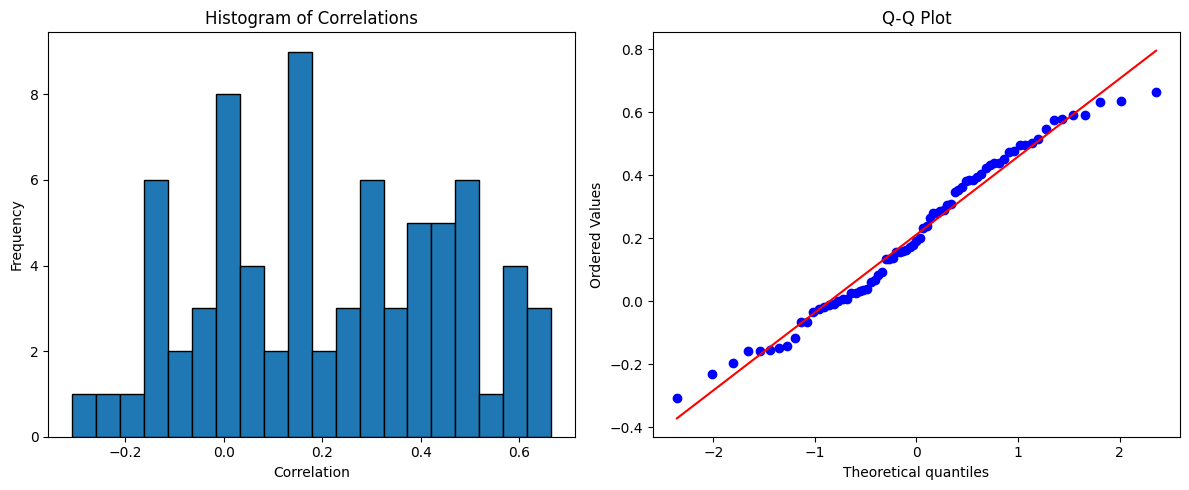


--- APA Style Results ---
Descriptive Statistics:
M = 0.21, SD = 0.25, 95% CI [0.16, 0.27]
N = 75

Normality Assessment:
Shapiro-Wilk test: W(74) = 0.973, p = 0.115

Inference Statistics:
One-sample t-test: t(74) = 7.47, p < .001, d = 0.86
Wilcoxon signed-rank test: W = 344.0, p < .001

APA Formatted Results Section:
The correlation coefficients (M = 0.21, SD = 0.25) were significantly different from zero, t(74) = 7.47, p < .001, d = 0.86, 95% CI [0.16, 0.27].


In [40]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Use the correct variable name from your code
all_correlations = all_correlations_pyradiomics_entorhinal

# Number of values in all_correlations
num_correlations = len(all_correlations)

# Descriptive statistics
mean_correlation = np.mean(all_correlations)
std_correlation = np.std(all_correlations, ddof=1)  # Using N-1 for sample std dev

# Wilcoxon signed-rank test
wilcoxon_statistic, wilcoxon_p_value = stats.wilcoxon(all_correlations)

# One-sample t-test
t_statistic, t_p_value = stats.ttest_1samp(all_correlations, 0)

# Calculate Cohen's d for one-sample t-test
cohens_d = mean_correlation / std_correlation  # For one-sample t-test comparing to zero

# Calculate 95% confidence interval
degrees_freedom = num_correlations - 1
ci_95 = stats.t.interval(0.95, degrees_freedom, loc=mean_correlation, 
                         scale=std_correlation/np.sqrt(num_correlations))

# Check normality using Shapiro-Wilk test
shapiro_statistic, shapiro_p_value = stats.shapiro(all_correlations)

# Create Q-Q plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
ax1.hist(all_correlations, bins=20, edgecolor='black')
ax1.set_title('Histogram of Correlations')
ax1.set_xlabel('Correlation')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(all_correlations, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot")
plt.tight_layout()
plt.show()

# Format p-values according to APA
def format_p_value(p):
    if p < 0.001:
        return "p < .001"
    else:
        return f"p = {p:.3f}"

# Print statistical results in APA format
print("\n--- APA Style Results ---")
print("Descriptive Statistics:")
print(f"M = {mean_correlation:.2f}, SD = {std_correlation:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
print(f"N = {num_correlations}")

print("\nNormality Assessment:")
print(f"Shapiro-Wilk test: W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}")

print("\nInference Statistics:")
print(f"One-sample t-test: t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}")
print(f"Wilcoxon signed-rank test: W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}")

# APA formatted result (ready for copy-paste)
print("\nAPA Formatted Results Section:")
if shapiro_p_value >= 0.05:
    print(f"The correlation coefficients (M = {mean_correlation:.2f}, SD = {std_correlation:.2f}) were {'not ' if t_p_value >= 0.05 else ''}significantly different from zero, t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}].")
else:
    print(f"Due to the non-normal distribution of correlation coefficients (Shapiro-Wilk W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}), a Wilcoxon signed-rank test was conducted. The correlations (Mdn = {np.median(all_correlations):.2f}) were {'not ' if wilcoxon_p_value >= 0.05 else ''}significantly different from zero, W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}. For completeness, a t-test yielded t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}.")

# Pyradiomics whole brain

Running seed 0
Running seed 1
Running seed 2
Running seed 3
Running seed 4
Running seed 5
Running seed 6
Running seed 7
Running seed 8
Running seed 9
Running seed 10
Running seed 11
Running seed 12
Running seed 13
Running seed 14
Top 20 Most Important Features:
                                              feature  importance
56                    original_gldm_DependenceEntropy    0.059368
58    original_gldm_DependenceNonUniformityNormalized    0.032443
99                         original_glszm_ZoneEntropy    0.025470
96                   original_glszm_SmallAreaEmphasis    0.023319
98       original_glszm_SmallAreaLowGrayLevelEmphasis    0.023121
68  original_gldm_SmallDependenceHighGrayLevelEmph...    0.022447
95     original_glszm_SizeZoneNonUniformityNormalized    0.021610
75        original_glrlm_LongRunHighGrayLevelEmphasis    0.020762
57              original_gldm_DependenceNonUniformity    0.020362
52                   original_glcm_MaximumProbability    0.019933
93          

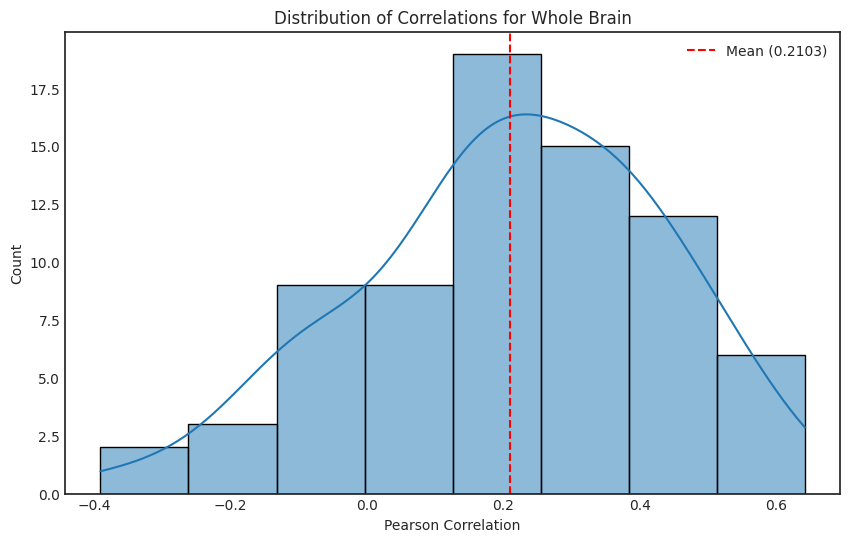

Overall correlation (APA format): r(88) = 0.25, p = 0.0188


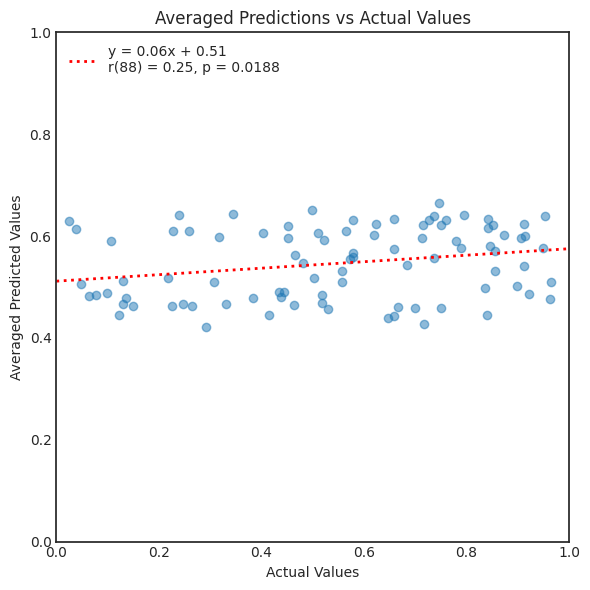

Correlation of averaged predictions (APA format): r(88) = 0.25, p = 0.0188
Regression line: y = 0.0637x + 0.5114

Running verification checks:
✓ Number of rows match
✓ All IDs are present and correct
Mismatched values:
      Original  Results  Difference  Is_Close
ID                                           
1002  0.684642   0.6846    0.000042     False
1003  0.259369   0.2594    0.000031     False
1004  0.855580   0.8556    0.000020     False
1005  0.657692   0.6577    0.000008     False
1006  0.105524   0.1055    0.000024     False
...        ...      ...         ...       ...
1088  0.914986   0.9150    0.000014     False
1089  0.779103   0.7791    0.000003     False
1090  0.227116   0.2271    0.000016     False
1091  0.578327   0.5783    0.000027     False
1092  0.451287   0.4513    0.000013     False

[89 rows x 4 columns]
All differences are within the specified tolerance.
✓ Actual values match with original data (accounting for rounding)
✓ 'Actual' column is correctly sorted
✓ '

In [66]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

def run_cv_with_seed(X, y, seed, n_splits=5):
    np.random.seed(seed)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    correlations = []
    p_values = []
    all_predictions = []
    all_actual = []
    feature_importances = np.zeros(X.shape[1])

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        rf_model = RandomForestRegressor(n_estimators=100, random_state=seed)
        rf_model.fit(X_train_scaled, y_train)
        
        y_pred = rf_model.predict(X_test_scaled)
        
        corr, p_value = stats.pearsonr(y_test, y_pred)
        correlations.append(corr)
        p_values.append(p_value)
        all_predictions.extend(y_pred)
        all_actual.extend(y_test)
        
        feature_importances += rf_model.feature_importances_
    
    feature_importances /= n_splits
    
    return correlations, p_values, all_predictions, all_actual, feature_importances

def verify_predictions(original_data, results_df, n_seeds):
    print("\nRunning verification checks:")
    
    # 1. Check if the number of rows matches
    assert len(original_data) == len(results_df), "Number of rows mismatch"
    print("✓ Number of rows match")
    
    # 2. Verify that all IDs in the results are present in the original data
    assert set(results_df['ID']) == set(original_data['ID']), "ID mismatch"
    print("✓ All IDs are present and correct")
    
    # 3. Check if 'Actual' values match between original data and results, accounting for rounding
    original_actual = original_data.set_index('ID')['Model_Building_Total'].round(6)
    results_actual = results_df.set_index('ID')['Actual'].round(6)
    
    # Use a more lenient comparison
    tolerance = 1e-4  # Increased tolerance
    is_close = np.isclose(original_actual, results_actual, atol=tolerance, rtol=0)
    mismatch = ~is_close
    
    if mismatch.any():
        print("Mismatched values:")
        mismatched_df = pd.DataFrame({
            'Original': original_actual[mismatch],
            'Results': results_actual[mismatch],
            'Difference': (original_actual[mismatch] - results_actual[mismatch]).abs(),
            'Is_Close': is_close[mismatch]
        })
        print(mismatched_df)
        
        if mismatched_df['Difference'].max() <= tolerance:
            print("All differences are within the specified tolerance.")
            print("✓ Actual values match with original data (accounting for rounding)")
        else:
            raise AssertionError("Actual values mismatch")
    else:
        print("✓ Actual values match with original data (accounting for rounding)")
    
    # 4. Verify that 'Actual' column is sorted
    assert all(results_df['Actual'].diff()[1:] >= -1e-9), "'Actual' column is not sorted"
    print("✓ 'Actual' column is correctly sorted")
    
    # 5. Check if 'Average_Prediction' is the average of all individual predictions
    calculated_avg = results_df[[f'Prediction_{i+1}' for i in range(n_seeds)]].mean(axis=1)
    assert np.allclose(calculated_avg, results_df['Average_Prediction'], atol=1e-4), "Average prediction mismatch"
    print("✓ 'Average_Prediction' is correctly calculated")
    
    print("All verification checks passed successfully!")

# Load and prepare data
radiomics_df = pd.read_csv('radiomic_results/mri_radiomics_whole_brain_brain_standardized_default.csv')
target_df = pd.read_csv('radiomic_results/DataAnalysisWith90Participants_Jupyter.csv')

radiomics_df['ID'] = radiomics_df['subject_id'].str[-4:].astype(int)
merged_df = pd.merge(radiomics_df, target_df[['ID', 'Model_Building_Total']], on='ID', how='inner')

feature_columns = [col for col in merged_df.columns if col.startswith('original_')]
X = merged_df[feature_columns]
y = merged_df['Model_Building_Total']

X = X.select_dtypes(include=[np.number])

# Run multiple seeds
n_seeds = 15
all_correlations_pyradiomics_wholebrain = []
all_p_values = []
all_predictions = []
all_actual = []
all_feature_importances = np.zeros(X.shape[1])

for seed in range(n_seeds):
    print(f"Running seed {seed}")
    correlations, p_values, predictions, actual, feature_importances = run_cv_with_seed(X, y, seed)
    all_correlations_pyradiomics_wholebrain.extend(correlations)
    all_p_values.extend(p_values)
    all_predictions.append(predictions)
    all_actual = actual  # This will be the same for all runs
    all_feature_importances += feature_importances

# Average feature importances across seeds
all_feature_importances /= n_seeds

# Get the 20 most important features
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': all_feature_importances})
top_20_features = feature_importance_df.sort_values('importance', ascending=False).head(20)

print("Top 20 Most Important Features:")
print(top_20_features)

# Analyze results
mean_correlation = np.mean(all_correlations_pyradiomics_wholebrain)
std_correlation = np.std(all_correlations_pyradiomics_wholebrain)
mean_p_value = np.mean(all_p_values)

print(f"Mean correlation: {mean_correlation:.4f}")
print(f"Mean p-value: {mean_p_value:.4f}")
print(f"Standard deviation of correlation: {std_correlation:.4f}")

# Plot distribution of correlations
plt.figure(figsize=(10, 6))
sns.histplot(all_correlations_pyradiomics_wholebrain, kde=True)
plt.title("Distribution of Correlations for Whole Brain")
plt.xlabel("Pearson Correlation")
plt.axvline(mean_correlation, color='r', linestyle='--', label=f"Mean ({mean_correlation:.4f})")
plt.legend()
# plt.savefig('pyradiomics_random_forest_wholebrain_correlation.svg', format='svg', bbox_inches='tight')
plt.show()

# Average predictions across all seeds
avg_predictions = np.mean(all_predictions, axis=0)

# Calculate correlation for averaged predictions
final_corr, final_p_value = stats.pearsonr(all_actual, avg_predictions)
df_final = len(all_actual) - 2  # degrees of freedom

# Print correlation in APA format
print(f"Overall correlation (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")

# Calculate the linear regression line
slope_reg, intercept_reg, _, _, _ = stats.linregress(all_actual, avg_predictions)

# Create scatter plot of averaged predictions vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(all_actual, avg_predictions, alpha=0.5)

# Plot the regression line
x_range = np.array([0, 1])
y_range_reg = slope_reg * x_range + intercept_reg

plt.plot(x_range, y_range_reg, 'r:', linewidth=2, 
         label=f'y = {slope_reg:.2f}x + {intercept_reg:.2f}\nr({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}')

plt.title("Averaged Predictions vs Actual Values")
plt.xlabel("Actual Values")
plt.ylabel("Averaged Predicted Values")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='upper left', fontsize='medium')
plt.tight_layout()
plt.savefig('pyradiomics_random_forest_wholebrain_avg_predictions_vs_actual.svg', format='svg', bbox_inches='tight')
plt.show()

# Print correlation and p-value in APA format
print(f"Correlation of averaged predictions (APA format): r({df_final}) = {final_corr:.2f}, p = {final_p_value:.4f}")
print(f"Regression line: y = {slope_reg:.4f}x + {intercept_reg:.4f}")

# Create initial DataFrame without IDs
results_df = pd.DataFrame({
    'Actual': all_actual,
    'Average_Prediction': avg_predictions
})

# Add individual predictions as columns
for i in range(n_seeds):
    results_df[f'Prediction_{i+1}'] = all_predictions[i]

# Round all numeric columns to 4 decimal points
numeric_columns = results_df.select_dtypes(include=[np.number]).columns
results_df[numeric_columns] = results_df[numeric_columns].round(4)

# Create a temporary DataFrame with actual values and IDs
temp_df = pd.DataFrame({
    'Actual': merged_df['Model_Building_Total'].round(4),
    'ID': merged_df['ID']
})

# Sort both DataFrames by the 'Actual' values to ensure correct matching
results_df = results_df.sort_values('Actual').reset_index(drop=True)
temp_df = temp_df.sort_values('Actual').reset_index(drop=True)

# Add the ID column to results_df
results_df.insert(0, 'ID', temp_df['ID'])

# Sort the entire DataFrame by the 'Actual' column
results_df = results_df.sort_values('Actual').reset_index(drop=True)

# Reorder columns
column_order = ['ID', 'Actual'] + [f'Prediction_{i+1}' for i in range(n_seeds)] + ['Average_Prediction']
results_df = results_df[column_order]

# Run the verification
verify_predictions(merged_df, results_df, n_seeds)

# Save results to CSV (commented out)
#output_filename = 'random_forest_pyradiomics_wholebrain_predictions_with_average_and_id.csv'
#results_df.to_csv(output_filename, index=False)
# print(f"\nResults saved to '{output_filename}'")

print("\nPlease check the output files and the statistics above to ensure the process was successful.")

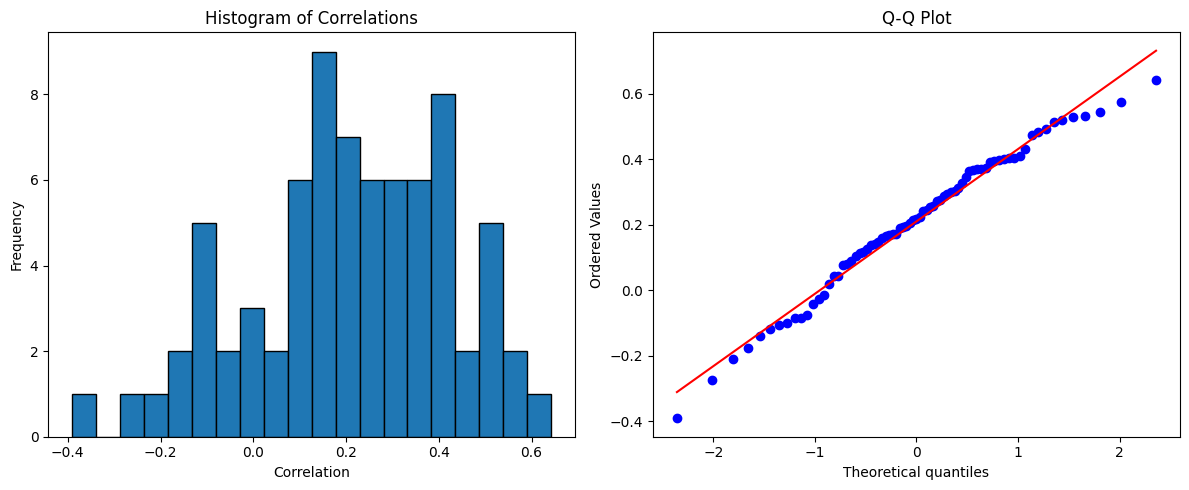


--- APA Style Results ---
Descriptive Statistics:
M = 0.21, SD = 0.22, 95% CI [0.16, 0.26]
N = 75

Normality Assessment:
Shapiro-Wilk test: W(74) = 0.982, p = 0.383

Inference Statistics:
One-sample t-test: t(74) = 8.34, p < .001, d = 0.96
Wilcoxon signed-rank test: W = 265.0, p < .001

APA Formatted Results Section:
The correlation coefficients (M = 0.21, SD = 0.22) were significantly different from zero, t(74) = 8.34, p < .001, d = 0.96, 95% CI [0.16, 0.26].


In [42]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Use the correct variable name from your code
all_correlations = all_correlations_pyradiomics_wholebrain

# Number of values in all_correlations
num_correlations = len(all_correlations)

# Descriptive statistics
mean_correlation = np.mean(all_correlations)
std_correlation = np.std(all_correlations, ddof=1)  # Using N-1 for sample std dev

# Wilcoxon signed-rank test
wilcoxon_statistic, wilcoxon_p_value = stats.wilcoxon(all_correlations)

# One-sample t-test
t_statistic, t_p_value = stats.ttest_1samp(all_correlations, 0)

# Calculate Cohen's d for one-sample t-test
cohens_d = mean_correlation / std_correlation  # For one-sample t-test comparing to zero

# Calculate 95% confidence interval
degrees_freedom = num_correlations - 1
ci_95 = stats.t.interval(0.95, degrees_freedom, loc=mean_correlation, 
                         scale=std_correlation/np.sqrt(num_correlations))

# Check normality using Shapiro-Wilk test
shapiro_statistic, shapiro_p_value = stats.shapiro(all_correlations)

# Create Q-Q plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram
ax1.hist(all_correlations, bins=20, edgecolor='black')
ax1.set_title('Histogram of Correlations')
ax1.set_xlabel('Correlation')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(all_correlations, dist="norm", plot=ax2)
ax2.set_title("Q-Q Plot")
plt.tight_layout()
plt.show()

# Format p-values according to APA
def format_p_value(p):
    if p < 0.001:
        return "p < .001"
    else:
        return f"p = {p:.3f}"

# Print statistical results in APA format
print("\n--- APA Style Results ---")
print("Descriptive Statistics:")
print(f"M = {mean_correlation:.2f}, SD = {std_correlation:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
print(f"N = {num_correlations}")

print("\nNormality Assessment:")
print(f"Shapiro-Wilk test: W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}")

print("\nInference Statistics:")
print(f"One-sample t-test: t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}")
print(f"Wilcoxon signed-rank test: W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}")

# APA formatted result (ready for copy-paste)
print("\nAPA Formatted Results Section:")
if shapiro_p_value >= 0.05:
    print(f"The correlation coefficients (M = {mean_correlation:.2f}, SD = {std_correlation:.2f}) were {'not ' if t_p_value >= 0.05 else ''}significantly different from zero, t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}, 95% CI [{ci_95[0]:.2f}, {ci_95[1]:.2f}].")
else:
    print(f"Due to the non-normal distribution of correlation coefficients (Shapiro-Wilk W({degrees_freedom}) = {shapiro_statistic:.3f}, {format_p_value(shapiro_p_value)}), a Wilcoxon signed-rank test was conducted. The correlations (Mdn = {np.median(all_correlations):.2f}) were {'not ' if wilcoxon_p_value >= 0.05 else ''}significantly different from zero, W = {wilcoxon_statistic:.1f}, {format_p_value(wilcoxon_p_value)}. For completeness, a t-test yielded t({degrees_freedom}) = {t_statistic:.2f}, {format_p_value(t_p_value)}, d = {cohens_d:.2f}.")

## Plots

/home/dragon/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/seaborn/categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-.5, n - .5, auto=None)
/home/dragon/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/seaborn/categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-.5, n - .5, auto=None)
/home/dragon/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/seaborn/categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-.5, n - .5, auto=None)
/home/dragon/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/seaborn/categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_x

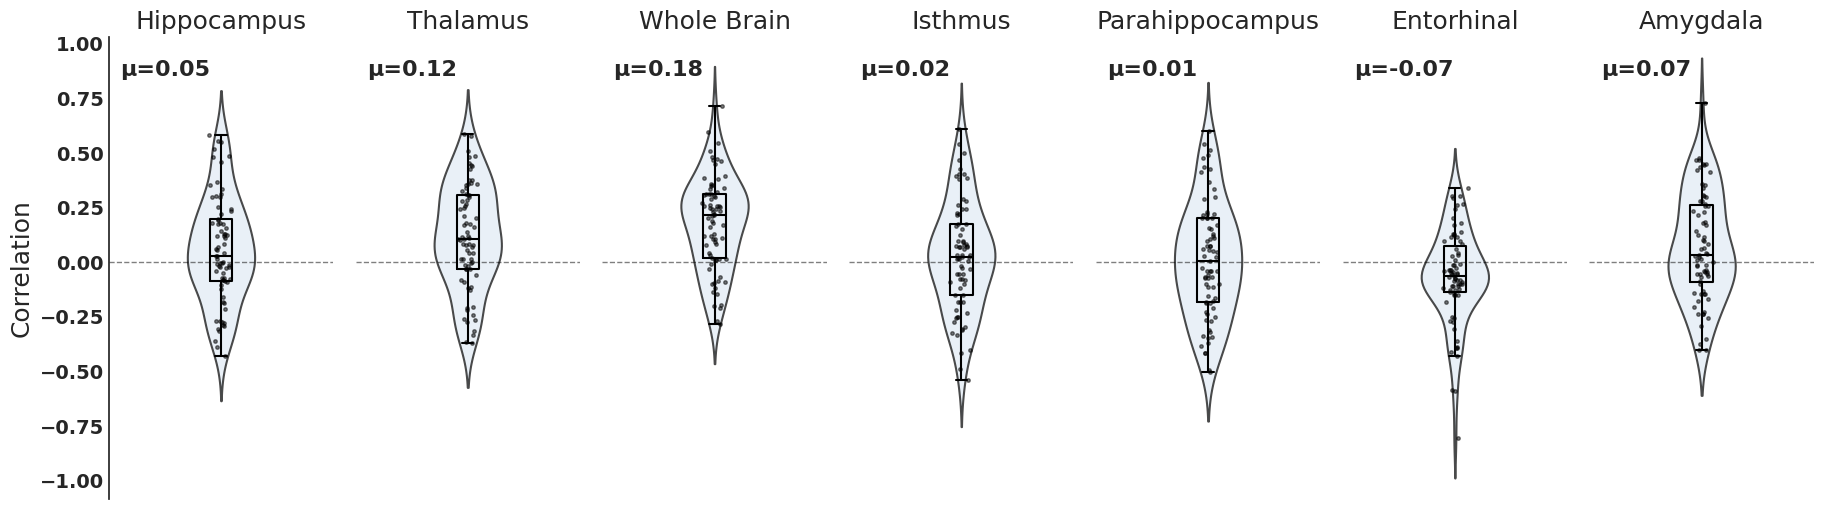

/home/dragon/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/seaborn/categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-.5, n - .5, auto=None)
/home/dragon/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/seaborn/categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-.5, n - .5, auto=None)
/home/dragon/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/seaborn/categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-.5, n - .5, auto=None)
/home/dragon/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/seaborn/categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_x

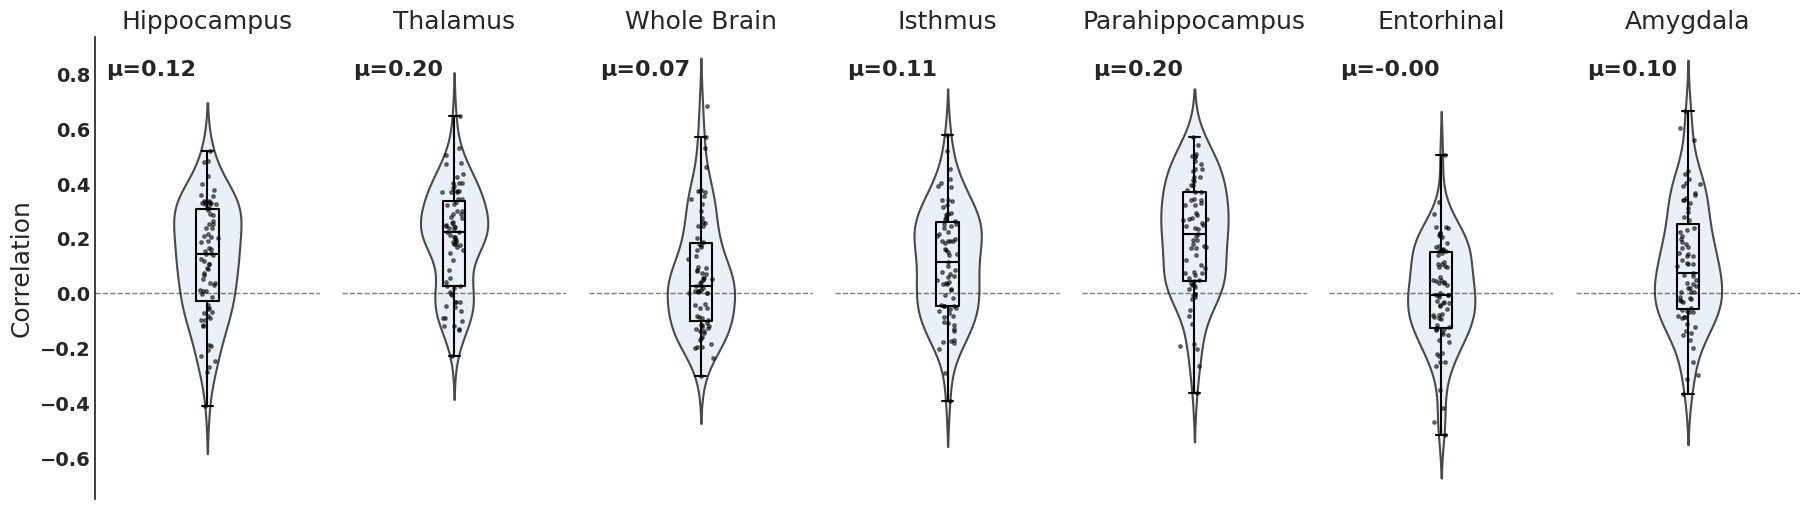

/home/dragon/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/seaborn/categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-.5, n - .5, auto=None)
/home/dragon/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/seaborn/categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-.5, n - .5, auto=None)
/home/dragon/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/seaborn/categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-.5, n - .5, auto=None)
/home/dragon/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/seaborn/categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_x

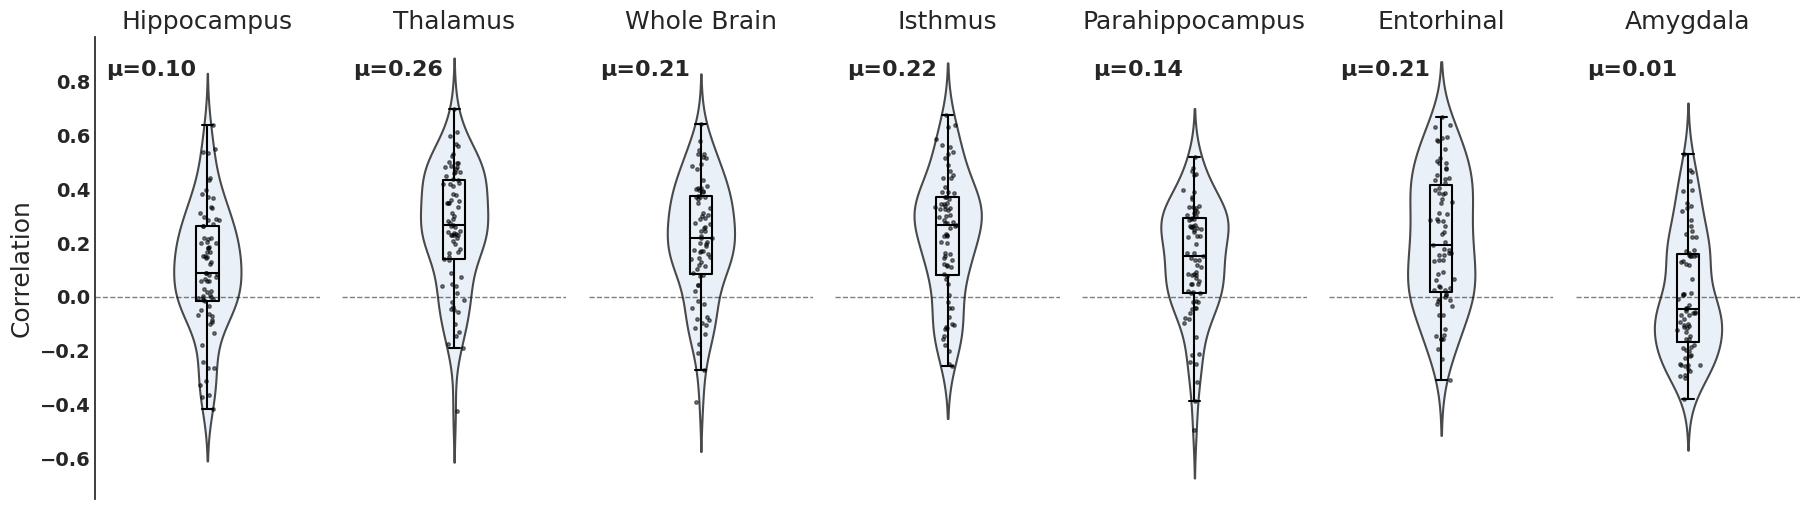

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_linked_violin_plots(data_arrays, titles, y_label, model_name):
    """
    Create 7 linked violin plots in a 1x7 horizontal layout with a transparent background.
    """
    plt.style.use('seaborn-v0_8-white')
    # Increased figsize width from 12 to 22 to give plots more space
    fig, axes = plt.subplots(1, 7, figsize=(22, 6), sharex=True, sharey=True)
    
    # Define a single color for all plots as in the original code
    colors = ['#DEEBF7'] * 7  # light blue for all regions
    
    # Make figure background transparent
    fig.patch.set_alpha(0.0)
    
    for idx, (ax, data, title, color) in enumerate(zip(axes, data_arrays, titles, colors)):
        # Make subplot background transparent
        ax.patch.set_alpha(0.0)
        
        # Create violin plot with fill color
        violin = sns.violinplot(y=data,
                                ax=ax,
                                inner=None,
                                color=color,
                                linewidth=1.5,
                                width=0.3)
        
        # Adjust violin plot appearance
        for patch in violin.collections:
            patch.set_alpha(0.7)  # Semi-transparent fill
            patch.set_edgecolor('black')
        
        # Add custom box plot in black
        ax.boxplot(data,
                   positions=[0],
                   widths=0.1,
                   patch_artist=False,
                   boxprops=dict(color='black', linewidth=1.5),
                   whiskerprops=dict(color='black', linewidth=1.5),
                   capprops=dict(color='black', linewidth=1.5),
                   medianprops=dict(color='black', linewidth=1.5),
                   showfliers=False)
        
        # Add scatter plot points with jitter
        x = np.random.normal(0, 0.02, size=len(data))
        ax.plot(x, data, '.',
                color='black',
                alpha=0.5,
                markersize=5)
        
        # Add mean value text
        mean_val = np.mean(data)
        # Decreased fontsize from 20 to 16
        ax.text(0.05, 0.95, f'μ={mean_val:.2f}',
                transform=ax.transAxes,
                verticalalignment='top',
                fontsize=16,
                weight='bold',
                bbox=dict(facecolor='none', edgecolor='none'))
        
        # Add horizontal line at y=0
        ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        
        # Customize subplot
        # Decreased title fontsize from 20 to 18
        ax.set_title(title, fontsize=18)
        
        # Handle y-axis
        if idx == 0:
            # Decreased y-label fontsize from 20 to 18
            ax.set_ylabel(y_label, fontsize=18)
            ax.yaxis.set_tick_params(labelright=False)
            # Decreased tick label size from 16 to 14
            ax.tick_params(axis='y', labelsize=14)
            for label in ax.get_yticklabels():
                label.set_fontweight('bold')
        else:
            ax.set_ylabel('')
            ax.tick_params(axis='y', which='both', left=False, labelleft=False)
            ax.spines['left'].set_visible(False)
        
        # Remove x-axis
        ax.set_xticks([])
        ax.set_xlabel('')
        ax.spines['bottom'].set_visible(False)
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        ax.grid(False)
        ax.set_xlim(-0.5, 0.5)
    
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.1) # Adjusted wspace for better spacing
    
    # Add a figure title to show the model type
    #fig.suptitle(f'Model: {model_name}', fontsize=24, y=1.02)
    
    # Save figure with transparent background
    plt.savefig(f'violin_plots_7regions_notitle_{model_name}.svg', format='svg', bbox_inches='tight', transparent=True)
    plt.show()
    plt.close()

# Note: You will need to define your data variables (e.g., all_correlations_pointnet_hippo)
# before this section for the script to run.

# Reorganize data arrays to group by model type instead of brain region
pointnet_data = [
    all_correlations_pointnet_hippo,
    all_correlations_pointnet_thalamus,
    all_correlations_pointnet_wholebrain,
    all_correlations_pointnet_isthmuscingulate,
    all_correlations_pointnet_parahippocampus,
    all_correlations_pointnet_entorhinal,
    all_correlations_pointnet_amygdala
]

densenet_data = [
    all_correlations_densenet_hippo,
    all_correlations_densenet_thalamus,
    all_correlations_densenet_wholebrain,
    all_correlations_densenet_isthmuscingulate,
    all_correlations_densenet_parahippocampus,
    all_correlations_densenet_entorhinal,
    all_correlations_densenet_amygdala
]

pyradiomics_data = [
    all_correlations_pyradiomics_hippocampus,
    all_correlations_pyradiomics_thalamus,
    all_correlations_pyradiomics_wholebrain,
    all_correlations_pyradiomics_isthmuscingulate,
    all_correlations_pyradiomics_parahippocampus,
    all_correlations_pyradiomics_entorhinal,
    all_correlations_pyradiomics_amygdala
]

# Update titles to match brain regions
region_titles = ['Hippocampus', 'Thalamus', 'Whole Brain', 'Isthmus', 'Parahippocampus', 'Entorhinal', 'Amygdala']
y_label = 'Correlation'

# Create three separate plots, one for each model
create_linked_violin_plots(pointnet_data, region_titles, y_label, 'PointNet++')
create_linked_violin_plots(densenet_data, region_titles, y_label, 'DenseNet')
create_linked_violin_plots(pyradiomics_data, region_titles, y_label, 'Random Forest')



/home/dragon/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/seaborn/categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-.5, n - .5, auto=None)
/home/dragon/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/seaborn/categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-.5, n - .5, auto=None)


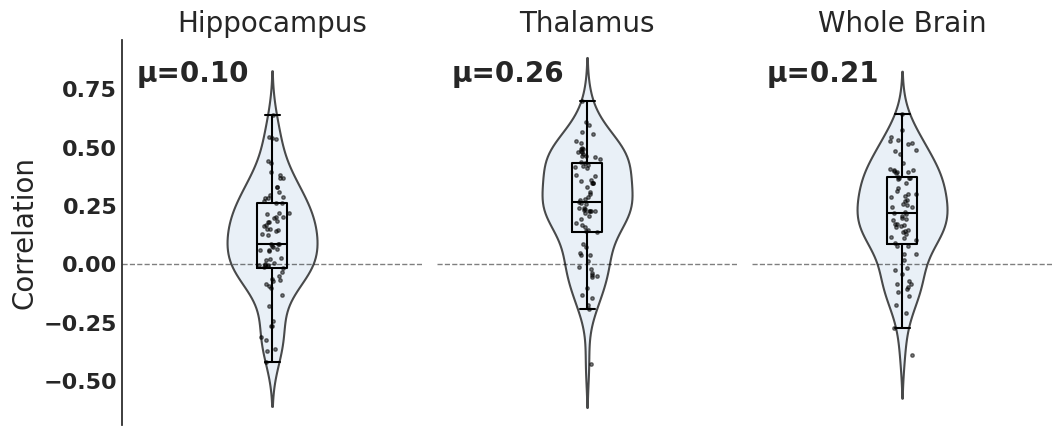

/home/dragon/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/seaborn/categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-.5, n - .5, auto=None)
/home/dragon/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/seaborn/categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-.5, n - .5, auto=None)


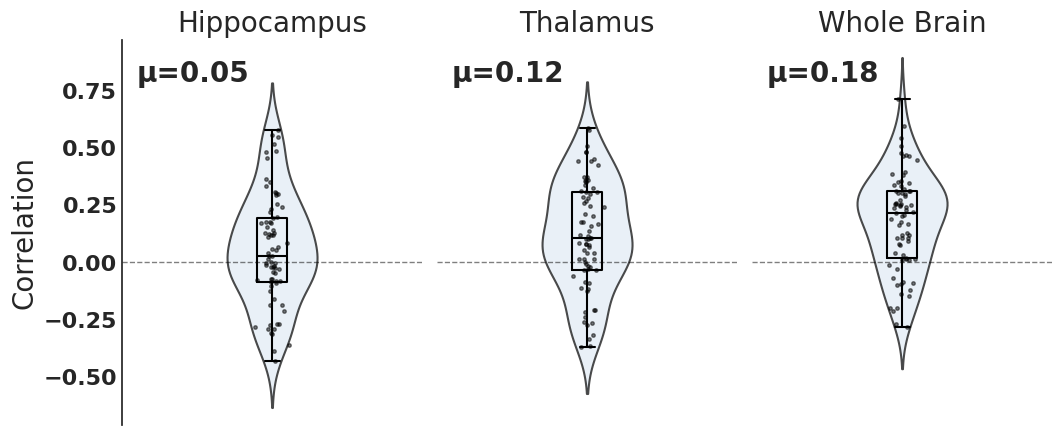

/home/dragon/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/seaborn/categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-.5, n - .5, auto=None)
/home/dragon/.local/share/pipx/venvs/notebook/lib/python3.12/site-packages/seaborn/categorical.py:379: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(-.5, n - .5, auto=None)


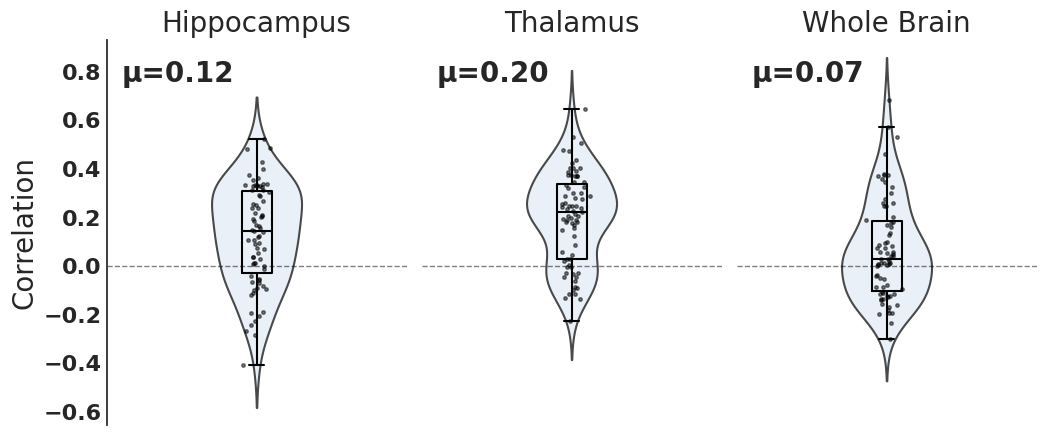

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_linked_violin_plots(data_arrays, titles, y_label, model_name):
    """
    Create 3 linked violin plots in a 1x3 horizontal layout with transparent background
    Colors are region-specific:
    - Hippocampus: Blues
    - Thalamus: Greens
    - Wholebrain: Reds
    """
    plt.style.use('seaborn-v0_8-white')
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True)
    
    # Define colors for each region
    colors = ['#DEEBF7', '#DEEBF7', '#DEEBF7']  # light blue for Hippocampus, Thalamus, Whole Brain
    
    # Make figure background transparent
    fig.patch.set_alpha(0.0)
    
    for idx, (ax, data, title, color) in enumerate(zip(axes, data_arrays, titles, colors)):
        # Make subplot background transparent
        ax.patch.set_alpha(0.0)
        
        # Create violin plot with fill color
        violin = sns.violinplot(y=data, 
                              ax=ax,
                              inner=None,
                              color=color,
                              linewidth=1.5,
                              width=0.3)
        
        # Adjust violin plot appearance
        for patch in violin.collections:
            patch.set_alpha(0.7)  # Semi-transparent fill
            patch.set_edgecolor('black')
        
        # Add custom box plot in black
        ax.boxplot(data,
                  positions=[0],
                  widths=0.1,
                  patch_artist=False,
                  boxprops=dict(color='black', linewidth=1.5),
                  whiskerprops=dict(color='black', linewidth=1.5),
                  capprops=dict(color='black', linewidth=1.5),
                  medianprops=dict(color='black', linewidth=1.5),
                  showfliers=False)
        
        # Add scatter plot points with jitter
        x = np.random.normal(0, 0.02, size=len(data))
        ax.plot(x, data, '.',
               color='black',
               alpha=0.5,
               markersize=5)
        
        # Add mean value text
        mean_val = np.mean(data)
        ax.text(0.05, 0.95, f'μ={mean_val:.2f}', 
                transform=ax.transAxes,
                verticalalignment='top',
                fontsize=20,
                weight='bold',
                bbox=dict(facecolor='none', edgecolor='none'))
        
        # Add horizontal line at y=0
        ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        
        # Customize subplot
        ax.set_title(title, fontsize=20)
        
        # Handle y-axis
        if idx == 0:
            ax.set_ylabel(y_label, fontsize=20)
            ax.yaxis.set_tick_params(labelright=False)
            ax.tick_params(axis='y', labelsize=16)
            for label in ax.get_yticklabels():
                label.set_fontweight('bold')
        else:
            ax.set_ylabel('')
            ax.tick_params(axis='y', which='both', left=False, labelleft=False)
            ax.spines['left'].set_visible(False)
        
        # Remove x-axis
        ax.set_xticks([])
        ax.set_xlabel('')
        ax.spines['bottom'].set_visible(False)
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        ax.grid(False)
        ax.set_xlim(-0.5, 0.5)
    
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.05)
    
    # Add a figure title to show the model type
    #fig.suptitle(f'Model: {model_name}', fontsize=24, y=0.98)
    
    # Save figure with transparent background
    plt.savefig(f'violin_plots_3regions_{model_name}.svg', format='svg', bbox_inches='tight', transparent=True)
    plt.show()
    plt.close()

# Reorganize data arrays to group by model type instead of brain region
pyradiomics_data = [
    all_correlations_pyradiomics_hippocampus,
    all_correlations_pyradiomics_thalamus,
    all_correlations_pyradiomics_wholebrain
]

pointnet_data = [
    all_correlations_pointnet_hippo,
    all_correlations_pointnet_thalamus,
    all_correlations_pointnet_wholebrain
]

densenet_data = [
    all_correlations_densenet_hippo,
    all_correlations_densenet_thalamus,
    all_correlations_densenet_wholebrain
]

# Update titles to match brain regions
region_titles = ['Hippocampus', 'Thalamus', 'Whole Brain']
y_label = 'Correlation'

# Create three separate plots, one for each model
create_linked_violin_plots(pyradiomics_data, region_titles, y_label, 'Random Forest')
create_linked_violin_plots(pointnet_data, region_titles, y_label, 'PointNet++')
create_linked_violin_plots(densenet_data, region_titles, y_label, 'DenseNet')